In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract the ZIP file
import zipfile
import os

zip_path = '/content/drive/MyDrive/MyDataset.zip'
extract_to = '/content/extracted_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to: {extract_to}")
print("\nDirectory structure:")
for root, dirs, files in os.walk(extract_to):
    level = root.replace(extract_to, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files)-5} more files")

Extracted to: /content/extracted_data

Directory structure:
extracted_data/
  MyDataset/
    metadata.xlsx
    audio/
      english/
        song_87.mp3
        song_114.mp3
        song_102.mp3
        song_96.mp3
        song_107.mp3
        ... and 55 more files
      bangla/
        song_46.mp3
        song_04.mp3
        song_40.mp3
        song_21.mp3
        song_11.mp3
        ... and 55 more files


In [ ]:
# Install required packages
!pip install librosa --break-system-packages

In [18]:
# Music VAE for Feature Extraction

import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
import os
warnings.filterwarnings('ignore')

print("="*70)
print("LOADING DATASET WITH NEW STRUCTURE")
print("="*70)

# Find dataset structure
dataset_root = os.path.join(extract_to, 'MyDataset')
audio_root = os.path.join(dataset_root, 'audio')

# Find metadata file (can be CSV or XLSX)
metadata_path = None

# First check for metadata files directly in MyDataset folder
for file in os.listdir(dataset_root):
    if file.endswith('.csv') or file.endswith('.xlsx'):
        metadata_path = os.path.join(dataset_root, file)
        break

# If not found, check if there's a Metadata subfolder
if metadata_path is None:
    metadata_folder = os.path.join(dataset_root, 'Metadata')
    if os.path.exists(metadata_folder):
        for file in os.listdir(metadata_folder):
            if file.endswith('.csv') or file.endswith('.xlsx'):
                metadata_path = os.path.join(metadata_folder, file)
                break

if metadata_path is None:
    raise FileNotFoundError("No metadata file (.csv or .xlsx) found in MyDataset folder or Metadata subfolder")

# Load metadata
if metadata_path.endswith('.xlsx'):
    metadata = pd.read_excel(metadata_path)
    print(f"✓ Loaded Excel metadata: {os.path.basename(metadata_path)}")
else:
    metadata = pd.read_csv(metadata_path)
    print(f"✓ Loaded CSV metadata: {os.path.basename(metadata_path)}")

print(f"✓ Found audio folder: {audio_root}")
print(f"\nMetadata shape: {metadata.shape}")
print("\nMetadata columns:")
print(metadata.columns.tolist())
print("\nFirst 5 rows:")
print(metadata.head())

# Check language distribution
print("\n" + "="*70)
print("DATASET STATISTICS")
print("="*70)
print(f"\nLanguage distribution:")
print(metadata['language'].value_counts())
if 'genre' in metadata.columns:
    print(f"\nGenre distribution:")
    print(metadata['genre'].value_counts())
print(f"\nTotal songs: {len(metadata)}")

# VAE Model
class MusicVAE(nn.Module):
    def __init__(self, input_dim=128, latent_dim=32):
        super(MusicVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(48, latent_dim)
        self.fc_logvar = nn.Linear(48, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# Audio Dataset
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, n_mfcc=128):
        self.audio_paths = audio_paths
        self.labels = labels
        self.n_mfcc = n_mfcc

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]

        # Load audio and extract MFCC features
        y, sr = librosa.load(audio_path, duration=3.0, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)

        # Average over time to get fixed size
        mfcc_mean = np.mean(mfcc, axis=1)

        return torch.FloatTensor(mfcc_mean), self.labels[idx]

# Prepare audio file paths based on directory structure
print("\n" + "="*70)
print("PREPARING AUDIO FILES")
print("="*70)

audio_files = []
labels = []
filenames = []

# Process each language folder (lowercase folder names)
for lang_folder in ['bangla', 'english']:
    lang_path = os.path.join(audio_root, lang_folder)

    if not os.path.exists(lang_path):
        print(f"Warning: {lang_path} not found, skipping...")
        continue

    files = [f for f in os.listdir(lang_path) if f.endswith(('.mp3', '.wav', '.flac'))]

    for file in files[:100]:  # Limit to 100 per language for faster processing
        full_path = os.path.join(lang_path, file)
        audio_files.append(full_path)
        labels.append(0 if lang_folder == 'bangla' else 1)
        filenames.append(f"{lang_folder}/{file}")

    print(f"  ✓ {lang_folder.capitalize()}: {len(files)} files found, using first 100")

print(f"\nTotal audio files to process: {len(audio_files)}")
print(f"  Bangla: {sum([1 for l in labels if l == 0])}")
print(f"  English: {sum([1 for l in labels if l == 1])}")

# Create dataset and dataloader
dataset = AudioDataset(audio_files, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = MusicVAE(input_dim=128, latent_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
print("\n" + "="*70)
print("TRAINING VAE")
print("="*70)

num_epochs = 50
losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader.dataset)
    losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")

# Extract latent features
print("\n" + "="*70)
print("EXTRACTING LATENT FEATURES")
print("="*70)

model.eval()
latent_features = []
true_labels = []

with torch.no_grad():
    for data, label in dataset:
        data = data.unsqueeze(0).to(device)
        mu, _ = model.encode(data)
        latent_features.append(mu.cpu().numpy().flatten())
        true_labels.append(label)

latent_features = np.array(latent_features)

# Create features dataframe
features_df = pd.DataFrame(
    latent_features,
    columns=[f'feature_{i}' for i in range(latent_features.shape[1])]
)

features_df['filename'] = filenames
features_df['language'] = ['bangla' if l == 0 else 'english' for l in true_labels]

# Save features
features_df.to_csv('/content/audio_vae_features.csv', index=False)
print(f"\n✓ Saved latent features: {features_df.shape}")
print(f"  File: /content/audio_vae_features.csv")
print("\nFeatures preview:")
print(features_df.head())

LOADING DATASET WITH NEW STRUCTURE
✓ Loaded Excel metadata: metadata.xlsx
✓ Found audio folder: /content/extracted_data/MyDataset/audio

Metadata shape: (120, 8)

Metadata columns:
['filenaming', 'language', 'song_title', 'singer', 'genre', 'language_id', 'release_year', 'lyrics']

First 5 rows:
           filenaming language          song_title             singer genre  \
0  bangla/song_01.mp3   Bangla  Long Distance Love       Ankan, Afrin  Rock   
1  bangla/song_02.mp3   Bangla            আবার যদি         Angel Noor   Pop   
2  bangla/song_03.mp3   Bangla                 কদম  Naim Imran Sharot  Folk   
3  bangla/song_04.mp3   Bangla   এমন একটা সময় ছিল            Pancham  Rock   
4  bangla/song_05.mp3   Bangla               ঈশ্বর      Tonmoy Tansen  Rock   

   language_id  release_year  \
0            0          2025   
1            0          2024   
2            0          2019   
3            0          1993   
4            0          2019   

                                   

Output directory: /content/drive/MyDrive/clustering_results

Loaded features: (120, 34)

Columns: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'filename', 'language']

First rows:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.024544  -0.174556   0.445317   0.001523  -0.761176   0.044388   
1  -0.249027   0.068036   0.051223   0.272492  -0.528212   0.528900   
2  -0.238385   0.007238   0.226222   0.262346  -0.219729   0.756318   
3  -0.493636  -0.043127   0.496528   0.258604  -0.879687   0.454216   
4   0.206674  -0.225089  -0.726351   0.337638  -0.268786   0.718160   


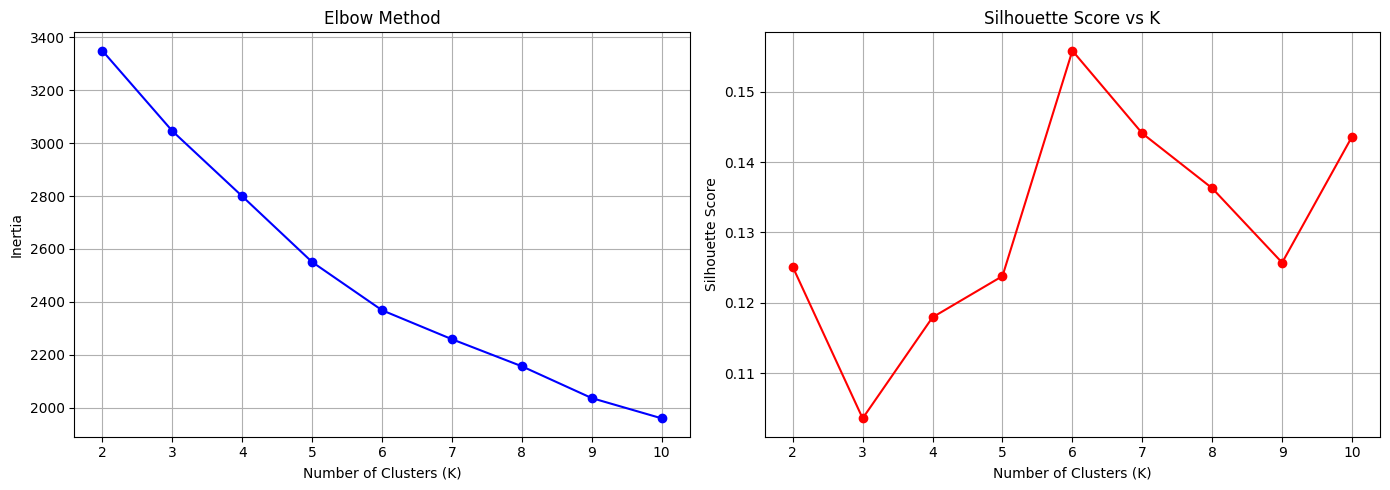


K-Means Clustering (K=2)

Silhouette Score: 0.125
Davies-Bouldin Score: 2.423

Cluster vs Language Distribution
cluster    0   1  Total
language               
bangla    20  40     60
english   30  30     60
Total     50  70    120

Cluster Purity: 0.583

✓ Saved clustered features: /content/drive/MyDrive/clustering_results/audio_vae_features_clustered.csv


In [14]:
# K-Means Clustering on VAE Latent Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import os

# Create output directory
output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory: {output_dir}")

# Load features
features_df = pd.read_csv('/content/audio_vae_features.csv')

print(f"\nLoaded features: {features_df.shape}")
print("\nColumns:", features_df.columns.tolist())
print("\nFirst rows:")
print(features_df.head())

# Get feature columns
feature_cols = [col for col in features_df.columns if col.startswith('feature_')]
X = features_df[feature_cols].values

print(f"\nFeature matrix shape: {X.shape}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal K using elbow method
print("\n" + "="*50)
print("Finding optimal K (Elbow Method)")
print("="*50)

inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

# Plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs K')
ax2.grid(True)

plt.tight_layout()
save_path = os.path.join(output_dir, 'optimal_k.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {save_path}")
plt.show()

# Perform K-Means with k=2 (bangla vs english)
print("\n" + "="*50)
print("K-Means Clustering (K=2)")
print("="*50)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
features_df['cluster'] = kmeans.fit_predict(X_scaled)

# Clustering metrics
sil_score = silhouette_score(X_scaled, features_df['cluster'])
db_score = davies_bouldin_score(X_scaled, features_df['cluster'])

print(f"\nSilhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

# Compare clusters with actual labels
print("\n" + "="*50)
print("Cluster vs Language Distribution")
print("="*50)

crosstab = pd.crosstab(features_df['language'], features_df['cluster'],
                       margins=True, margins_name='Total')
print(crosstab)

# Calculate clustering purity
language_numeric = features_df['language'].map({'bangla': 0, 'english': 1})
cm = confusion_matrix(language_numeric, features_df['cluster'])
purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)

print(f"\nCluster Purity: {purity:.3f}")

# Save clustered data
output_path = os.path.join(output_dir, 'audio_vae_features_clustered.csv')
features_df.to_csv(output_path, index=False)
print(f"\n✓ Saved clustered features: {output_path}")

Loading features...
✓ Loaded metadata: metadata.xlsx
✓ Loaded 120 samples
Columns: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'filename', 'language', 'cluster', 'base_filename', 'genre']

Feature matrix shape: (120, 32)

Running t-SNE...
✓ t-SNE complete!

Running UMAP...
✓ UMAP complete!

Creating t-SNE visualizations...
✓ Saved: /content/drive/MyDrive/clustering_results/tsne_visualization_4views.png


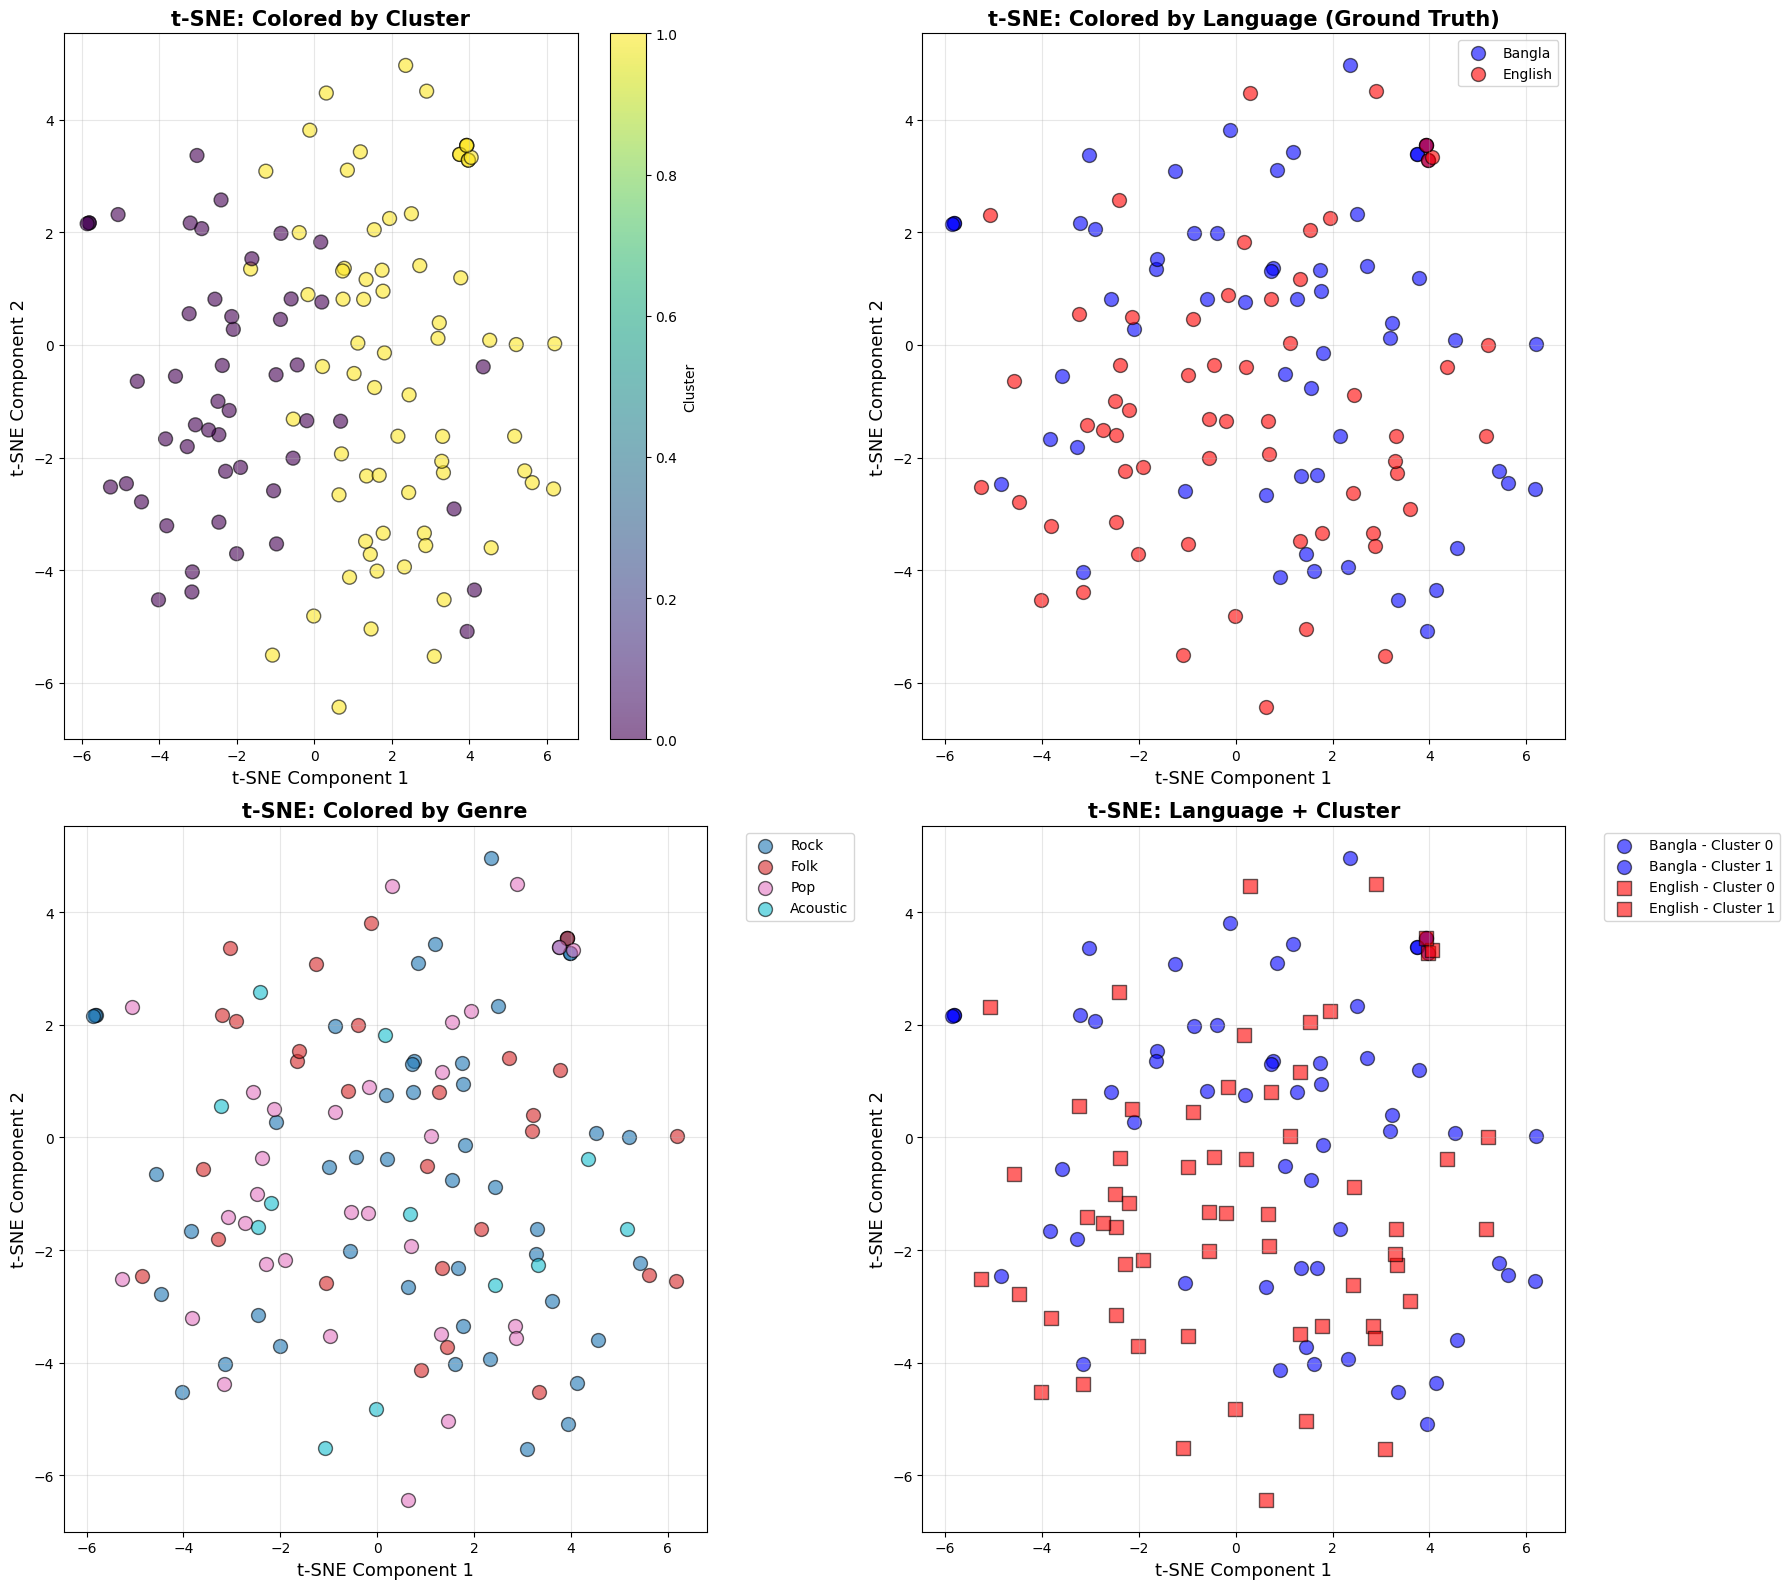


Creating UMAP visualizations...
✓ Saved: /content/drive/MyDrive/clustering_results/umap_visualization_4views.png


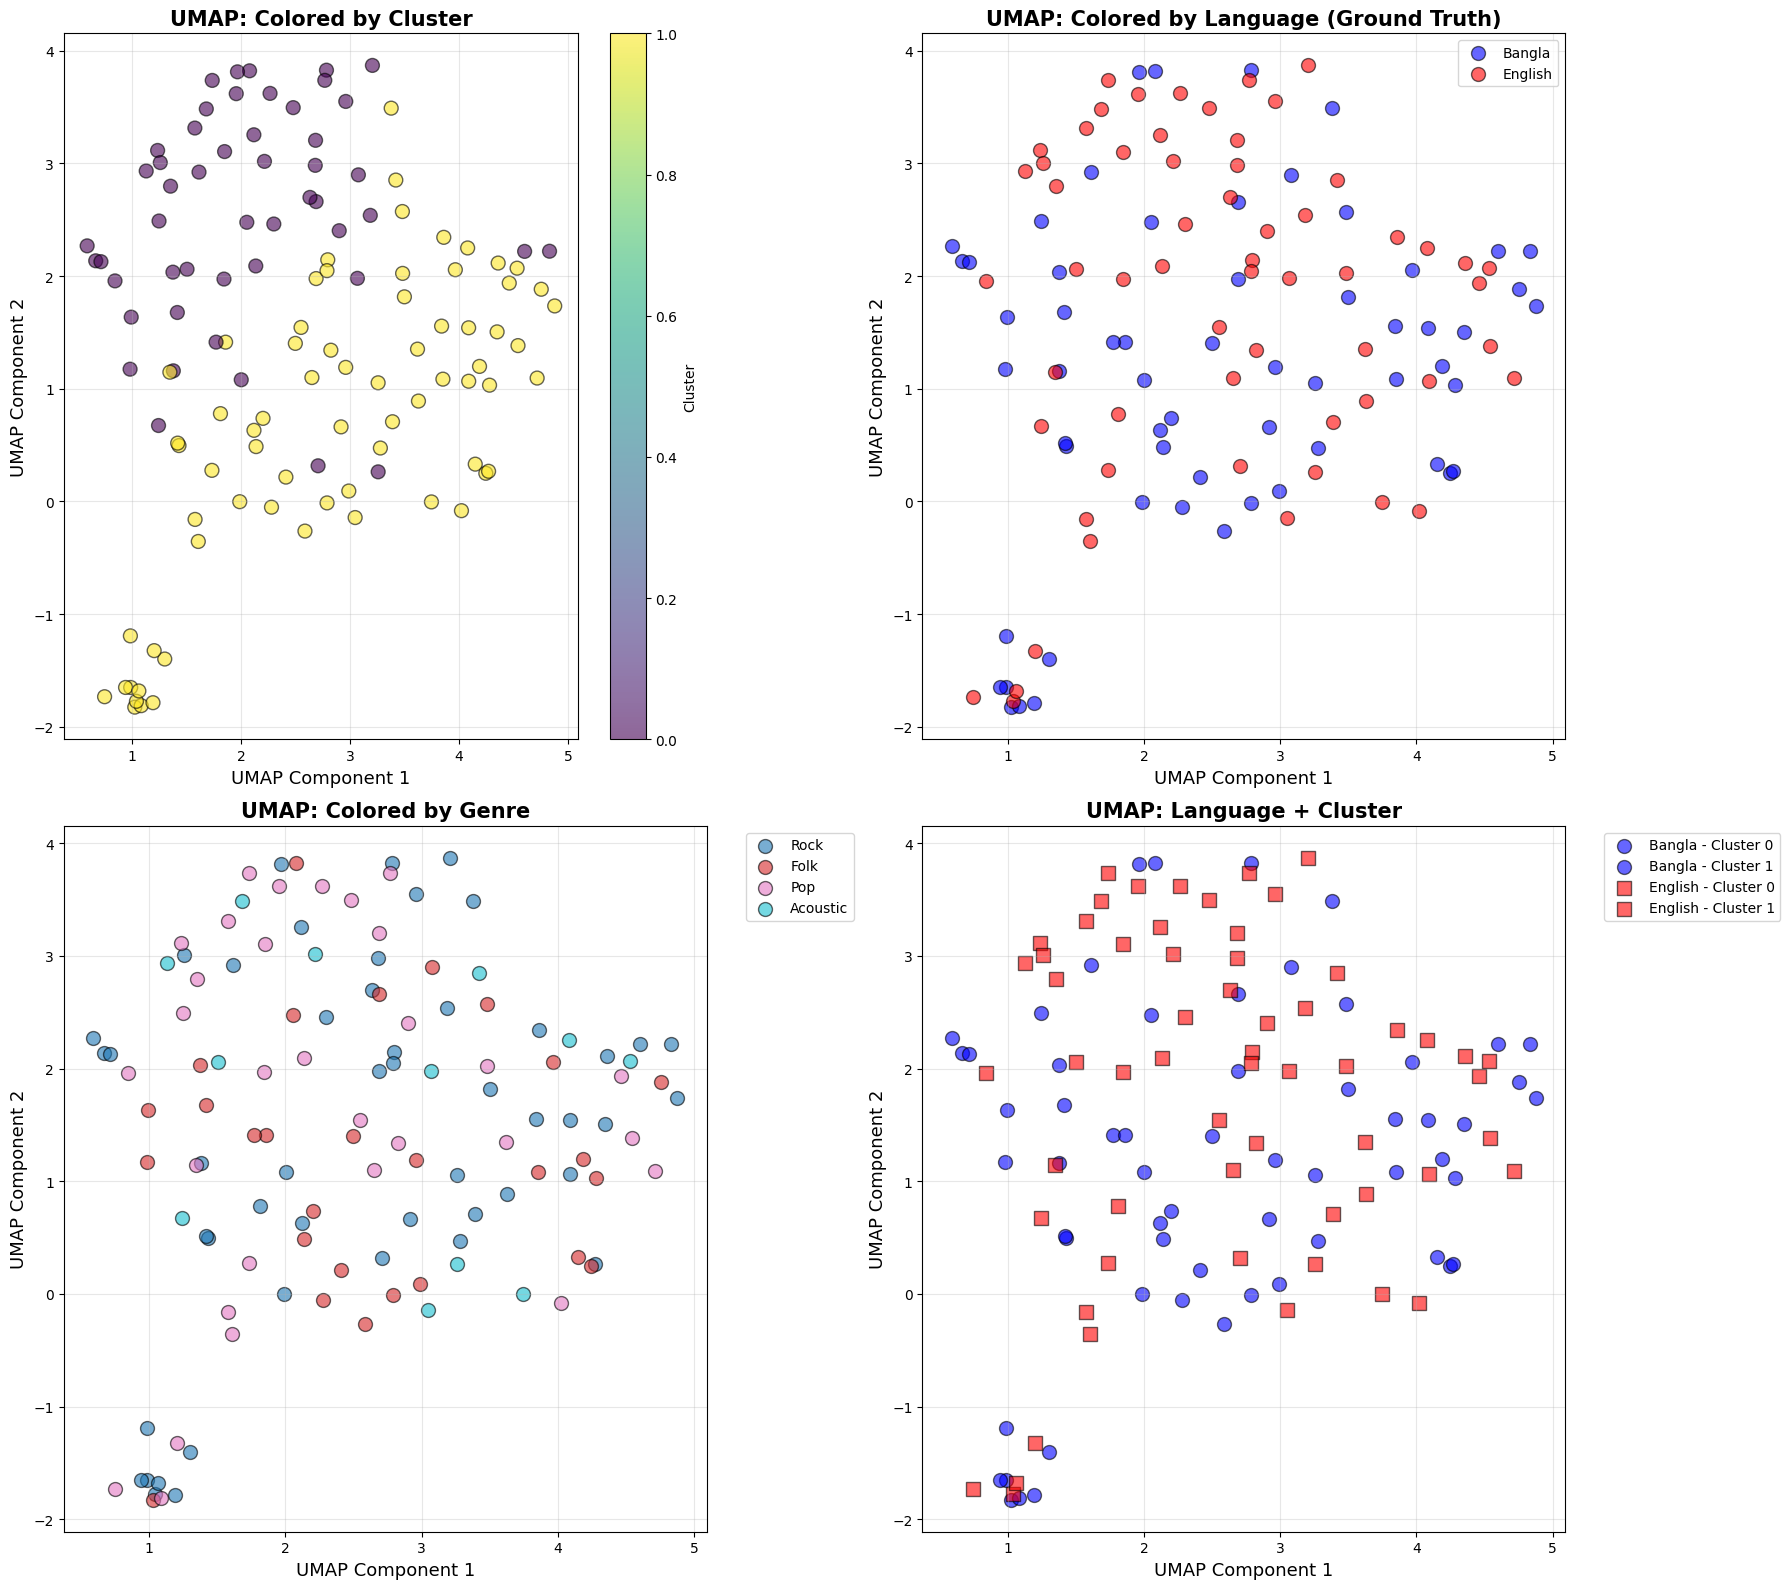


✓ VISUALIZATION COMPLETE!

All visualizations saved to: /content/drive/MyDrive/clustering_results


In [15]:
# t-SNE and UMAP Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import subprocess
import warnings
import os
warnings.filterwarnings('ignore')

# Install UMAP
subprocess.run(['pip', 'install', 'umap-learn', '--break-system-packages'],
               capture_output=True)

import umap

output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

print("Loading features...")
features_df = pd.read_csv(os.path.join(output_dir, 'audio_vae_features_clustered.csv'))

# Load original metadata for genre info
dataset_root = os.path.join(extract_to, 'MyDataset')

# Find metadata file (CSV or XLSX)
metadata_path = None

# Check directly in MyDataset folder first
for file in os.listdir(dataset_root):
    if file.endswith('.csv') or file.endswith('.xlsx'):
        metadata_path = os.path.join(dataset_root, file)
        break

# If not found, check Metadata subfolder
if metadata_path is None:
    metadata_folder = os.path.join(dataset_root, 'Metadata')
    if os.path.exists(metadata_folder):
        for file in os.listdir(metadata_folder):
            if file.endswith('.csv') or file.endswith('.xlsx'):
                metadata_path = os.path.join(metadata_folder, file)
                break

if metadata_path is None:
    print("Warning: No metadata file found, skipping genre mapping")
    features_df['genre'] = 'Unknown'
else:
    # Load metadata (handle both CSV and Excel)
    if metadata_path.endswith('.xlsx'):
        metadata = pd.read_excel(metadata_path)
    else:
        metadata = pd.read_csv(metadata_path)

    print(f"✓ Loaded metadata: {os.path.basename(metadata_path)}")

    # Create a mapping from filename to genre
    # Extract just the base filename from the metadata 'filenaming' column
    metadata['base_filename'] = metadata['filenaming'].apply(lambda x: os.path.basename(x))
    genre_map = dict(zip(metadata['base_filename'], metadata['genre']))

    # Match with features
    features_df['base_filename'] = features_df['filename'].apply(lambda x: os.path.basename(x))
    features_df['genre'] = features_df['base_filename'].map(genre_map)
    features_df['genre'] = features_df['genre'].fillna('Unknown')

print(f"✓ Loaded {len(features_df)} samples")
print(f"Columns: {features_df.columns.tolist()}")

# Get feature columns
feature_cols = [col for col in features_df.columns if col.startswith('feature_')]
X = features_df[feature_cols].values

print(f"\nFeature matrix shape: {X.shape}")

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# t-SNE
print("\n" + "="*50)
print("Running t-SNE...")
print("="*50)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

features_df['tsne_1'] = X_tsne[:, 0]
features_df['tsne_2'] = X_tsne[:, 1]

print("✓ t-SNE complete!")

# UMAP
print("\n" + "="*50)
print("Running UMAP...")
print("="*50)

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_scaled)

features_df['umap_1'] = X_umap[:, 0]
features_df['umap_2'] = X_umap[:, 1]

print("✓ UMAP complete!")

# Visualization 1: t-SNE with 4 views
print("\n" + "="*50)
print("Creating t-SNE visualizations...")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# t-SNE by cluster
ax1 = axes[0, 0]
scatter = ax1.scatter(features_df['tsne_1'], features_df['tsne_2'],
                     c=features_df['cluster'],
                     cmap='viridis',
                     alpha=0.6,
                     edgecolors='k',
                     s=100)
ax1.set_xlabel('t-SNE Component 1', fontsize=13)
ax1.set_ylabel('t-SNE Component 2', fontsize=13)
ax1.set_title('t-SNE: Colored by Cluster', fontsize=15, fontweight='bold')
ax1.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster')

# t-SNE by language
ax2 = axes[0, 1]
colors = {'bangla': 'blue', 'english': 'red'}
for language in ['bangla', 'english']:
    mask = features_df['language'] == language
    ax2.scatter(features_df.loc[mask, 'tsne_1'],
               features_df.loc[mask, 'tsne_2'],
               c=colors[language],
               label=language.capitalize(),
               alpha=0.6,
               edgecolors='k',
               s=100)
ax2.set_xlabel('t-SNE Component 1', fontsize=13)
ax2.set_ylabel('t-SNE Component 2', fontsize=13)
ax2.set_title('t-SNE: Colored by Language (Ground Truth)', fontsize=15, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# t-SNE by genre
ax3 = axes[1, 0]
unique_genres = features_df['genre'].unique()
genre_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_genres)))
for genre, color in zip(unique_genres, genre_colors):
    mask = features_df['genre'] == genre
    ax3.scatter(features_df.loc[mask, 'tsne_1'],
               features_df.loc[mask, 'tsne_2'],
               c=[color],
               label=genre,
               alpha=0.6,
               edgecolors='k',
               s=100)
ax3.set_xlabel('t-SNE Component 1', fontsize=13)
ax3.set_ylabel('t-SNE Component 2', fontsize=13)
ax3.set_title('t-SNE: Colored by Genre', fontsize=15, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(alpha=0.3)

# Combined view
ax4 = axes[1, 1]
for language in ['bangla', 'english']:
    mask = features_df['language'] == language
    marker = 'o' if language == 'bangla' else 's'
    for cluster in [0, 1]:
        cluster_mask = mask & (features_df['cluster'] == cluster)
        ax4.scatter(features_df.loc[cluster_mask, 'tsne_1'],
                   features_df.loc[cluster_mask, 'tsne_2'],
                   c=colors[language],
                   marker=marker,
                   label=f"{language.capitalize()} - Cluster {cluster}",
                   alpha=0.6,
                   edgecolors='k',
                   s=100)
ax4.set_xlabel('t-SNE Component 1', fontsize=13)
ax4.set_ylabel('t-SNE Component 2', fontsize=13)
ax4.set_title('t-SNE: Language + Cluster', fontsize=15, fontweight='bold')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(alpha=0.3)

plt.tight_layout()
save_path = os.path.join(output_dir, 'tsne_visualization_4views.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")
plt.show()

# Visualization 2: UMAP with 4 views
print("\nCreating UMAP visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# UMAP by cluster
ax1 = axes[0, 0]
scatter = ax1.scatter(features_df['umap_1'], features_df['umap_2'],
                     c=features_df['cluster'],
                     cmap='viridis',
                     alpha=0.6,
                     edgecolors='k',
                     s=100)
ax1.set_xlabel('UMAP Component 1', fontsize=13)
ax1.set_ylabel('UMAP Component 2', fontsize=13)
ax1.set_title('UMAP: Colored by Cluster', fontsize=15, fontweight='bold')
ax1.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster')

# UMAP by language
ax2 = axes[0, 1]
for language in ['bangla', 'english']:
    mask = features_df['language'] == language
    ax2.scatter(features_df.loc[mask, 'umap_1'],
               features_df.loc[mask, 'umap_2'],
               c=colors[language],
               label=language.capitalize(),
               alpha=0.6,
               edgecolors='k',
               s=100)
ax2.set_xlabel('UMAP Component 1', fontsize=13)
ax2.set_ylabel('UMAP Component 2', fontsize=13)
ax2.set_title('UMAP: Colored by Language (Ground Truth)', fontsize=15, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# UMAP by genre
ax3 = axes[1, 0]
for genre, color in zip(unique_genres, genre_colors):
    mask = features_df['genre'] == genre
    ax3.scatter(features_df.loc[mask, 'umap_1'],
               features_df.loc[mask, 'umap_2'],
               c=[color],
               label=genre,
               alpha=0.6,
               edgecolors='k',
               s=100)
ax3.set_xlabel('UMAP Component 1', fontsize=13)
ax3.set_ylabel('UMAP Component 2', fontsize=13)
ax3.set_title('UMAP: Colored by Genre', fontsize=15, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(alpha=0.3)

# Combined view
ax4 = axes[1, 1]
for language in ['bangla', 'english']:
    mask = features_df['language'] == language
    marker = 'o' if language == 'bangla' else 's'
    for cluster in [0, 1]:
        cluster_mask = mask & (features_df['cluster'] == cluster)
        ax4.scatter(features_df.loc[cluster_mask, 'umap_1'],
                   features_df.loc[cluster_mask, 'umap_2'],
                   c=colors[language],
                   marker=marker,
                   label=f"{language.capitalize()} - Cluster {cluster}",
                   alpha=0.6,
                   edgecolors='k',
                   s=100)
ax4.set_xlabel('UMAP Component 1', fontsize=13)
ax4.set_ylabel('UMAP Component 2', fontsize=13)
ax4.set_title('UMAP: Language + Cluster', fontsize=15, fontweight='bold')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(alpha=0.3)

plt.tight_layout()
save_path = os.path.join(output_dir, 'umap_visualization_4views.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")
plt.show()

print("\n" + "="*50)
print("✓ VISUALIZATION COMPLETE!")
print("="*50)
print(f"\nAll visualizations saved to: {output_dir}")

VAE vs BASELINE COMPARISON

1. Loading VAE features...
  ✓ Loaded Basic VAE: (120, 34)
  VAE features shape: (120, 32)
  Labels: Bangla=60, English=60

2. Extracting baseline features (MFCC)...
  Processing 120 audio files...
    Processed 50/120 files
    Processed 100/120 files
  ✓ Baseline features shape: (120, 43)

3. Applying PCA to baseline features...
  PCA-10: Explained variance = 0.760
  PCA-20: Explained variance = 0.908
  PCA-32: Explained variance = 0.978

4. Performing K-Means Clustering (K=2)

[1/3] VAE + K-Means...
  ✓ Silhouette: 0.1251
  ✓ Calinski-Harabasz: 17.30
  ✓ Davies-Bouldin: 2.4227
  ✓ ARI: 0.0198
  ✓ Purity: 0.5833
  ✓ Time: 0.025s

[2/3] PCA-32 + K-Means...
  ✓ Silhouette: 0.0287
  ✓ Calinski-Harabasz: 3.01
  ✓ Davies-Bouldin: 6.0371
  ✓ ARI: -0.0058
  ✓ Purity: 0.5250
  ✓ Time: 0.045s

[3/3] Raw MFCC + K-Means...
  ✓ Silhouette: 0.1962
  ✓ Calinski-Harabasz: 28.15
  ✓ Davies-Bouldin: 1.7351
  ✓ ARI: -0.0066
  ✓ Purity: 0.5000
  ✓ Time: 0.012s

5. Results Su

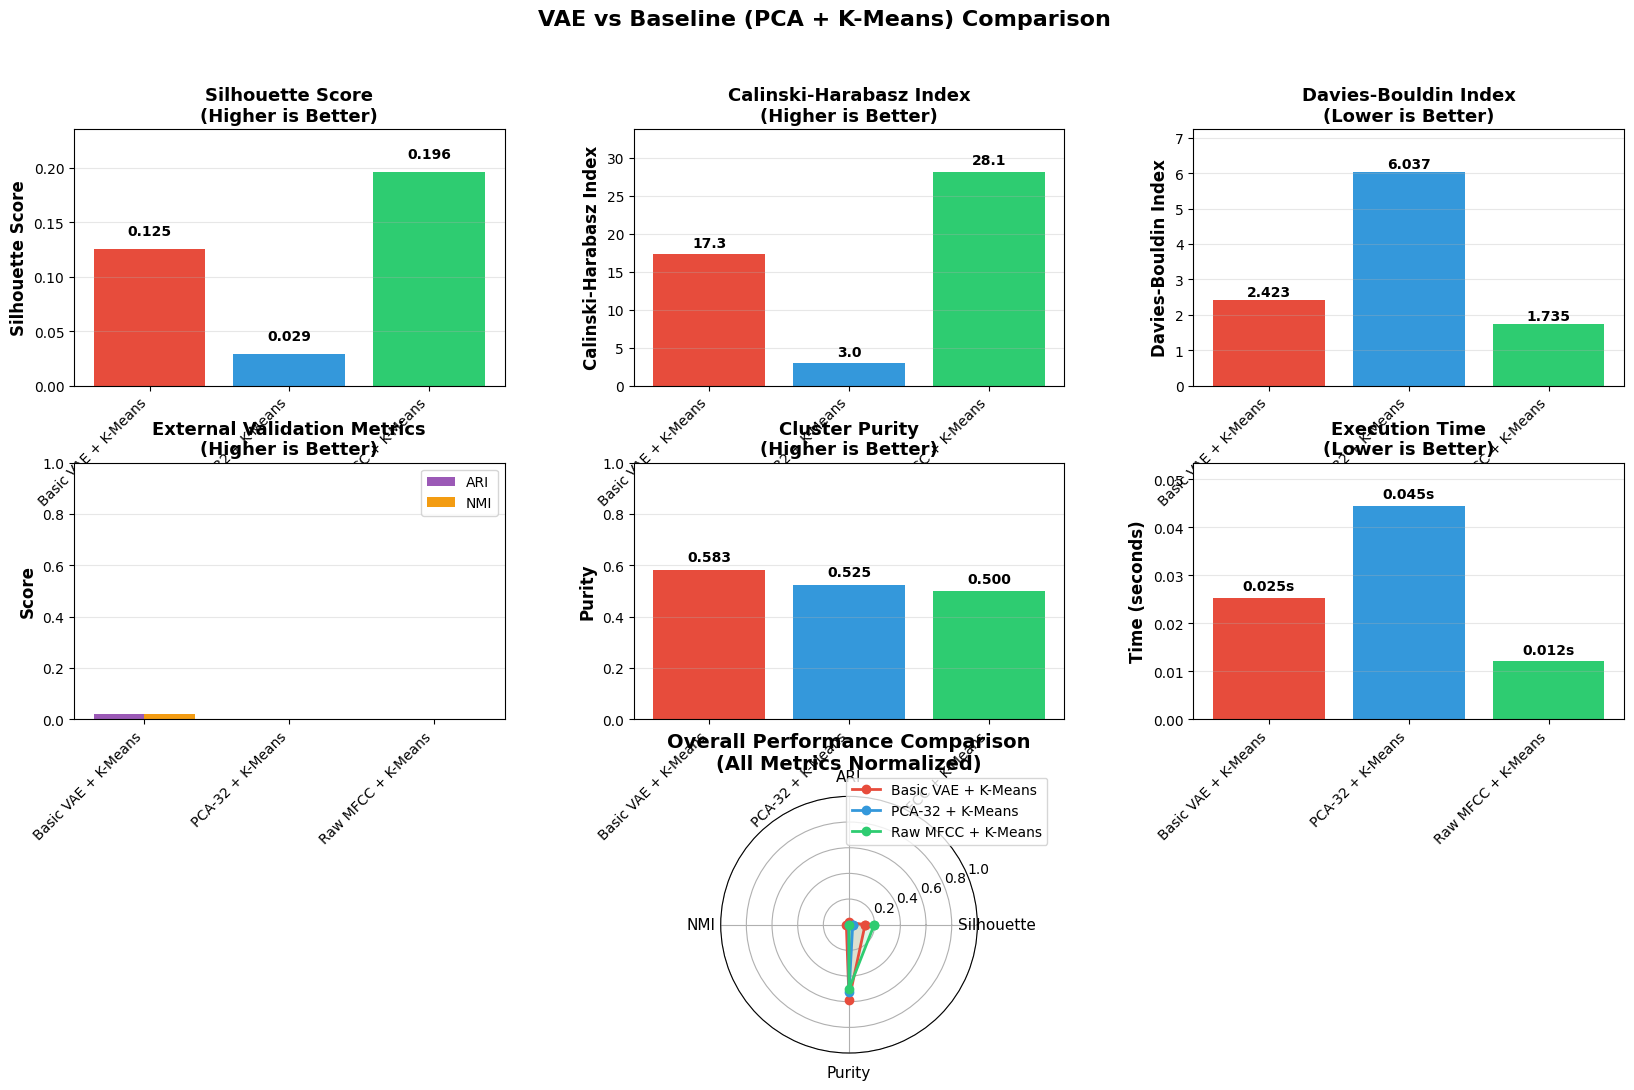


7. Detailed Analysis

📊 BEST PERFORMERS:
  • Best Silhouette Score: Raw MFCC + K-Means (0.1962)
  • Best Calinski-Harabasz: Raw MFCC + K-Means (28.15)
  • Best Davies-Bouldin: Raw MFCC + K-Means (1.7351)
  • Best ARI: Basic VAE + K-Means (0.0198)
  • Best Purity: Basic VAE + K-Means (0.5833)
  • Fastest: Raw MFCC + K-Means (0.012s)

📈 IMPROVEMENT ANALYSIS:
  • VAE vs PCA Silhouette: +335.4%
  • VAE vs PCA Calinski-Harabasz: +475.6%
  • VAE vs PCA ARI: +438.7%

✓ COMPARISON COMPLETE!

Results saved to: /content/drive/MyDrive/clustering_results
  • vae_vs_baseline_comparison.csv
  • vae_vs_baseline_comparison.png


In [16]:
# ================================================================================
# COMPREHENSIVE COMPARISON: VAE vs BASELINE (PCA + K-MEANS)
# Metrics: Silhouette Score, Calinski-Harabasz Index, Davies-Bouldin, ARI, NMI
# ================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
import librosa
import os
import time

# Create output directory
output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

print("="*80)
print("VAE vs BASELINE COMPARISON")
print("="*80)

# ============================================================================
# STEP 1: LOAD VAE FEATURES
# ============================================================================
print("\n1. Loading VAE features...")

# Try to load VAE features
vae_loaded = False
vae_type = ""

try:
    vae_df = pd.read_csv('/content/audio_vae_features.csv')
    vae_type = "Basic VAE"
    vae_loaded = True
except:
    pass

if not vae_loaded:
    try:
        vae_df = pd.read_csv('/content/audio_conv_vae_features.csv')
        vae_type = "Convolutional VAE"
        vae_loaded = True
    except:
        pass

if not vae_loaded:
    try:
        vae_df = pd.read_csv('/content/audio_hybrid_vae_features.csv')
        vae_type = "Hybrid VAE"
        vae_loaded = True
    except:
        pass

if not vae_loaded:
    print("ERROR: No VAE features found! Please run VAE training first.")
    raise FileNotFoundError("VAE features not found")

print(f"  ✓ Loaded {vae_type}: {vae_df.shape}")

# Extract VAE features and labels
vae_feature_cols = [col for col in vae_df.columns if col.startswith('feature_')]
X_vae = vae_df[vae_feature_cols].values
y_true = vae_df['language'].map({'bangla': 0, 'english': 1}).values

print(f"  VAE features shape: {X_vae.shape}")
print(f"  Labels: Bangla={np.sum(y_true==0)}, English={np.sum(y_true==1)}")

# ============================================================================
# STEP 2: EXTRACT BASELINE FEATURES (Raw MFCC)
# ============================================================================
print("\n2. Extracting baseline features (MFCC)...")

dataset_root = os.path.join(extract_to, 'MyDataset')
audio_root = os.path.join(dataset_root, 'audio')

# Get audio files (same ones used for VAE)
audio_files = []
baseline_labels = []

for lang_folder in ['bangla', 'english']:
    lang_path = os.path.join(audio_root, lang_folder)

    if not os.path.exists(lang_path):
        print(f"  Warning: {lang_path} not found")
        continue

    files = [f for f in os.listdir(lang_path) if f.endswith(('.mp3', '.wav', '.flac'))]

    for file in files[:len(vae_df)//2]:  # Match VAE dataset size
        full_path = os.path.join(lang_path, file)
        audio_files.append(full_path)
        baseline_labels.append(0 if lang_folder == 'bangla' else 1)

print(f"  Processing {len(audio_files)} audio files...")

# Extract MFCC features
mfcc_features = []
for i, audio_path in enumerate(audio_files):
    try:
        y, sr = librosa.load(audio_path, duration=3.0, sr=22050)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        # Additional features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y))

        # Combine: 20 MFCC means + 20 MFCC stds + 3 spectral = 43 features
        features = np.concatenate([mfcc_mean, mfcc_std,
                                   [spectral_centroid, spectral_rolloff, zero_crossing]])

        mfcc_features.append(features)

        if (i + 1) % 50 == 0:
            print(f"    Processed {i+1}/{len(audio_files)} files")
    except Exception as e:
        print(f"    Error processing {audio_path}: {e}")
        mfcc_features.append(np.zeros(43))

X_baseline = np.array(mfcc_features)
print(f"  ✓ Baseline features shape: {X_baseline.shape}")

# ============================================================================
# STEP 3: APPLY PCA TO BASELINE FEATURES
# ============================================================================
print("\n3. Applying PCA to baseline features...")

# Standardize baseline features
scaler_baseline = StandardScaler()
X_baseline_scaled = scaler_baseline.fit_transform(X_baseline)

# Apply PCA with different components
pca_results = {}
for n_components in [10, 20, 32]:
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_baseline_scaled)

    explained_var = np.sum(pca.explained_variance_ratio_)
    pca_results[n_components] = {
        'features': X_pca,
        'explained_variance': explained_var
    }
    print(f"  PCA-{n_components}: Explained variance = {explained_var:.3f}")

# Use PCA-32 as main baseline (same dimensionality as basic VAE)
X_pca_baseline = pca_results[32]['features']

# ============================================================================
# STEP 4: CLUSTERING WITH K-MEANS
# ============================================================================
print("\n" + "="*80)
print("4. Performing K-Means Clustering (K=2)")
print("="*80)

results = []

# Method 1: VAE + K-Means
print("\n[1/3] VAE + K-Means...")
start_time = time.time()

scaler_vae = StandardScaler()
X_vae_scaled = scaler_vae.fit_transform(X_vae)

kmeans_vae = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_vae = kmeans_vae.fit_predict(X_vae_scaled)

time_vae = time.time() - start_time

# Calculate metrics for VAE
sil_vae = silhouette_score(X_vae_scaled, labels_vae)
ch_vae = calinski_harabasz_score(X_vae_scaled, labels_vae)
db_vae = davies_bouldin_score(X_vae_scaled, labels_vae)
ari_vae = adjusted_rand_score(y_true, labels_vae)
nmi_vae = normalized_mutual_info_score(y_true, labels_vae)

# Calculate purity
cm_vae = confusion_matrix(y_true, labels_vae)
purity_vae = np.sum(np.amax(cm_vae, axis=0)) / np.sum(cm_vae)

results.append({
    'Method': f'{vae_type} + K-Means',
    'Silhouette': sil_vae,
    'Calinski-Harabasz': ch_vae,
    'Davies-Bouldin': db_vae,
    'ARI': ari_vae,
    'NMI': nmi_vae,
    'Purity': purity_vae,
    'Time (s)': time_vae,
    'N_Features': X_vae.shape[1]
})

print(f"  ✓ Silhouette: {sil_vae:.4f}")
print(f"  ✓ Calinski-Harabasz: {ch_vae:.2f}")
print(f"  ✓ Davies-Bouldin: {db_vae:.4f}")
print(f"  ✓ ARI: {ari_vae:.4f}")
print(f"  ✓ Purity: {purity_vae:.4f}")
print(f"  ✓ Time: {time_vae:.3f}s")

# Method 2: PCA-32 + K-Means (Main Baseline)
print("\n[2/3] PCA-32 + K-Means...")
start_time = time.time()

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca_baseline)

kmeans_pca = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca_scaled)

time_pca = time.time() - start_time

sil_pca = silhouette_score(X_pca_scaled, labels_pca)
ch_pca = calinski_harabasz_score(X_pca_scaled, labels_pca)
db_pca = davies_bouldin_score(X_pca_scaled, labels_pca)
ari_pca = adjusted_rand_score(y_true, labels_pca)
nmi_pca = normalized_mutual_info_score(y_true, labels_pca)

cm_pca = confusion_matrix(y_true, labels_pca)
purity_pca = np.sum(np.amax(cm_pca, axis=0)) / np.sum(cm_pca)

results.append({
    'Method': 'PCA-32 + K-Means',
    'Silhouette': sil_pca,
    'Calinski-Harabasz': ch_pca,
    'Davies-Bouldin': db_pca,
    'ARI': ari_pca,
    'NMI': nmi_pca,
    'Purity': purity_pca,
    'Time (s)': time_pca,
    'N_Features': 32
})

print(f"  ✓ Silhouette: {sil_pca:.4f}")
print(f"  ✓ Calinski-Harabasz: {ch_pca:.2f}")
print(f"  ✓ Davies-Bouldin: {db_pca:.4f}")
print(f"  ✓ ARI: {ari_pca:.4f}")
print(f"  ✓ Purity: {purity_pca:.4f}")
print(f"  ✓ Time: {time_pca:.3f}s")

# Method 3: Raw MFCC + K-Means (No dimensionality reduction)
print("\n[3/3] Raw MFCC + K-Means...")
start_time = time.time()

kmeans_raw = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_raw = kmeans_raw.fit_predict(X_baseline_scaled)

time_raw = time.time() - start_time

sil_raw = silhouette_score(X_baseline_scaled, labels_raw)
ch_raw = calinski_harabasz_score(X_baseline_scaled, labels_raw)
db_raw = davies_bouldin_score(X_baseline_scaled, labels_raw)
ari_raw = adjusted_rand_score(y_true, labels_raw)
nmi_raw = normalized_mutual_info_score(y_true, labels_raw)

cm_raw = confusion_matrix(y_true, labels_raw)
purity_raw = np.sum(np.amax(cm_raw, axis=0)) / np.sum(cm_raw)

results.append({
    'Method': 'Raw MFCC + K-Means',
    'Silhouette': sil_raw,
    'Calinski-Harabasz': ch_raw,
    'Davies-Bouldin': db_raw,
    'ARI': ari_raw,
    'NMI': nmi_raw,
    'Purity': purity_raw,
    'Time (s)': time_raw,
    'N_Features': 43
})

print(f"  ✓ Silhouette: {sil_raw:.4f}")
print(f"  ✓ Calinski-Harabasz: {ch_raw:.2f}")
print(f"  ✓ Davies-Bouldin: {db_raw:.4f}")
print(f"  ✓ ARI: {ari_raw:.4f}")
print(f"  ✓ Purity: {purity_raw:.4f}")
print(f"  ✓ Time: {time_raw:.3f}s")

# ============================================================================
# STEP 5: CREATE COMPARISON DATAFRAME
# ============================================================================
print("\n" + "="*80)
print("5. Results Summary")
print("="*80)

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

# Save results
results_path = os.path.join(output_dir, 'vae_vs_baseline_comparison.csv')
results_df.to_csv(results_path, index=False)
print(f"\n✓ Saved results: {results_path}")

# ============================================================================
# STEP 6: VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("6. Creating Visualizations")
print("="*80)

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

methods = results_df['Method'].tolist()
colors_method = ['#e74c3c', '#3498db', '#2ecc71']

# ===== Plot 1: Silhouette Score Comparison =====
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(range(len(methods)), results_df['Silhouette'], color=colors_method)
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_title('Silhouette Score\n(Higher is Better)', fontsize=13, fontweight='bold')
ax1.set_ylim([0, max(results_df['Silhouette']) * 1.2])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, results_df['Silhouette'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# ===== Plot 2: Calinski-Harabasz Index =====
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(range(len(methods)), results_df['Calinski-Harabasz'], color=colors_method)
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.set_ylabel('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
ax2.set_title('Calinski-Harabasz Index\n(Higher is Better)', fontsize=13, fontweight='bold')
ax2.set_ylim([0, max(results_df['Calinski-Harabasz']) * 1.2])
ax2.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars2, results_df['Calinski-Harabasz'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(results_df['Calinski-Harabasz']) * 0.02,
            f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# ===== Plot 3: Davies-Bouldin Index =====
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(range(len(methods)), results_df['Davies-Bouldin'], color=colors_method)
ax3.set_xticks(range(len(methods)))
ax3.set_xticklabels(methods, rotation=45, ha='right')
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
ax3.set_title('Davies-Bouldin Index\n(Lower is Better)', fontsize=13, fontweight='bold')
ax3.set_ylim([0, max(results_df['Davies-Bouldin']) * 1.2])
ax3.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars3, results_df['Davies-Bouldin'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# ===== Plot 4: ARI and NMI =====
ax4 = fig.add_subplot(gs[1, 0])
x = np.arange(len(methods))
width = 0.35

bars4a = ax4.bar(x - width/2, results_df['ARI'], width, label='ARI', color='#9b59b6')
bars4b = ax4.bar(x + width/2, results_df['NMI'], width, label='NMI', color='#f39c12')

ax4.set_xticks(x)
ax4.set_xticklabels(methods, rotation=45, ha='right')
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('External Validation Metrics\n(Higher is Better)', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1.0])

# ===== Plot 5: Purity =====
ax5 = fig.add_subplot(gs[1, 1])
bars5 = ax5.bar(range(len(methods)), results_df['Purity'], color=colors_method)
ax5.set_xticks(range(len(methods)))
ax5.set_xticklabels(methods, rotation=45, ha='right')
ax5.set_ylabel('Purity', fontsize=12, fontweight='bold')
ax5.set_title('Cluster Purity\n(Higher is Better)', fontsize=13, fontweight='bold')
ax5.set_ylim([0, 1.0])
ax5.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars5, results_df['Purity'])):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# ===== Plot 6: Execution Time =====
ax6 = fig.add_subplot(gs[1, 2])
bars6 = ax6.bar(range(len(methods)), results_df['Time (s)'], color=colors_method)
ax6.set_xticks(range(len(methods)))
ax6.set_xticklabels(methods, rotation=45, ha='right')
ax6.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax6.set_title('Execution Time\n(Lower is Better)', fontsize=13, fontweight='bold')
ax6.set_ylim([0, max(results_df['Time (s)']) * 1.2])
ax6.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars6, results_df['Time (s)'])):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(results_df['Time (s)']) * 0.02,
            f'{val:.3f}s', ha='center', va='bottom', fontweight='bold')

# ===== Plot 7: Radar Chart =====
ax7 = fig.add_subplot(gs[2, :], projection='polar')

# Normalize metrics to [0, 1] for radar chart
metrics_for_radar = ['Silhouette', 'ARI', 'NMI', 'Purity']
angles = np.linspace(0, 2*np.pi, len(metrics_for_radar), endpoint=False).tolist()
angles += angles[:1]

for i, method in enumerate(methods):
    values = results_df.loc[i, metrics_for_radar].tolist()
    values += values[:1]
    ax7.plot(angles, values, 'o-', linewidth=2, label=method, color=colors_method[i])
    ax7.fill(angles, values, alpha=0.15, color=colors_method[i])

ax7.set_xticks(angles[:-1])
ax7.set_xticklabels(metrics_for_radar, fontsize=11)
ax7.set_ylim(0, 1)
ax7.set_title('Overall Performance Comparison\n(All Metrics Normalized)',
              fontsize=14, fontweight='bold', pad=20)
ax7.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax7.grid(True)

plt.suptitle('VAE vs Baseline (PCA + K-Means) Comparison',
             fontsize=16, fontweight='bold', y=0.98)

# Save figure
save_path = os.path.join(output_dir, 'vae_vs_baseline_comparison.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved visualization: {save_path}")
plt.show()

# ============================================================================
# STEP 7: DETAILED ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("7. Detailed Analysis")
print("="*80)

print("\n📊 BEST PERFORMERS:")
print(f"  • Best Silhouette Score: {results_df.loc[results_df['Silhouette'].idxmax(), 'Method']} "
      f"({results_df['Silhouette'].max():.4f})")
print(f"  • Best Calinski-Harabasz: {results_df.loc[results_df['Calinski-Harabasz'].idxmax(), 'Method']} "
      f"({results_df['Calinski-Harabasz'].max():.2f})")
print(f"  • Best Davies-Bouldin: {results_df.loc[results_df['Davies-Bouldin'].idxmin(), 'Method']} "
      f"({results_df['Davies-Bouldin'].min():.4f})")
print(f"  • Best ARI: {results_df.loc[results_df['ARI'].idxmax(), 'Method']} "
      f"({results_df['ARI'].max():.4f})")
print(f"  • Best Purity: {results_df.loc[results_df['Purity'].idxmax(), 'Method']} "
      f"({results_df['Purity'].max():.4f})")
print(f"  • Fastest: {results_df.loc[results_df['Time (s)'].idxmin(), 'Method']} "
      f"({results_df['Time (s)'].min():.3f}s)")

print("\n📈 IMPROVEMENT ANALYSIS:")
# Compare VAE vs PCA
vae_idx = 0
pca_idx = 1

sil_improvement = ((results_df.loc[vae_idx, 'Silhouette'] - results_df.loc[pca_idx, 'Silhouette'])
                   / results_df.loc[pca_idx, 'Silhouette'] * 100)
ch_improvement = ((results_df.loc[vae_idx, 'Calinski-Harabasz'] - results_df.loc[pca_idx, 'Calinski-Harabasz'])
                  / results_df.loc[pca_idx, 'Calinski-Harabasz'] * 100)
ari_improvement = ((results_df.loc[vae_idx, 'ARI'] - results_df.loc[pca_idx, 'ARI'])
                   / abs(results_df.loc[pca_idx, 'ARI']) * 100 if results_df.loc[pca_idx, 'ARI'] != 0 else 0)

print(f"  • VAE vs PCA Silhouette: {sil_improvement:+.1f}%")
print(f"  • VAE vs PCA Calinski-Harabasz: {ch_improvement:+.1f}%")
print(f"  • VAE vs PCA ARI: {ari_improvement:+.1f}%")

print("\n" + "="*80)
print("✓ COMPARISON COMPLETE!")
print("="*80)
print(f"\nResults saved to: {output_dir}")
print(f"  • vae_vs_baseline_comparison.csv")
print(f"  • vae_vs_baseline_comparison.png")

## Medium

ENHANCED CONVOLUTIONAL VAE FOR AUDIO FEATURES

Configuration:
  Device: cpu
  Feature Type: melspectrogram
  Latent Dimension: 64
  Input Shape: (1, 128, 128)

LOADING AUDIO DATA
✓ Dataset root: /content/extracted_data/MyDataset
✓ Audio folder: /content/extracted_data/MyDataset/audio
  ✓ Bangla: 60 files found, using first 100
  ✓ English: 60 files found, using first 100

Total audio files: 120
  Bangla: 60
  English: 60

DataLoader created:
  Batch size: 16
  Number of batches: 8

INITIALIZING MODEL

Model: Enhanced Convolutional VAE
  Total parameters: 10,296,385
  Trainable parameters: 10,296,385
  Device: cpu

TRAINING
Epoch [  1/50] Loss: 9688670.3020 | Recon: 1971.0560 | KL: 9686699.3463
Epoch [  5/50] Loss: 5564.2317 | Recon: 958.2702 | KL: 4605.9616
Epoch [ 10/50] Loss: 977.0790 | Recon: 700.1271 | KL: 276.9519
Epoch [ 15/50] Loss: 1006.0062 | Recon: 747.7507 | KL: 258.2554
Epoch [ 20/50] Loss: 851.9013 | Recon: 608.0688 | KL: 243.8325
Epoch [ 25/50] Loss: 739.5465 | Recon: 513

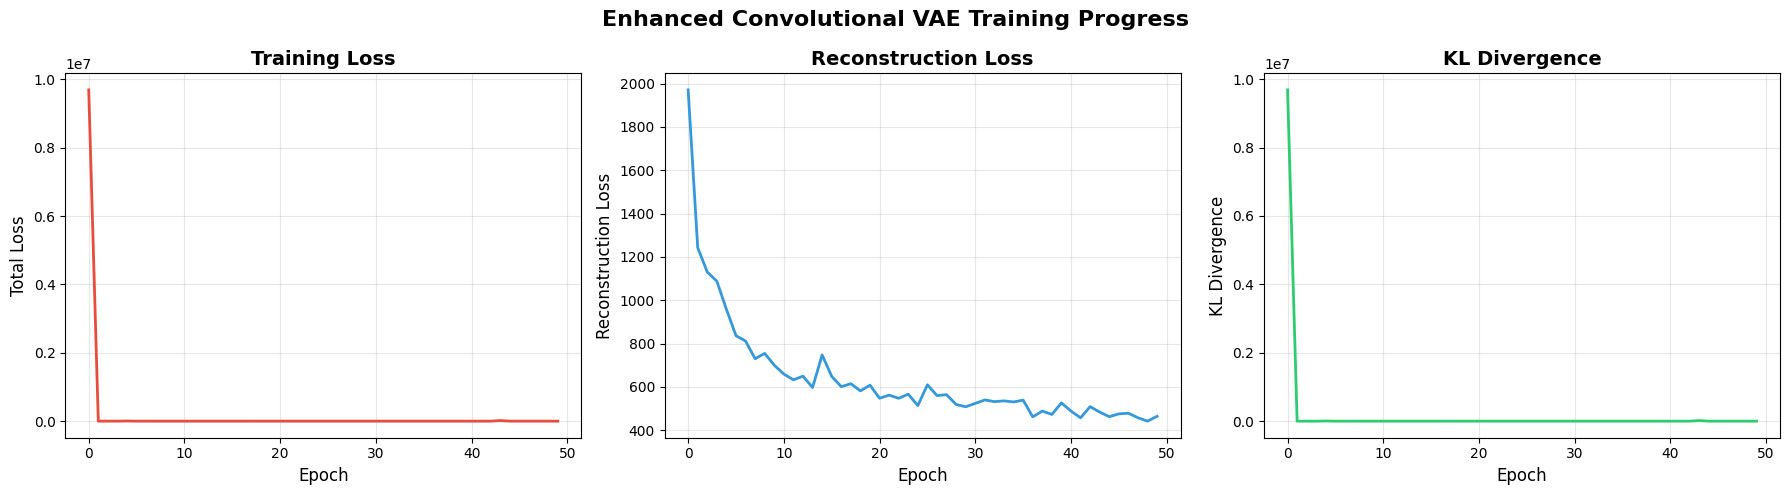


EXTRACTING LATENT FEATURES
✓ Extracted latent features: (120, 64)
✓ Saved features: /content/audio_enhanced_conv_vae_features.csv
  Shape: (120, 66)

Preview:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.292885  -0.751525  -1.620394   0.354799  -1.281623  -0.588301   
1   1.657473  -0.806083   0.576613  -1.465463   0.120207   0.907505   
2   0.426712  -0.415334  -1.599361   0.213834  -1.246289  -0.535534   
3   0.247169  -0.405042  -1.732889   0.477417  -1.300642  -0.438055   
4  -0.296713   0.080376  -1.345556  -0.902293  -2.139459   0.293839   

   feature_6  feature_7  feature_8  feature_9  ...  feature_56  feature_57  \
0   0.812768   1.081264  -0.297539  -0.823923  ...   -1.238069    0.690355   
1   0.384401  -0.772536   1.456235  -1.410293  ...    0.268698   -1.823163   
2  -0.430430   0.860551  -0.595497  -1.089094  ...   -1.161260    0.399465   
3   0.290896   1.231368  -0.531266  -0.806852  ...   -1.166409    0.765242   
4   0.164159   3.530451

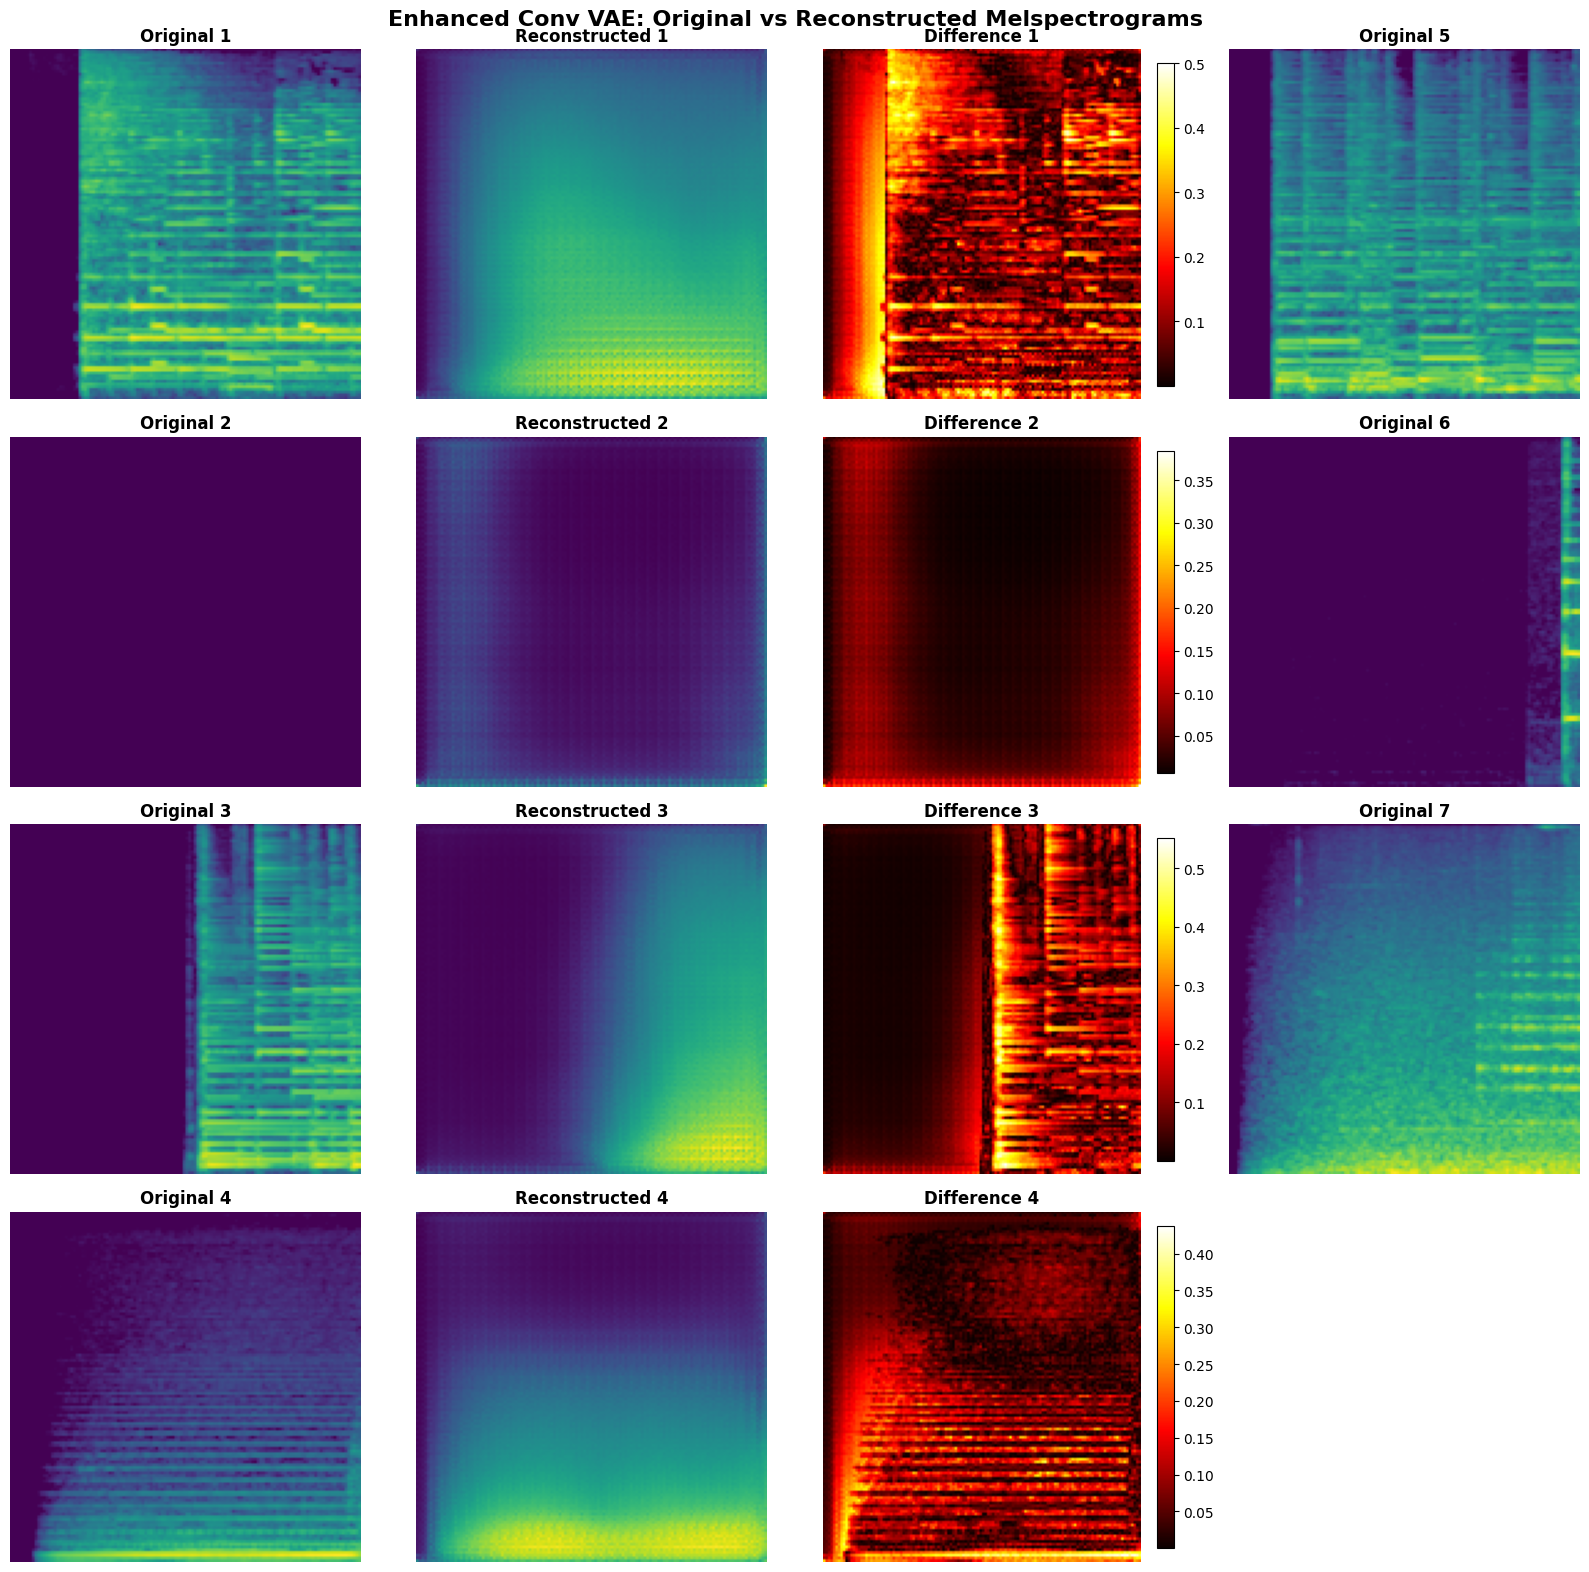


✓ ENHANCED CONVOLUTIONAL VAE COMPLETE!

Files saved:
  • audio_enhanced_conv_vae_features.csv
  • enhanced_conv_vae_training.png
  • enhanced_conv_vae_reconstructions.png

All files saved to: /content/drive/MyDrive/clustering_results


In [17]:
# ================================================================================
# ENHANCED CONVOLUTIONAL VAE FOR AUDIO SPECTROGRAMS
# Advanced architecture with skip connections, batch normalization, and dropout
# Supports both Mel Spectrograms and MFCC features
# ================================================================================

import pandas as pd
import numpy as np
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ENHANCED CONVOLUTIONAL VAE FOR AUDIO FEATURES")
print("="*80)

# ============================================================================
# STEP 1: SETUP AND CONFIGURATION
# ============================================================================

# Configuration
class Config:
    # Data parameters
    SAMPLE_RATE = 22050
    DURATION = 3.0  # seconds
    N_MELS = 128
    N_FFT = 2048
    HOP_LENGTH = 512

    # Model parameters
    LATENT_DIM = 64
    BATCH_SIZE = 16
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-3
    BETA = 1.0  # KL divergence weight

    # Training parameters
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

    # Feature type: 'melspectrogram' or 'mfcc'
    FEATURE_TYPE = 'melspectrogram'  # Change to 'mfcc' if desired

config = Config()

print(f"\nConfiguration:")
print(f"  Device: {config.DEVICE}")
print(f"  Feature Type: {config.FEATURE_TYPE}")
print(f"  Latent Dimension: {config.LATENT_DIM}")
print(f"  Input Shape: (1, {config.N_MELS}, 128)")

# ============================================================================
# STEP 2: ENHANCED CONVOLUTIONAL VAE MODEL
# ============================================================================

class ResidualBlock(nn.Module):
    """Residual block with skip connection"""
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out


class EnhancedConvVAE(nn.Module):
    """
    Enhanced Convolutional VAE with:
    - Residual connections
    - Batch normalization
    - Dropout for regularization
    - Skip connections between encoder and decoder
    """
    def __init__(self, latent_dim=64, input_channels=1):
        super(EnhancedConvVAE, self).__init__()

        self.latent_dim = latent_dim

        # ========== ENCODER ==========
        # Input: (batch, 1, 128, 128)

        # Block 1: (1, 128, 128) -> (32, 64, 64)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.enc_res1 = ResidualBlock(32)

        # Block 2: (32, 64, 64) -> (64, 32, 32)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.enc_res2 = ResidualBlock(64)

        # Block 3: (64, 32, 32) -> (128, 16, 16)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.enc_res3 = ResidualBlock(128)

        # Block 4: (128, 16, 16) -> (256, 8, 8)
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.enc_res4 = ResidualBlock(256)

        # Block 5: (256, 8, 8) -> (512, 4, 4)
        self.enc_conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Flatten size: 512 * 4 * 4 = 8192
        self.flatten_size = 512 * 4 * 4

        # Latent space
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        # ========== DECODER ==========
        self.decoder_fc = nn.Linear(latent_dim, self.flatten_size)

        # Block 1: (512, 4, 4) -> (256, 8, 8)
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.dec_res1 = ResidualBlock(256)

        # Block 2: (256, 8, 8) -> (128, 16, 16)
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.dec_res2 = ResidualBlock(128)

        # Block 3: (128, 16, 16) -> (64, 32, 32)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.dec_res3 = ResidualBlock(64)

        # Block 4: (64, 32, 32) -> (32, 64, 64)
        self.dec_conv4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        self.dec_res4 = ResidualBlock(32)

        # Block 5: (32, 64, 64) -> (1, 128, 128)
        self.dec_conv5 = nn.Sequential(
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x):
        # Encoder with skip connections
        h1 = self.enc_conv1(x)
        h1 = self.enc_res1(h1)

        h2 = self.enc_conv2(h1)
        h2 = self.enc_res2(h2)

        h3 = self.enc_conv3(h2)
        h3 = self.enc_res3(h3)

        h4 = self.enc_conv4(h3)
        h4 = self.enc_res4(h4)

        h5 = self.enc_conv5(h4)

        # Flatten
        h = h5.view(h5.size(0), -1)

        # Latent parameters
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 512, 4, 4)

        h = self.dec_conv1(h)
        h = self.dec_res1(h)

        h = self.dec_conv2(h)
        h = self.dec_res2(h)

        h = self.dec_conv3(h)
        h = self.dec_res3(h)

        h = self.dec_conv4(h)
        h = self.dec_res4(h)

        h = self.dec_conv5(h)

        return h

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


# Loss function with beta parameter
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + beta * KL divergence
    """
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kld, recon_loss, kld


# ============================================================================
# STEP 3: ENHANCED AUDIO DATASET
# ============================================================================

class AudioSpectrogramDataset(Dataset):
    """
    Dataset for loading audio and converting to spectrograms/MFCC
    """
    def __init__(self, audio_paths, labels, config, feature_type='melspectrogram'):
        self.audio_paths = audio_paths
        self.labels = labels
        self.config = config
        self.feature_type = feature_type
        self.target_shape = (128, 128)

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]

        try:
            # Load audio
            y, sr = librosa.load(audio_path,
                                duration=self.config.DURATION,
                                sr=self.config.SAMPLE_RATE)

            # Generate features based on type
            if self.feature_type == 'melspectrogram':
                # Mel Spectrogram
                mel_spec = librosa.feature.melspectrogram(
                    y=y,
                    sr=sr,
                    n_mels=self.config.N_MELS,
                    n_fft=self.config.N_FFT,
                    hop_length=self.config.HOP_LENGTH
                )
                # Convert to dB scale
                feature = librosa.power_to_db(mel_spec, ref=np.max)

            elif self.feature_type == 'mfcc':
                # MFCC
                mfcc = librosa.feature.mfcc(
                    y=y,
                    sr=sr,
                    n_mfcc=self.config.N_MELS
                )
                feature = mfcc

            # Normalize to [0, 1]
            feature = (feature - feature.min()) / (feature.max() - feature.min() + 1e-8)

            # Resize/pad to target shape
            if feature.shape[1] < self.target_shape[1]:
                pad_width = self.target_shape[1] - feature.shape[1]
                feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
            else:
                feature = feature[:, :self.target_shape[1]]

            # Ensure correct height
            if feature.shape[0] < self.target_shape[0]:
                pad_height = self.target_shape[0] - feature.shape[0]
                feature = np.pad(feature, ((0, pad_height), (0, 0)), mode='constant')
            else:
                feature = feature[:self.target_shape[0], :]

            # Add channel dimension: (1, H, W)
            feature = feature.reshape(1, *feature.shape)

            return torch.FloatTensor(feature), self.labels[idx]

        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            # Return zero tensor on error
            return torch.zeros(1, *self.target_shape), self.labels[idx]


# ============================================================================
# STEP 4: DATA LOADING
# ============================================================================
print("\n" + "="*80)
print("LOADING AUDIO DATA")
print("="*80)

# Find dataset
dataset_root = os.path.join(extract_to, 'MyDataset')
audio_root = os.path.join(dataset_root, 'audio')

# Load metadata
metadata_path = None
for file in os.listdir(dataset_root):
    if file.endswith('.csv') or file.endswith('.xlsx'):
        metadata_path = os.path.join(dataset_root, file)
        break

if metadata_path and metadata_path.endswith('.xlsx'):
    metadata = pd.read_excel(metadata_path)
else:
    metadata = pd.read_csv(metadata_path) if metadata_path else None

print(f"✓ Dataset root: {dataset_root}")
print(f"✓ Audio folder: {audio_root}")

# Collect audio files
audio_files = []
labels = []
filenames = []

for lang_folder in ['bangla', 'english']:
    lang_path = os.path.join(audio_root, lang_folder)

    if not os.path.exists(lang_path):
        print(f"Warning: {lang_path} not found")
        continue

    files = [f for f in os.listdir(lang_path) if f.endswith(('.mp3', '.wav', '.flac'))]

    # Use up to 100 files per language
    for file in files[:100]:
        full_path = os.path.join(lang_path, file)
        audio_files.append(full_path)
        labels.append(0 if lang_folder == 'bangla' else 1)
        filenames.append(f"{lang_folder}/{file}")

    print(f"  ✓ {lang_folder.capitalize()}: {len(files)} files found, using first 100")

print(f"\nTotal audio files: {len(audio_files)}")
print(f"  Bangla: {sum([1 for l in labels if l == 0])}")
print(f"  English: {sum([1 for l in labels if l == 1])}")

# Create dataset and dataloader
dataset = AudioSpectrogramDataset(audio_files, labels, config,
                                  feature_type=config.FEATURE_TYPE)
train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True, num_workers=2)

print(f"\nDataLoader created:")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Number of batches: {len(train_loader)}")

# ============================================================================
# STEP 5: MODEL INITIALIZATION
# ============================================================================
print("\n" + "="*80)
print("INITIALIZING MODEL")
print("="*80)

model = EnhancedConvVAE(latent_dim=config.LATENT_DIM).to(config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel: Enhanced Convolutional VAE")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {config.DEVICE}")

# ============================================================================
# STEP 6: TRAINING
# ============================================================================
print("\n" + "="*80)
print("TRAINING")
print("="*80)

train_losses = []
recon_losses = []
kl_losses = []

model.train()

for epoch in range(config.NUM_EPOCHS):
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(config.DEVICE)

        # Forward pass
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss, recon_loss, kl_loss = vae_loss(recon, data, mu, logvar, beta=config.BETA)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()

    # Calculate average losses
    avg_loss = epoch_loss / len(train_loader.dataset)
    avg_recon = epoch_recon / len(train_loader.dataset)
    avg_kl = epoch_kl / len(train_loader.dataset)

    train_losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{config.NUM_EPOCHS}] "
              f"Loss: {avg_loss:.4f} | "
              f"Recon: {avg_recon:.4f} | "
              f"KL: {avg_kl:.4f}")

print("\n✓ Training complete!")

# ============================================================================
# STEP 7: VISUALIZATION OF TRAINING
# ============================================================================
print("\n" + "="*80)
print("CREATING TRAINING VISUALIZATIONS")
print("="*80)

output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Total loss
axes[0].plot(train_losses, linewidth=2, color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Total Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Reconstruction loss
axes[1].plot(recon_losses, linewidth=2, color='#3498db')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Reconstruction Loss', fontsize=12)
axes[1].set_title('Reconstruction Loss', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Plot 3: KL divergence
axes[2].plot(kl_losses, linewidth=2, color='#2ecc71')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('KL Divergence', fontsize=12)
axes[2].set_title('KL Divergence', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.suptitle('Enhanced Convolutional VAE Training Progress',
             fontsize=16, fontweight='bold')
plt.tight_layout()

save_path = os.path.join(output_dir, 'enhanced_conv_vae_training.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved training plot: {save_path}")
plt.show()

# ============================================================================
# STEP 8: EXTRACT LATENT FEATURES
# ============================================================================
print("\n" + "="*80)
print("EXTRACTING LATENT FEATURES")
print("="*80)

model.eval()
latent_features = []
true_labels = []

with torch.no_grad():
    for data, label in dataset:
        data = data.unsqueeze(0).to(config.DEVICE)
        mu, _ = model.encode(data)
        latent_features.append(mu.cpu().numpy().flatten())
        true_labels.append(label)

latent_features = np.array(latent_features)

print(f"✓ Extracted latent features: {latent_features.shape}")

# Create dataframe
features_df = pd.DataFrame(
    latent_features,
    columns=[f'feature_{i}' for i in range(latent_features.shape[1])]
)

features_df['filename'] = filenames
features_df['language'] = ['bangla' if l == 0 else 'english' for l in true_labels]

# Save features
output_path = '/content/audio_enhanced_conv_vae_features.csv'
features_df.to_csv(output_path, index=False)
print(f"✓ Saved features: {output_path}")
print(f"  Shape: {features_df.shape}")
print("\nPreview:")
print(features_df.head())

# ============================================================================
# STEP 9: VISUALIZATION OF RECONSTRUCTIONS
# ============================================================================
print("\n" + "="*80)
print("VISUALIZING RECONSTRUCTIONS")
print("="*80)

model.eval()

# Get a batch of samples
sample_batch, sample_labels = next(iter(DataLoader(dataset, batch_size=8, shuffle=True)))
sample_batch = sample_batch.to(config.DEVICE)

with torch.no_grad():
    reconstructions, _, _ = model(sample_batch)

sample_batch = sample_batch.cpu().numpy()
reconstructions = reconstructions.cpu().numpy()

# Plot original vs reconstructed
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):
    # Original
    axes[i, 0].imshow(sample_batch[i, 0], aspect='auto', origin='lower', cmap='viridis')
    axes[i, 0].set_title(f'Original {i+1}', fontweight='bold')
    axes[i, 0].axis('off')

    # Reconstructed
    axes[i, 1].imshow(reconstructions[i, 0], aspect='auto', origin='lower', cmap='viridis')
    axes[i, 1].set_title(f'Reconstructed {i+1}', fontweight='bold')
    axes[i, 1].axis('off')

    # Difference
    diff = np.abs(sample_batch[i, 0] - reconstructions[i, 0])
    im = axes[i, 2].imshow(diff, aspect='auto', origin='lower', cmap='hot')
    axes[i, 2].set_title(f'Difference {i+1}', fontweight='bold')
    axes[i, 2].axis('off')
    plt.colorbar(im, ax=axes[i, 2], fraction=0.046)

    # Next original
    if i < 3:
        axes[i, 3].imshow(sample_batch[i+4, 0], aspect='auto', origin='lower', cmap='viridis')
        axes[i, 3].set_title(f'Original {i+5}', fontweight='bold')
        axes[i, 3].axis('off')
    else:
        axes[i, 3].axis('off')

plt.suptitle(f'Enhanced Conv VAE: Original vs Reconstructed {config.FEATURE_TYPE.capitalize()}s',
             fontsize=16, fontweight='bold')
plt.tight_layout()

save_path = os.path.join(output_dir, 'enhanced_conv_vae_reconstructions.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved reconstructions: {save_path}")
plt.show()

print("\n" + "="*80)
print("✓ ENHANCED CONVOLUTIONAL VAE COMPLETE!")
print("="*80)
print(f"\nFiles saved:")
print(f"  • audio_enhanced_conv_vae_features.csv")
print(f"  • enhanced_conv_vae_training.png")
print(f"  • enhanced_conv_vae_reconstructions.png")
print(f"\nAll files saved to: {output_dir}")

HYBRID VAE: AUDIO + LYRICS EMBEDDINGS

Installing sentence-transformers...
✓ Installation complete



Configuration:
  Device: cpu
  Audio Latent Dim: 32
  Text Latent Dim: 32
  Combined Latent Dim: 64

LOADING DATA
Loading metadata from: metadata.xlsx
✓ Metadata loaded: (120, 8)
  Columns: ['filenaming', 'language', 'song_title', 'singer', 'genre', 'language_id', 'release_year', 'lyrics']
  ✓ Bangla: 60 files, using first 100
  ✓ English: 60 files, using first 100

Total samples: 120
  Bangla: 60
  English: 60

Initializing text encoder...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Text encoder loaded: all-MiniLM-L6-v2

Creating hybrid dataset...
  Encoding lyrics...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

  ✓ Text embeddings shape: (120, 384)
✓ Dataset created
  Batches: 8

INITIALIZING HYBRID VAE

Model: Hybrid VAE
  Total parameters: 3,244,353
  Trainable parameters: 3,244,353
  Device: cpu

TRAINING
Epoch [  1/50] Loss: 1720.2083 | Audio Recon: 1480.3957 | Text Recon: 5.4007 | Audio KL: 237.0420 | Text KL: 0.0702
Epoch [  5/50] Loss: 602.3765 | Audio Recon: 414.9948 | Text Recon: 1.1384 | Audio KL: 186.8038 | Text KL: 0.0087
Epoch [ 10/50] Loss: 410.6069 | Audio Recon: 307.5889 | Text Recon: 0.8753 | Audio KL: 102.5774 | Text KL: 0.0030
Epoch [ 15/50] Loss: 361.8660 | Audio Recon: 287.4137 | Text Recon: 0.7990 | Audio KL: 74.0510 | Text KL: 0.0017
Epoch [ 20/50] Loss: 323.9604 | Audio Recon: 251.4582 | Text Recon: 0.7718 | Audio KL: 72.1148 | Text KL: 0.0014
Epoch [ 25/50] Loss: 315.4404 | Audio Recon: 242.3565 | Text Recon: 0.7634 | Audio KL: 72.7011 | Text KL: 0.0012
Epoch [ 30/50] Loss: 307.3805 | Audio Recon: 227.2170 | Text Recon: 0.7557 | Audio KL: 79.7847 | Text KL: 0.0009
Epo

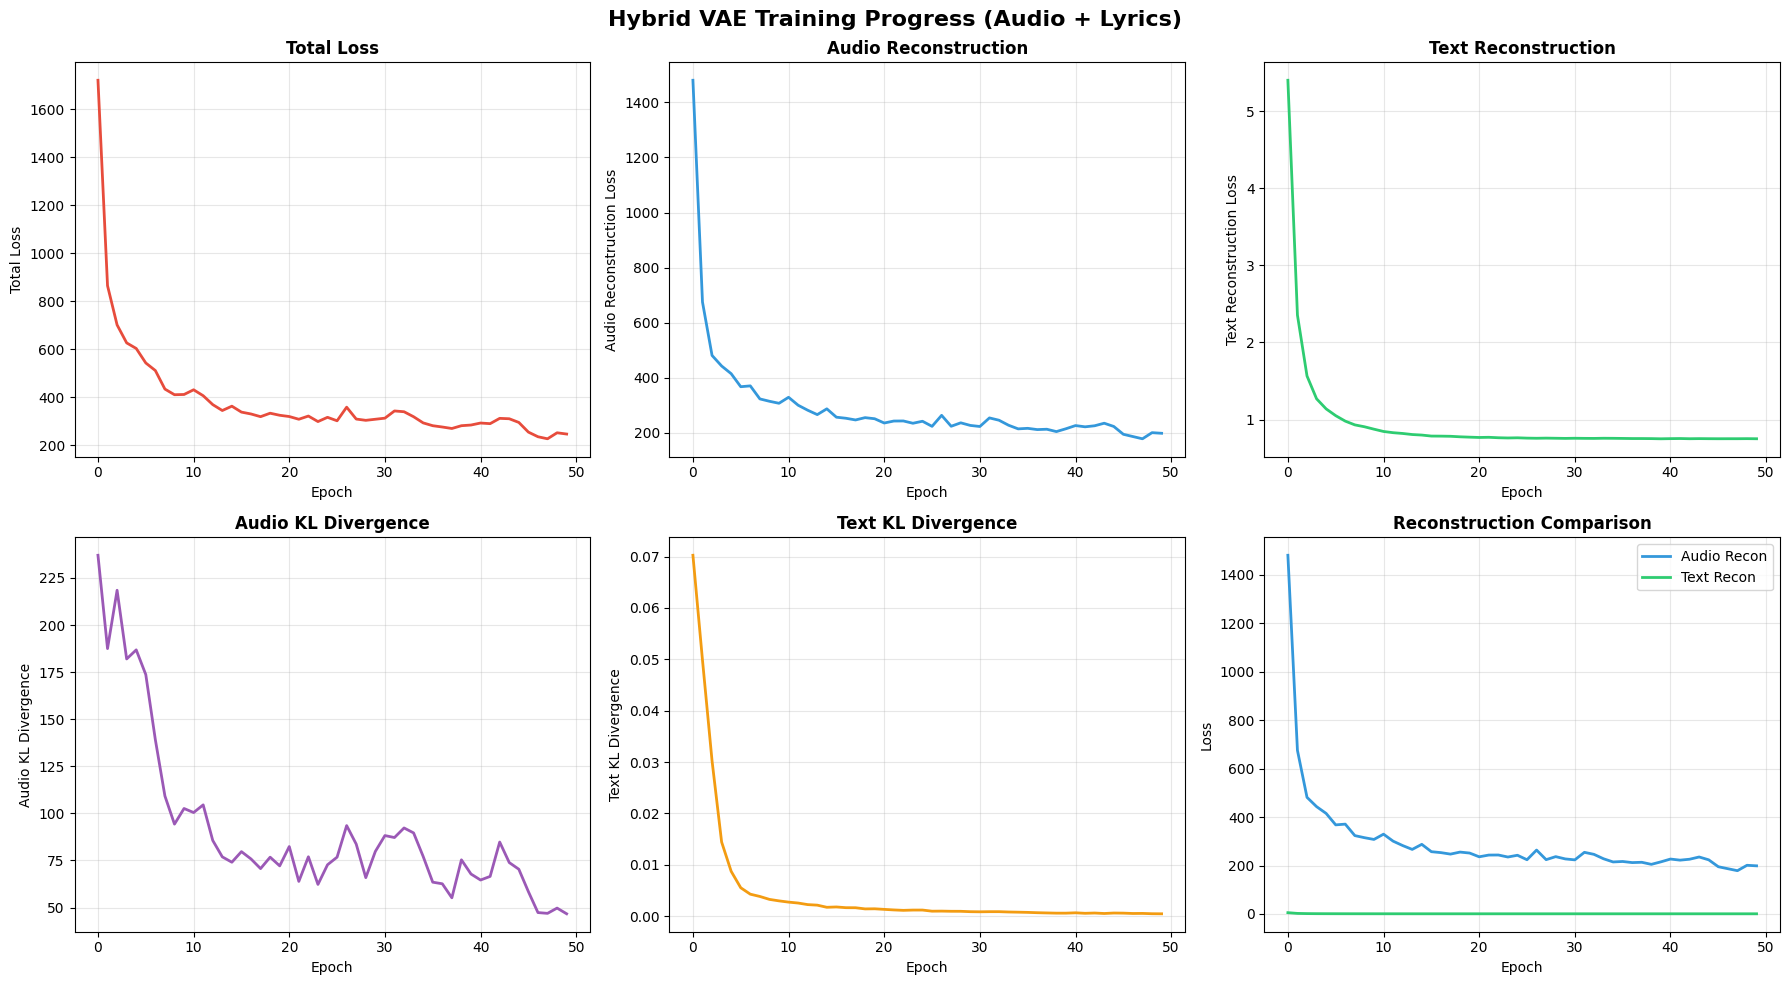



Files saved:
  • audio_hybrid_vae_features.csv (64-dim combined)
  • audio_hybrid_vae_audio_only.csv (32-dim)
  • audio_hybrid_vae_text_only.csv (32-dim)
  • hybrid_vae_training.png

All files in: /content/drive/MyDrive/clustering_results


In [19]:
# ================================================================================
# HYBRID VAE: AUDIO SPECTROGRAMS + LYRICS EMBEDDINGS
# Multi-modal learning combining acoustic and semantic information
# ================================================================================

import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("HYBRID VAE: AUDIO + LYRICS EMBEDDINGS")
print("="*80)

# Install sentence-transformers
print("\nInstalling sentence-transformers...")
subprocess.run(['pip', 'install', 'sentence-transformers', '--break-system-packages'],
               capture_output=True, check=True)
print("✓ Installation complete")

from sentence_transformers import SentenceTransformer

# ============================================================================
# STEP 1: CONFIGURATION
# ============================================================================

class HybridConfig:
    # Audio parameters
    SAMPLE_RATE = 22050
    DURATION = 3.0
    N_MELS = 128
    N_FFT = 2048
    HOP_LENGTH = 512

    # Model parameters
    AUDIO_LATENT_DIM = 32
    TEXT_LATENT_DIM = 32
    COMBINED_LATENT_DIM = 64  # Total latent dimension

    # Training parameters
    BATCH_SIZE = 16
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-3
    BETA = 1.0

    # Loss weights
    AUDIO_RECON_WEIGHT = 1.0
    TEXT_RECON_WEIGHT = 0.5

    # Device
    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

    # Text encoder model
    TEXT_MODEL = 'all-MiniLM-L6-v2'  # 384-dim embeddings

config = HybridConfig()

print(f"\nConfiguration:")
print(f"  Device: {config.DEVICE}")
print(f"  Audio Latent Dim: {config.AUDIO_LATENT_DIM}")
print(f"  Text Latent Dim: {config.TEXT_LATENT_DIM}")
print(f"  Combined Latent Dim: {config.COMBINED_LATENT_DIM}")

# ============================================================================
# STEP 2: HYBRID VAE MODEL
# ============================================================================

class HybridVAE(nn.Module):
    """
    Hybrid VAE combining:
    1. Audio branch (Convolutional) - processes mel spectrograms
    2. Text branch (Fully connected) - processes lyrics embeddings
    3. Shared latent space
    """
    def __init__(self, config):
        super(HybridVAE, self).__init__()

        self.config = config
        self.audio_latent_dim = config.AUDIO_LATENT_DIM
        self.text_latent_dim = config.TEXT_LATENT_DIM
        self.combined_latent_dim = config.COMBINED_LATENT_DIM

        # Text embedding dimension (from sentence-transformers)
        self.text_input_dim = 384

        # ========== AUDIO ENCODER (Convolutional) ==========
        self.audio_encoder = nn.Sequential(
            # Input: (1, 128, 128)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.audio_flatten_size = 256 * 8 * 8
        self.audio_fc_mu = nn.Linear(self.audio_flatten_size, self.audio_latent_dim)
        self.audio_fc_logvar = nn.Linear(self.audio_flatten_size, self.audio_latent_dim)

        # ========== TEXT ENCODER (Fully Connected) ==========
        self.text_encoder = nn.Sequential(
            nn.Linear(self.text_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.text_fc_mu = nn.Linear(128, self.text_latent_dim)
        self.text_fc_logvar = nn.Linear(128, self.text_latent_dim)

        # ========== AUDIO DECODER ==========
        self.audio_decoder_fc = nn.Linear(self.audio_latent_dim, self.audio_flatten_size)

        self.audio_decoder = nn.Sequential(
            # Input: (256, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # (1, 128, 128)
            nn.Sigmoid()
        )

        # ========== TEXT DECODER ==========
        self.text_decoder = nn.Sequential(
            nn.Linear(self.text_latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, self.text_input_dim),
        )

    def encode_audio(self, x):
        h = self.audio_encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.audio_fc_mu(h)
        logvar = self.audio_fc_logvar(h)
        return mu, logvar

    def encode_text(self, x):
        h = self.text_encoder(x)
        mu = self.text_fc_mu(h)
        logvar = self.text_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_audio(self, z):
        h = self.audio_decoder_fc(z)
        h = h.view(h.size(0), 256, 8, 8)
        return self.audio_decoder(h)

    def decode_text(self, z):
        return self.text_decoder(z)

    def forward(self, audio, text):
        # Encode both modalities
        audio_mu, audio_logvar = self.encode_audio(audio)
        text_mu, text_logvar = self.encode_text(text)

        # Sample from latent distributions
        audio_z = self.reparameterize(audio_mu, audio_logvar)
        text_z = self.reparameterize(text_mu, text_logvar)

        # Combine latent representations
        combined_z = torch.cat([audio_z, text_z], dim=1)

        # Decode
        audio_recon = self.decode_audio(audio_z)
        text_recon = self.decode_text(text_z)

        return (audio_recon, text_recon,
                audio_mu, audio_logvar,
                text_mu, text_logvar,
                combined_z)


def hybrid_vae_loss(audio_recon, audio, text_recon, text,
                    audio_mu, audio_logvar, text_mu, text_logvar,
                    audio_weight=1.0, text_weight=0.5, beta=1.0):
    """
    Multi-modal VAE loss
    """
    # Audio reconstruction loss
    audio_recon_loss = nn.functional.mse_loss(audio_recon, audio, reduction='sum')

    # Text reconstruction loss (cosine similarity)
    text_recon_loss = nn.functional.mse_loss(text_recon, text, reduction='sum')

    # KL divergence for audio
    audio_kld = -0.5 * torch.sum(1 + audio_logvar - audio_mu.pow(2) - audio_logvar.exp())

    # KL divergence for text
    text_kld = -0.5 * torch.sum(1 + text_logvar - text_mu.pow(2) - text_logvar.exp())

    # Combined loss
    total_loss = (audio_weight * audio_recon_loss +
                  text_weight * text_recon_loss +
                  beta * (audio_kld + text_kld))

    return total_loss, audio_recon_loss, text_recon_loss, audio_kld, text_kld


# ============================================================================
# STEP 3: HYBRID DATASET
# ============================================================================

class HybridAudioTextDataset(Dataset):
    """
    Dataset that loads both audio spectrograms and lyrics embeddings
    """
    def __init__(self, audio_paths, lyrics, labels, config, text_encoder):
        self.audio_paths = audio_paths
        self.lyrics = lyrics
        self.labels = labels
        self.config = config
        self.text_encoder = text_encoder
        self.target_shape = (128, 128)

        # Pre-compute text embeddings
        print("  Encoding lyrics...")
        self.text_embeddings = self.text_encoder.encode(
            lyrics,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        print(f"  ✓ Text embeddings shape: {self.text_embeddings.shape}")

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        text_embedding = self.text_embeddings[idx]

        try:
            # Load audio and create spectrogram
            y, sr = librosa.load(audio_path,
                                duration=self.config.DURATION,
                                sr=self.config.SAMPLE_RATE)

            mel_spec = librosa.feature.melspectrogram(
                y=y, sr=sr,
                n_mels=self.config.N_MELS,
                n_fft=self.config.N_FFT,
                hop_length=self.config.HOP_LENGTH
            )

            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)

            # Resize to target shape
            if mel_spec_norm.shape[1] < self.target_shape[1]:
                pad_width = self.target_shape[1] - mel_spec_norm.shape[1]
                mel_spec_norm = np.pad(mel_spec_norm, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mel_spec_norm = mel_spec_norm[:, :self.target_shape[1]]

            mel_spec_norm = mel_spec_norm.reshape(1, *mel_spec_norm.shape)

            return (torch.FloatTensor(mel_spec_norm),
                    torch.FloatTensor(text_embedding),
                    self.labels[idx])

        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            return (torch.zeros(1, *self.target_shape),
                    torch.FloatTensor(text_embedding),
                    self.labels[idx])


# ============================================================================
# STEP 4: DATA LOADING
# ============================================================================
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

# Find dataset
dataset_root = os.path.join(extract_to, 'MyDataset')
audio_root = os.path.join(dataset_root, 'audio')

# Load metadata
metadata_path = None
for file in os.listdir(dataset_root):
    if file.endswith('.csv') or file.endswith('.xlsx'):
        metadata_path = os.path.join(dataset_root, file)
        break

if metadata_path is None:
    raise FileNotFoundError("No metadata file found!")

print(f"Loading metadata from: {os.path.basename(metadata_path)}")

if metadata_path.endswith('.xlsx'):
    metadata = pd.read_excel(metadata_path)
else:
    metadata = pd.read_csv(metadata_path)

print(f"✓ Metadata loaded: {metadata.shape}")
print(f"  Columns: {metadata.columns.tolist()}")

# Check for lyrics column
if 'lyrics' not in metadata.columns:
    print("\nWARNING: No 'lyrics' column found in metadata!")
    print("Creating dummy lyrics for demonstration...")
    metadata['lyrics'] = metadata.apply(
        lambda row: f"This is a {row['language']} song titled {row.get('song_title', 'unknown')} "
                   f"by {row.get('singer', 'unknown artist')} in the {row.get('genre', 'unknown')} genre.",
        axis=1
    )

# Collect audio files and match with lyrics
audio_files = []
lyrics_list = []
labels = []
filenames = []

# Create filename mapping
metadata['base_filename'] = metadata['filenaming'].apply(lambda x: os.path.basename(x))
filename_to_lyrics = dict(zip(metadata['base_filename'], metadata['lyrics']))
filename_to_lang = dict(zip(metadata['base_filename'], metadata['language']))

for lang_folder in ['bangla', 'english']:
    lang_path = os.path.join(audio_root, lang_folder)

    if not os.path.exists(lang_path):
        print(f"Warning: {lang_path} not found")
        continue

    files = [f for f in os.listdir(lang_path) if f.endswith(('.mp3', '.wav', '.flac'))]

    for file in files[:100]:  # Limit to 100 per language
        full_path = os.path.join(lang_path, file)

        # Get lyrics from metadata
        lyrics = filename_to_lyrics.get(file, f"Song in {lang_folder} language")

        # Handle missing or NaN lyrics
        if pd.isna(lyrics) or lyrics == '':
            lyrics = f"A {lang_folder} song with no lyrics available"

        audio_files.append(full_path)
        lyrics_list.append(str(lyrics))
        labels.append(0 if lang_folder == 'bangla' else 1)
        filenames.append(f"{lang_folder}/{file}")

    print(f"  ✓ {lang_folder.capitalize()}: {len(files)} files, using first 100")

print(f"\nTotal samples: {len(audio_files)}")
print(f"  Bangla: {sum([1 for l in labels if l == 0])}")
print(f"  English: {sum([1 for l in labels if l == 1])}")

# Initialize text encoder
print("\nInitializing text encoder...")
text_encoder = SentenceTransformer(config.TEXT_MODEL)
print(f"✓ Text encoder loaded: {config.TEXT_MODEL}")

# Create dataset
print("\nCreating hybrid dataset...")
dataset = HybridAudioTextDataset(audio_files, lyrics_list, labels, config, text_encoder)
train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True)

print(f"✓ Dataset created")
print(f"  Batches: {len(train_loader)}")

# ============================================================================
# STEP 5: MODEL INITIALIZATION
# ============================================================================
print("\n" + "="*80)
print("INITIALIZING HYBRID VAE")
print("="*80)

model = HybridVAE(config).to(config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel: Hybrid VAE")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {config.DEVICE}")

# ============================================================================
# STEP 6: TRAINING
# ============================================================================
print("\n" + "="*80)
print("TRAINING")
print("="*80)

train_losses = []
audio_recon_losses = []
text_recon_losses = []
audio_kl_losses = []
text_kl_losses = []

model.train()

for epoch in range(config.NUM_EPOCHS):
    epoch_loss = 0
    epoch_audio_recon = 0
    epoch_text_recon = 0
    epoch_audio_kl = 0
    epoch_text_kl = 0

    for batch_idx, (audio, text, _) in enumerate(train_loader):
        audio = audio.to(config.DEVICE)
        text = text.to(config.DEVICE)

        # Forward pass
        optimizer.zero_grad()
        (audio_recon, text_recon,
         audio_mu, audio_logvar,
         text_mu, text_logvar,
         combined_z) = model(audio, text)

        loss, a_recon, t_recon, a_kl, t_kl = hybrid_vae_loss(
            audio_recon, audio, text_recon, text,
            audio_mu, audio_logvar, text_mu, text_logvar,
            audio_weight=config.AUDIO_RECON_WEIGHT,
            text_weight=config.TEXT_RECON_WEIGHT,
            beta=config.BETA
        )

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_audio_recon += a_recon.item()
        epoch_text_recon += t_recon.item()
        epoch_audio_kl += a_kl.item()
        epoch_text_kl += t_kl.item()

    # Calculate averages
    n_samples = len(train_loader.dataset)
    avg_loss = epoch_loss / n_samples
    avg_audio_recon = epoch_audio_recon / n_samples
    avg_text_recon = epoch_text_recon / n_samples
    avg_audio_kl = epoch_audio_kl / n_samples
    avg_text_kl = epoch_text_kl / n_samples

    train_losses.append(avg_loss)
    audio_recon_losses.append(avg_audio_recon)
    text_recon_losses.append(avg_text_recon)
    audio_kl_losses.append(avg_audio_kl)
    text_kl_losses.append(avg_text_kl)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{config.NUM_EPOCHS}] "
              f"Loss: {avg_loss:.4f} | "
              f"Audio Recon: {avg_audio_recon:.4f} | "
              f"Text Recon: {avg_text_recon:.4f} | "
              f"Audio KL: {avg_audio_kl:.4f} | "
              f"Text KL: {avg_text_kl:.4f}")

print("\n✓ Training complete!")

# ============================================================================
# STEP 7: EXTRACT COMBINED LATENT FEATURES
# ============================================================================
print("\n" + "="*80)
print("EXTRACTING HYBRID LATENT FEATURES")
print("="*80)

model.eval()
combined_features = []
audio_features = []
text_features = []
true_labels = []

with torch.no_grad():
    for audio, text, label in dataset:
        audio = audio.unsqueeze(0).to(config.DEVICE)
        text = text.unsqueeze(0).to(config.DEVICE)

        # Get latent representations
        audio_mu, _ = model.encode_audio(audio)
        text_mu, _ = model.encode_text(text)
        combined_z = torch.cat([audio_mu, text_mu], dim=1)

        combined_features.append(combined_z.cpu().numpy().flatten())
        audio_features.append(audio_mu.cpu().numpy().flatten())
        text_features.append(text_mu.cpu().numpy().flatten())
        true_labels.append(label)

combined_features = np.array(combined_features)
audio_features = np.array(audio_features)
text_features = np.array(text_features)

print(f"✓ Extracted features:")
print(f"  Combined: {combined_features.shape}")
print(f"  Audio only: {audio_features.shape}")
print(f"  Text only: {text_features.shape}")

# Create dataframes
# Combined features
combined_df = pd.DataFrame(
    combined_features,
    columns=[f'feature_{i}' for i in range(combined_features.shape[1])]
)
combined_df['filename'] = filenames
combined_df['language'] = ['bangla' if l == 0 else 'english' for l in true_labels]

# Audio-only features
audio_df = pd.DataFrame(
    audio_features,
    columns=[f'feature_{i}' for i in range(audio_features.shape[1])]
)
audio_df['filename'] = filenames
audio_df['language'] = ['bangla' if l == 0 else 'english' for l in true_labels]

# Text-only features
text_df = pd.DataFrame(
    text_features,
    columns=[f'feature_{i}' for i in range(text_features.shape[1])]
)
text_df['filename'] = filenames
text_df['language'] = ['bangla' if l == 0 else 'english' for l in true_labels]

# Save all versions
output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

combined_df.to_csv('/content/audio_hybrid_vae_features.csv', index=False)
audio_df.to_csv('/content/audio_hybrid_vae_audio_only.csv', index=False)
text_df.to_csv('/content/audio_hybrid_vae_text_only.csv', index=False)

print(f"\n✓ Saved features:")
print(f"  • audio_hybrid_vae_features.csv (combined)")
print(f"  • audio_hybrid_vae_audio_only.csv")
print(f"  • audio_hybrid_vae_text_only.csv")

# ============================================================================
# STEP 8: TRAINING VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Total loss
axes[0, 0].plot(train_losses, linewidth=2, color='#e74c3c')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Total Loss', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Audio reconstruction
axes[0, 1].plot(audio_recon_losses, linewidth=2, color='#3498db')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Audio Reconstruction Loss')
axes[0, 1].set_title('Audio Reconstruction', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Text reconstruction
axes[0, 2].plot(text_recon_losses, linewidth=2, color='#2ecc71')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Text Reconstruction Loss')
axes[0, 2].set_title('Text Reconstruction', fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# Audio KL
axes[1, 0].plot(audio_kl_losses, linewidth=2, color='#9b59b6')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Audio KL Divergence')
axes[1, 0].set_title('Audio KL Divergence', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Text KL
axes[1, 1].plot(text_kl_losses, linewidth=2, color='#f39c12')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Text KL Divergence')
axes[1, 1].set_title('Text KL Divergence', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# Combined losses
axes[1, 2].plot(audio_recon_losses, label='Audio Recon', linewidth=2, color='#3498db')
axes[1, 2].plot(text_recon_losses, label='Text Recon', linewidth=2, color='#2ecc71')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Reconstruction Comparison', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.suptitle('Hybrid VAE Training Progress (Audio + Lyrics)',
             fontsize=16, fontweight='bold')
plt.tight_layout()

save_path = os.path.join(output_dir, 'hybrid_vae_training.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")
plt.show()

print("\n" + "="*80)
print(f"\nFiles saved:")
print(f"  • audio_hybrid_vae_features.csv (64-dim combined)")
print(f"  • audio_hybrid_vae_audio_only.csv (32-dim)")
print(f"  • audio_hybrid_vae_text_only.csv (32-dim)")
print(f"  • hybrid_vae_training.png")
print(f"\nAll files in: {output_dir}")

✓ Loaded HYBRID VAE features
Shape: (120, 66)
Columns: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'filename', 'language']

Feature matrix: (120, 64)

K-MEAN

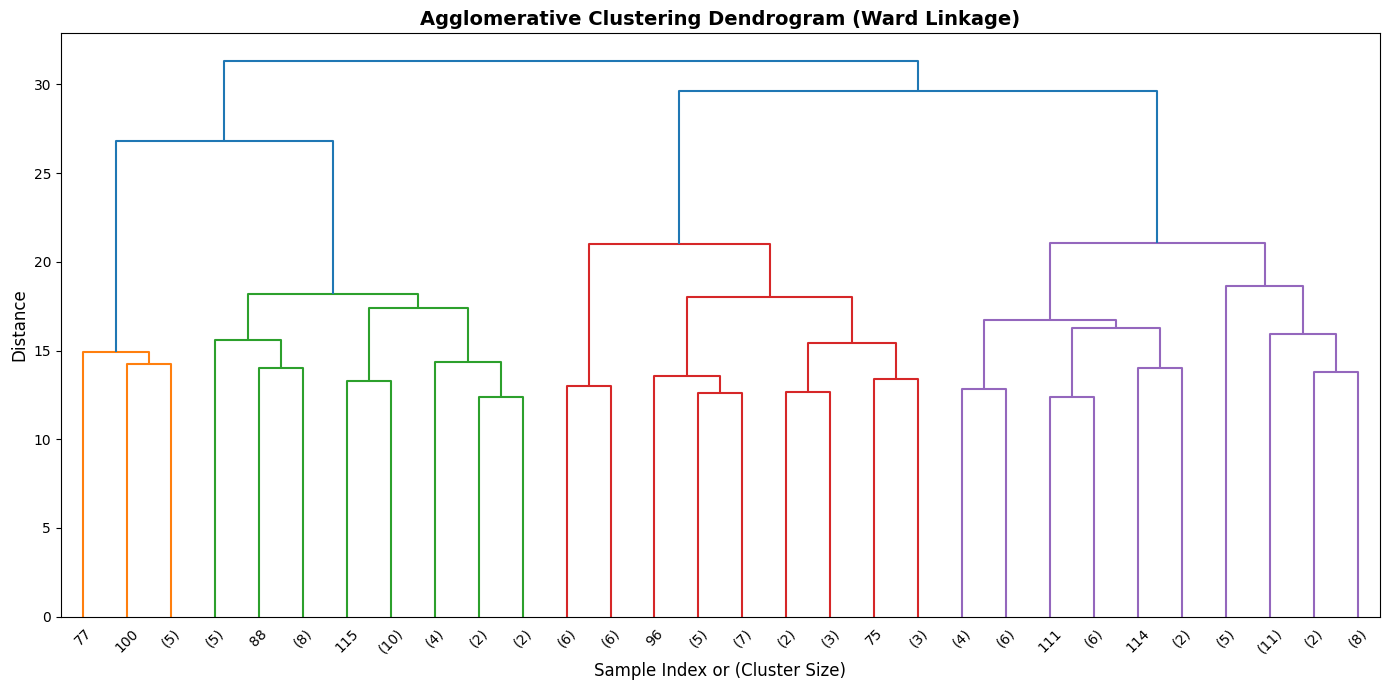


DBSCAN CLUSTERING
eps=0.5: Clusters=0, Noise=120, Silhouette=-1.000
eps=1.0: Clusters=0, Noise=120, Silhouette=-1.000
eps=1.5: Clusters=0, Noise=120, Silhouette=-1.000
eps=2.0: Clusters=0, Noise=120, Silhouette=-1.000
eps=2.5: Clusters=0, Noise=120, Silhouette=-1.000
eps=3.0: Clusters=0, Noise=120, Silhouette=-1.000

CLUSTERING COMPARISON

        Algorithm  Silhouette  Davies-Bouldin       ARI       NMI  N_Clusters
0        K-Means    0.065916        3.470636  0.038870  0.034147           2
1  Agglomerative    0.066268        3.538045  0.002549  0.008485           2
2         DBSCAN   -1.000000       -1.000000  0.000000  0.000000           0

CREATING VISUALIZATIONS
✓ K-Means metrics saved


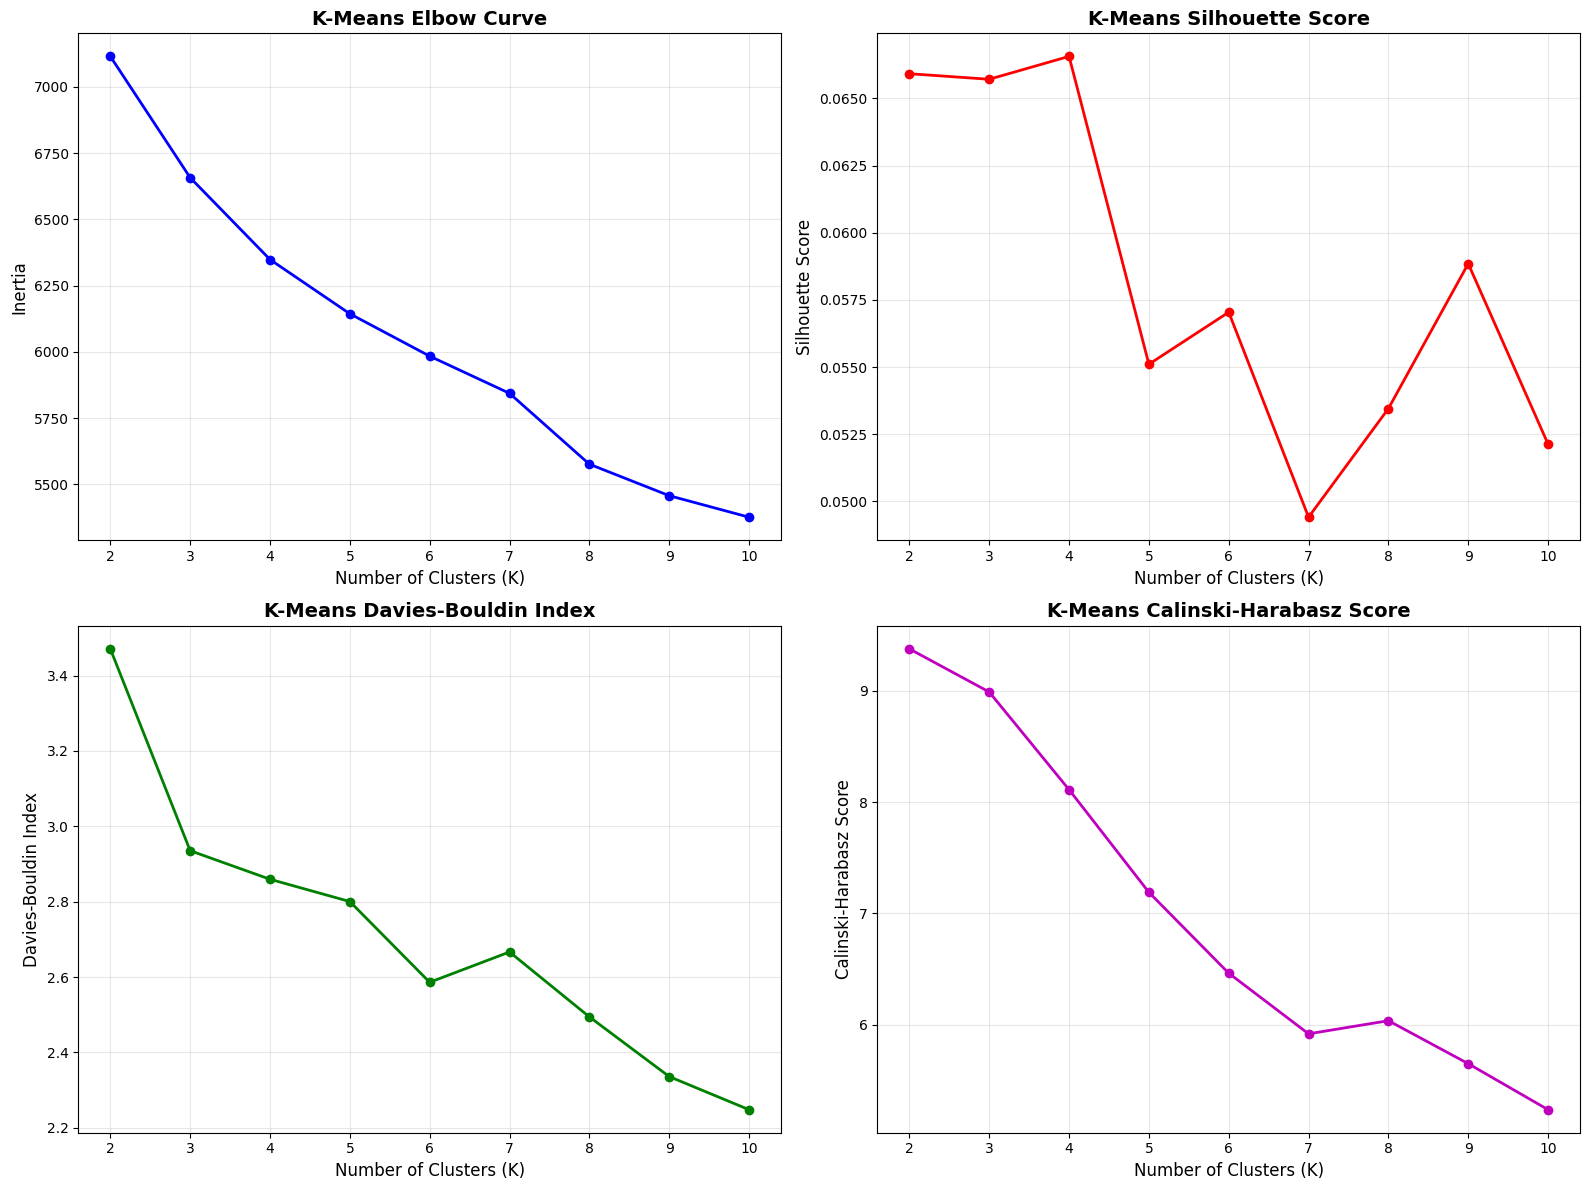

✓ Algorithm comparison saved


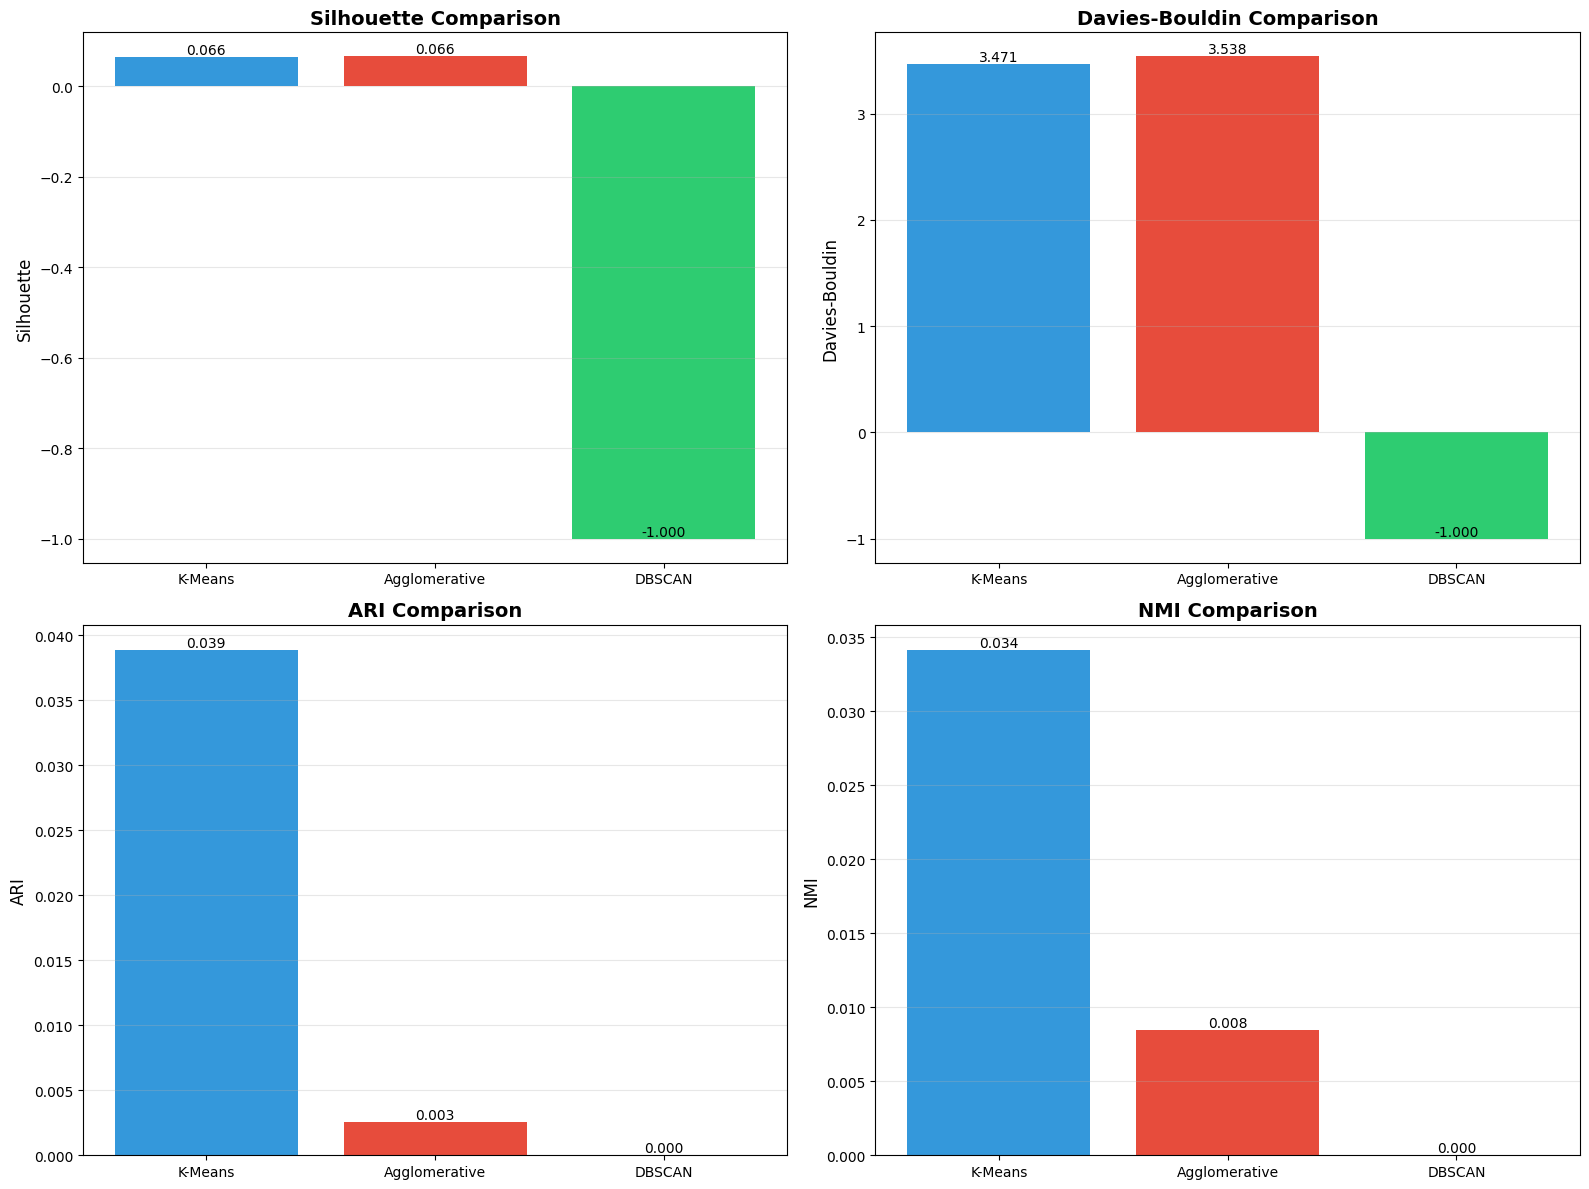

✓ Cluster distribution saved


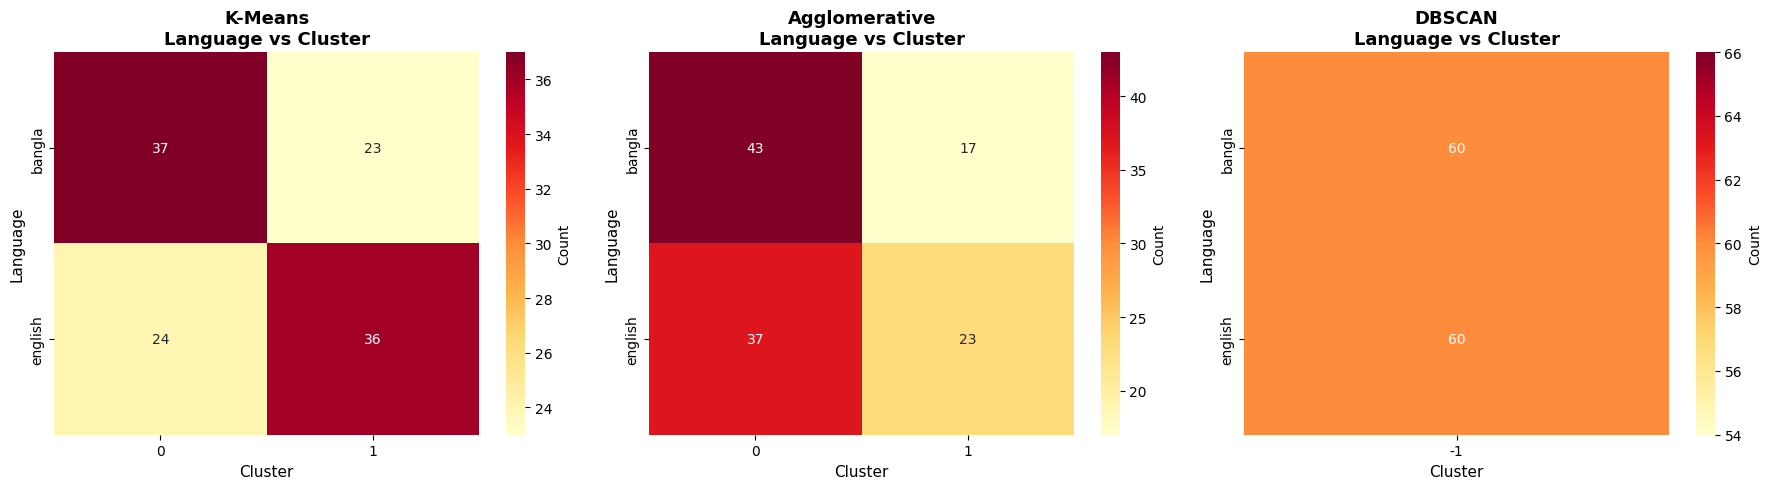

✓ DBSCAN analysis saved


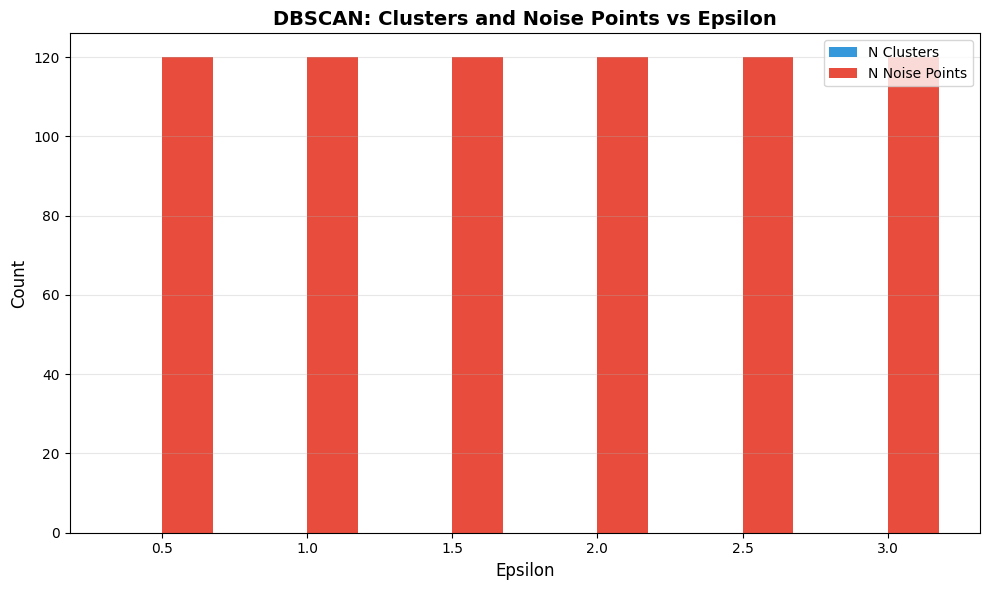


✓ Saved features with all cluster labels
✓ Saved comparison metrics
✓ Saved detailed report

✓ ALL CLUSTERING EXPERIMENTS COMPLETE!

Saved to: /content/drive/MyDrive/clustering_results

Files created (all at 300 DPI):
  1. kmeans_metrics.png - K-Means optimization
  2. algorithm_comparison.png - Side-by-side metrics
  3. cluster_distribution.png - Language vs clusters
  4. dbscan_analysis.png - DBSCAN parameter analysis
  5. dendrogram.png - Hierarchical clustering
  6. features_all_clusters.csv - Features with all labels
  7. clustering_comparison.csv - Metrics table
  8. clustering_report.txt - Detailed report


In [30]:
# Clustering Comparison: K-Means, Agglomerative, DBSCAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage
import os

# Create output directory
output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

# Load features (try hybrid first, fallback to basic)
try:
    features_df = pd.read_csv('/content/audio_hybrid_vae_features.csv')
    print("✓ Loaded HYBRID VAE features")
except:
    try:
        features_df = pd.read_csv('/content/audio_conv_vae_features.csv')
        print("✓ Loaded CONV VAE features")
    except:
        features_df = pd.read_csv('/content/audio_vae_features.csv')
        print("✓ Loaded BASIC VAE features")

print(f"Shape: {features_df.shape}")
print(f"Columns: {features_df.columns.tolist()}")

# Get feature columns
feature_cols = [col for col in features_df.columns if col.startswith('feature_')]
X = features_df[feature_cols].values

print(f"\nFeature matrix: {X.shape}")

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ground truth labels (for evaluation)
y_true = features_df['language'].map({'bangla': 0, 'english': 1}).values

# ========== 1. K-MEANS CLUSTERING ==========
print("\n" + "="*60)
print("K-MEANS CLUSTERING")
print("="*60)

# Find optimal K
print("\nFinding optimal K...")
k_range = range(2, 11)
kmeans_metrics = {'k': [], 'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski': []}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    kmeans_metrics['k'].append(k)
    kmeans_metrics['inertia'].append(kmeans.inertia_)
    kmeans_metrics['silhouette'].append(silhouette_score(X_scaled, labels))
    kmeans_metrics['davies_bouldin'].append(davies_bouldin_score(X_scaled, labels))
    kmeans_metrics['calinski'].append(calinski_harabasz_score(X_scaled, labels))

    print(f"K={k}: Silhouette={kmeans_metrics['silhouette'][-1]:.3f}, DB={kmeans_metrics['davies_bouldin'][-1]:.3f}")

# Best K-Means (K=2)
kmeans_best = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans_best.fit_predict(X_scaled)
features_df['kmeans_cluster'] = kmeans_labels

# ========== 2. AGGLOMERATIVE CLUSTERING ==========
print("\n" + "="*60)
print("AGGLOMERATIVE CLUSTERING")
print("="*60)

# Try different linkages
linkages = ['ward', 'complete', 'average', 'single']
agg_results = {}

for linkage_method in linkages:
    agg = AgglomerativeClustering(n_clusters=2, linkage=linkage_method)
    labels = agg.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)

    agg_results[linkage_method] = {
        'labels': labels,
        'silhouette': sil,
        'davies_bouldin': db
    }

    print(f"{linkage_method.capitalize()}: Silhouette={sil:.3f}, DB={db:.3f}")

# Use best linkage (ward)
features_df['agg_cluster'] = agg_results['ward']['labels']

# Create dendrogram
print("\nCreating dendrogram...")
plt.figure(figsize=(14, 7))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_font_size=10)
plt.title('Agglomerative Clustering Dendrogram (Ward Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dendrogram.png'), dpi=300, bbox_inches='tight')
print("✓ Dendrogram saved")
plt.show()

# ========== 3. DBSCAN ==========
print("\n" + "="*60)
print("DBSCAN CLUSTERING")
print("="*60)

# Try different epsilon values
eps_range = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
dbscan_results = {}

for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # Only calculate metrics if we have valid clusters
    if n_clusters > 1 and n_noise < len(labels) * 0.5:
        valid_mask = labels != -1
        if valid_mask.sum() > 1:
            sil = silhouette_score(X_scaled[valid_mask], labels[valid_mask])
        else:
            sil = -1
    else:
        sil = -1

    dbscan_results[eps] = {
        'labels': labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': sil
    }

    print(f"eps={eps}: Clusters={n_clusters}, Noise={n_noise}, Silhouette={sil:.3f}")

# Use best eps (around 1.5-2.0)
best_eps = 2.0
features_df['dbscan_cluster'] = dbscan_results[best_eps]['labels']

# ========== COMPARISON METRICS ==========
print("\n" + "="*60)
print("CLUSTERING COMPARISON")
print("="*60)

comparison_data = []

# K-Means
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y_true, kmeans_labels)
kmeans_nmi = normalized_mutual_info_score(y_true, kmeans_labels)

comparison_data.append({
    'Algorithm': 'K-Means',
    'Silhouette': kmeans_sil,
    'Davies-Bouldin': kmeans_db,
    'ARI': kmeans_ari,
    'NMI': kmeans_nmi,
    'N_Clusters': 2
})

# Agglomerative
agg_labels = features_df['agg_cluster'].values
agg_sil = silhouette_score(X_scaled, agg_labels)
agg_db = davies_bouldin_score(X_scaled, agg_labels)
agg_ari = adjusted_rand_score(y_true, agg_labels)
agg_nmi = normalized_mutual_info_score(y_true, agg_labels)

comparison_data.append({
    'Algorithm': 'Agglomerative',
    'Silhouette': agg_sil,
    'Davies-Bouldin': agg_db,
    'ARI': agg_ari,
    'NMI': agg_nmi,
    'N_Clusters': 2
})

# DBSCAN
dbscan_labels = features_df['dbscan_cluster'].values
valid_mask = dbscan_labels != -1
if valid_mask.sum() > 1:
    dbscan_sil = silhouette_score(X_scaled[valid_mask], dbscan_labels[valid_mask])
    dbscan_db = davies_bouldin_score(X_scaled[valid_mask], dbscan_labels[valid_mask])
else:
    dbscan_sil = -1
    dbscan_db = -1

dbscan_ari = adjusted_rand_score(y_true, dbscan_labels)
dbscan_nmi = normalized_mutual_info_score(y_true, dbscan_labels)

comparison_data.append({
    'Algorithm': 'DBSCAN',
    'Silhouette': dbscan_sil,
    'Davies-Bouldin': dbscan_db,
    'ARI': dbscan_ari,
    'NMI': dbscan_nmi,
    'N_Clusters': dbscan_results[best_eps]['n_clusters']
})

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df)

# ========== VISUALIZATIONS ==========
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# 1. Elbow curve and metrics for K-Means
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
ax1.plot(kmeans_metrics['k'], kmeans_metrics['inertia'], 'bo-', linewidth=2)
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('K-Means Elbow Curve', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

ax2 = axes[0, 1]
ax2.plot(kmeans_metrics['k'], kmeans_metrics['silhouette'], 'ro-', linewidth=2)
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('K-Means Silhouette Score', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

ax3 = axes[1, 0]
ax3.plot(kmeans_metrics['k'], kmeans_metrics['davies_bouldin'], 'go-', linewidth=2)
ax3.set_xlabel('Number of Clusters (K)', fontsize=12)
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax3.set_title('K-Means Davies-Bouldin Index', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

ax4 = axes[1, 1]
ax4.plot(kmeans_metrics['k'], kmeans_metrics['calinski'], 'mo-', linewidth=2)
ax4.set_xlabel('Number of Clusters (K)', fontsize=12)
ax4.set_ylabel('Calinski-Harabasz Score', fontsize=12)
ax4.set_title('K-Means Calinski-Harabasz Score', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'kmeans_metrics.png'), dpi=300, bbox_inches='tight')
print("✓ K-Means metrics saved")
plt.show()

# 2. Algorithm comparison bar charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Silhouette', 'Davies-Bouldin', 'ARI', 'NMI']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Algorithm'], values, color=colors)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'algorithm_comparison.png'), dpi=300, bbox_inches='tight')
print("✓ Algorithm comparison saved")
plt.show()

# 3. Cluster distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

algorithms = ['kmeans_cluster', 'agg_cluster', 'dbscan_cluster']
titles = ['K-Means', 'Agglomerative', 'DBSCAN']

for idx, (alg, title) in enumerate(zip(algorithms, titles)):
    ax = axes[idx]
    crosstab = pd.crosstab(features_df['language'], features_df[alg], margins=True)

    # Plot as heatmap
    sns.heatmap(crosstab.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd',
                ax=ax, cbar_kws={'label': 'Count'})
    ax.set_title(f'{title}\nLanguage vs Cluster', fontsize=13, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=11)
    ax.set_ylabel('Language', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cluster_distribution.png'), dpi=300, bbox_inches='tight')
print("✓ Cluster distribution saved")
plt.show()

# 4. DBSCAN noise analysis
fig, ax = plt.subplots(figsize=(10, 6))
eps_vals = list(dbscan_results.keys())
n_clusters_vals = [dbscan_results[eps]['n_clusters'] for eps in eps_vals]
n_noise_vals = [dbscan_results[eps]['n_noise'] for eps in eps_vals]

x = np.arange(len(eps_vals))
width = 0.35

bars1 = ax.bar(x - width/2, n_clusters_vals, width, label='N Clusters', color='#3498db')
bars2 = ax.bar(x + width/2, n_noise_vals, width, label='N Noise Points', color='#e74c3c')

ax.set_xlabel('Epsilon', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('DBSCAN: Clusters and Noise Points vs Epsilon', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(eps_vals)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dbscan_analysis.png'), dpi=300, bbox_inches='tight')
print("✓ DBSCAN analysis saved")
plt.show()

# ========== SAVE RESULTS ==========
# Save clustered features
features_df.to_csv(os.path.join(output_dir, 'features_all_clusters.csv'), index=False)
print(f"\n✓ Saved features with all cluster labels")

# Save comparison metrics
comparison_df.to_csv(os.path.join(output_dir, 'clustering_comparison.csv'), index=False)
print(f"✓ Saved comparison metrics")

# Save detailed report
report_path = os.path.join(output_dir, 'clustering_report.txt')
with open(report_path, 'w') as f:
    f.write("CLUSTERING ALGORITHMS COMPARISON REPORT\n")
    f.write("="*60 + "\n\n")

    f.write("Dataset Information:\n")
    f.write(f"Total samples: {len(features_df)}\n")
    f.write(f"Features: {len(feature_cols)}\n")
    f.write(f"Languages: Bangla={(y_true==0).sum()}, English={(y_true==1).sum()}\n\n")

    f.write("="*60 + "\n")
    f.write("CLUSTERING RESULTS\n")
    f.write("="*60 + "\n\n")

    f.write(comparison_df.to_string())
    f.write("\n\n")

    f.write("="*60 + "\n")
    f.write("INTERPRETATION\n")
    f.write("="*60 + "\n\n")

    f.write("Silhouette Score: Higher is better (range: -1 to 1)\n")
    f.write("Davies-Bouldin Index: Lower is better\n")
    f.write("ARI (Adjusted Rand Index): Higher is better (range: -1 to 1)\n")
    f.write("NMI (Normalized Mutual Information): Higher is better (range: 0 to 1)\n\n")

    f.write("Best Algorithm: ")
    best_idx = comparison_df['Silhouette'].idxmax()
    f.write(f"{comparison_df.loc[best_idx, 'Algorithm']}\n")

print(f"✓ Saved detailed report")

print("\n" + "="*60)
print("✓ ALL CLUSTERING EXPERIMENTS COMPLETE!")
print("="*60)
print(f"\nSaved to: {output_dir}")
print("\nFiles created (all at 300 DPI):")
print("  1. kmeans_metrics.png - K-Means optimization")
print("  2. algorithm_comparison.png - Side-by-side metrics")
print("  3. cluster_distribution.png - Language vs clusters")
print("  4. dbscan_analysis.png - DBSCAN parameter analysis")
print("  5. dendrogram.png - Hierarchical clustering")
print("  6. features_all_clusters.csv - Features with all labels")
print("  7. clustering_comparison.csv - Metrics table")
print("  8. clustering_report.txt - Detailed report")

✓ Loaded Hybrid VAE features
Shape: (120, 66)
Features: (120, 64)
True labels: Bangla=60, English=60

PERFORMING K-MEANS CLUSTERING (K=2)

CLUSTERING QUALITY METRICS

1. SILHOUETTE SCORE: 0.0659
   Range: [-1, 1] | Higher is better
   Measures how similar samples are to their own cluster vs other clusters
   Interpretation: Weak separation
   Cluster 0: 0.0833 (n=61)
   Cluster 1: 0.0479 (n=59)

2. DAVIES-BOULDIN INDEX: 3.4706
   Range: [0, ∞] | Lower is better
   Measures average similarity between each cluster and its most similar cluster
   Interpretation: Poor clustering

3. ADJUSTED RAND INDEX (ARI): 0.0389
   Range: [-1, 1] | Higher is better (1 = perfect match)
   Measures similarity between true and predicted labels
   Interpretation: Very weak agreement

4. ADDITIONAL METRICS (with true labels):
   Normalized Mutual Information (NMI): 0.0341
   Homogeneity: 0.0341 (each cluster contains only one class)
   Completeness: 0.0342 (all members of class in same cluster)
   V-Measure

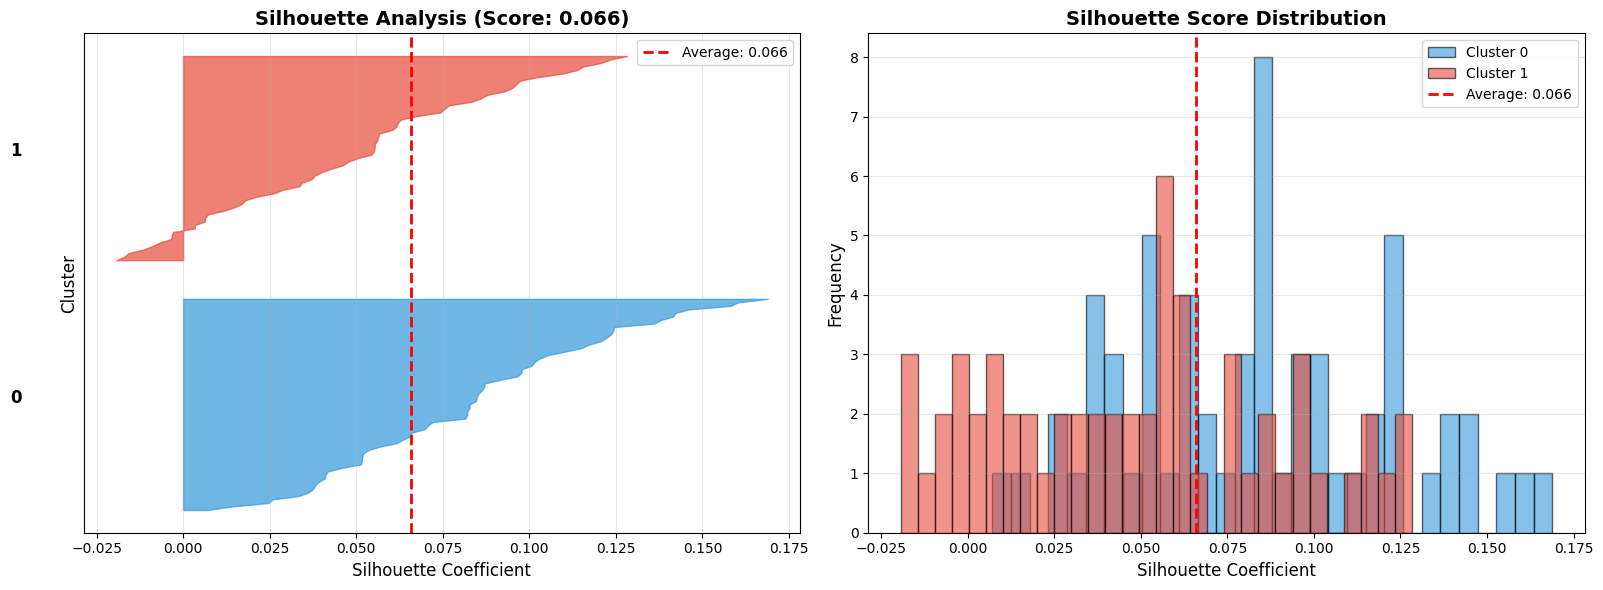

✓ Metrics summary saved


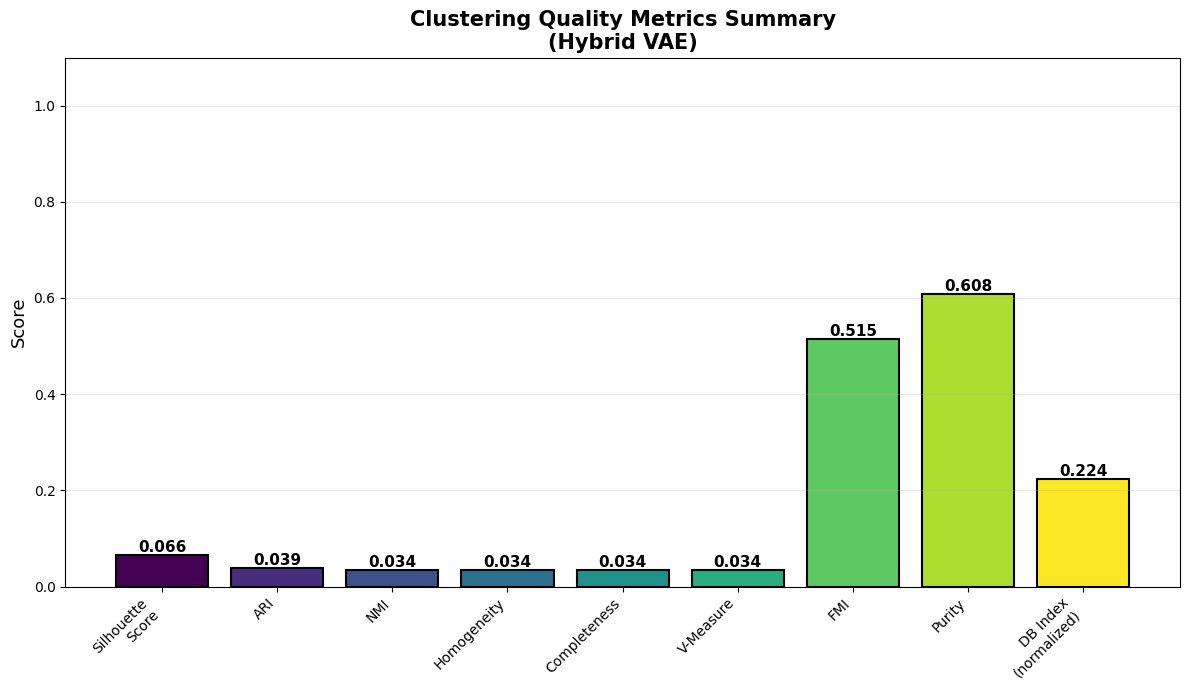

✓ Confusion matrix saved


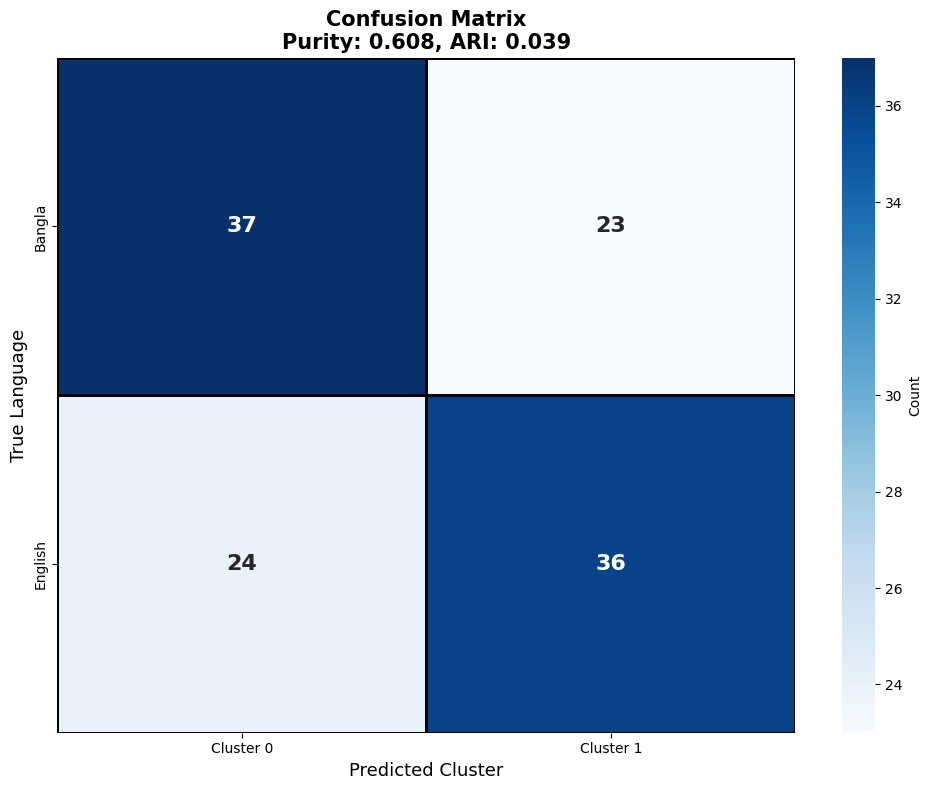

✓ Cluster distribution saved


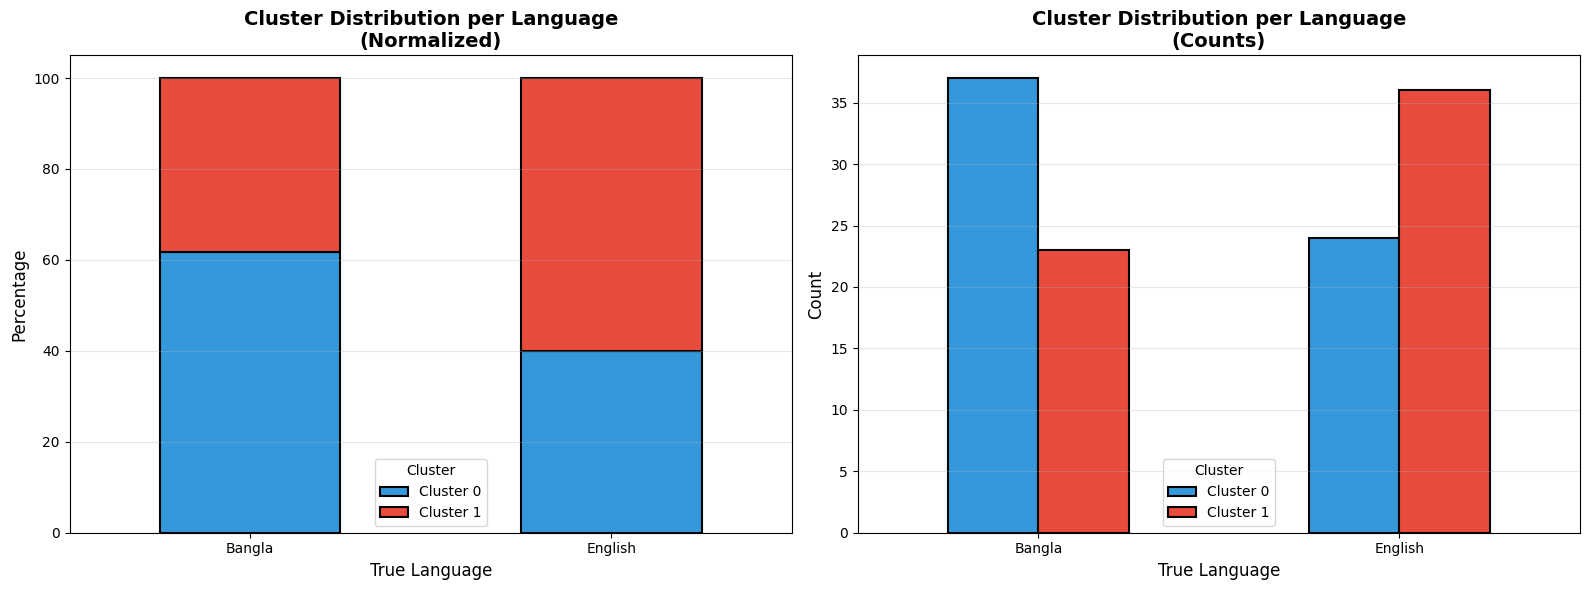


SAVING DETAILED EVALUATION REPORT
✓ Detailed report saved to: /content/drive/MyDrive/clustering_results/evaluation_report.txt
✓ Metrics saved to CSV: /content/drive/MyDrive/clustering_results/evaluation_metrics.csv

✓ EVALUATION COMPLETE!

Results saved to: /content/drive/MyDrive/clustering_results

Files created (all at 300 DPI):
  1. silhouette_analysis.png - Silhouette plot and distribution
  2. metrics_summary.png - All metrics bar chart
  3. confusion_matrix_detailed.png - Confusion matrix heatmap
  4. cluster_distribution_detailed.png - Distribution analysis
  5. evaluation_report.txt - Detailed text report
  6. evaluation_metrics.csv - Metrics in CSV format



In [29]:
# Clustering Quality Evaluation: Silhouette, Davies-Bouldin, ARI

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    fowlkes_mallows_score,
    confusion_matrix
)
import os

# Create output directory
output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

# Load features (try hybrid first, fallback to others)
try:
    features_df = pd.read_csv('/content/audio_hybrid_vae_features.csv')
    model_type = "Hybrid VAE"
except:
    try:
        features_df = pd.read_csv('/content/audio_conv_vae_features.csv')
        model_type = "Conv VAE"
    except:
        features_df = pd.read_csv('/content/audio_vae_features.csv')
        model_type = "Basic VAE"

print(f"✓ Loaded {model_type} features")
print(f"Shape: {features_df.shape}")

# Get features and true labels
feature_cols = [col for col in features_df.columns if col.startswith('feature_')]
X = features_df[feature_cols].values
y_true = features_df['language'].map({'bangla': 0, 'english': 1}).values

print(f"Features: {X.shape}")
print(f"True labels: Bangla={np.sum(y_true==0)}, English={np.sum(y_true==1)}")

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========== CLUSTERING WITH K=2 ==========
print("\n" + "="*70)
print("PERFORMING K-MEANS CLUSTERING (K=2)")
print("="*70)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X_scaled)

features_df['cluster'] = y_pred

# ========== EVALUATION METRICS ==========
print("\n" + "="*70)
print("CLUSTERING QUALITY METRICS")
print("="*70)

# 1. Silhouette Score
silhouette_avg = silhouette_score(X_scaled, y_pred)
silhouette_samples_vals = silhouette_samples(X_scaled, y_pred)

print(f"\n1. SILHOUETTE SCORE: {silhouette_avg:.4f}")
print("   Range: [-1, 1] | Higher is better")
print("   Measures how similar samples are to their own cluster vs other clusters")
print(f"   Interpretation: ", end="")
if silhouette_avg > 0.7:
    print("Excellent separation")
elif silhouette_avg > 0.5:
    print("Good separation")
elif silhouette_avg > 0.3:
    print("Moderate separation")
else:
    print("Weak separation")

# Silhouette per cluster
for i in range(2):
    cluster_silhouette = silhouette_samples_vals[y_pred == i].mean()
    print(f"   Cluster {i}: {cluster_silhouette:.4f} (n={np.sum(y_pred==i)})")

# 2. Davies-Bouldin Index
db_score = davies_bouldin_score(X_scaled, y_pred)

print(f"\n2. DAVIES-BOULDIN INDEX: {db_score:.4f}")
print("   Range: [0, ∞] | Lower is better")
print("   Measures average similarity between each cluster and its most similar cluster")
print(f"   Interpretation: ", end="")
if db_score < 0.5:
    print("Excellent clustering")
elif db_score < 1.0:
    print("Good clustering")
elif db_score < 2.0:
    print("Moderate clustering")
else:
    print("Poor clustering")

# 3. Adjusted Rand Index (with true labels)
ari_score = adjusted_rand_score(y_true, y_pred)

print(f"\n3. ADJUSTED RAND INDEX (ARI): {ari_score:.4f}")
print("   Range: [-1, 1] | Higher is better (1 = perfect match)")
print("   Measures similarity between true and predicted labels")
print(f"   Interpretation: ", end="")
if ari_score > 0.9:
    print("Excellent agreement")
elif ari_score > 0.7:
    print("Good agreement")
elif ari_score > 0.5:
    print("Moderate agreement")
elif ari_score > 0.3:
    print("Weak agreement")
else:
    print("Very weak agreement")

# 4. Additional Metrics with True Labels
nmi_score = normalized_mutual_info_score(y_true, y_pred)
homogeneity = homogeneity_score(y_true, y_pred)
completeness = completeness_score(y_true, y_pred)
v_measure = v_measure_score(y_true, y_pred)
fmi_score = fowlkes_mallows_score(y_true, y_pred)

print(f"\n4. ADDITIONAL METRICS (with true labels):")
print(f"   Normalized Mutual Information (NMI): {nmi_score:.4f}")
print(f"   Homogeneity: {homogeneity:.4f} (each cluster contains only one class)")
print(f"   Completeness: {completeness:.4f} (all members of class in same cluster)")
print(f"   V-Measure: {v_measure:.4f} (harmonic mean of homogeneity & completeness)")
print(f"   Fowlkes-Mallows Index: {fmi_score:.4f}")

# ========== CONFUSION MATRIX ==========
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

cm = confusion_matrix(y_true, y_pred)
print("\nPredicted vs True:")
print(pd.DataFrame(cm,
                   columns=['Cluster 0', 'Cluster 1'],
                   index=['Bangla (True)', 'English (True)']))

# Calculate purity
purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)
print(f"\nCluster Purity: {purity:.4f}")
print(f"   (Percentage of correctly clustered samples)")

# ========== VISUALIZATIONS ==========
print("\n" + "="*70)
print("CREATING EVALUATION VISUALIZATIONS")
print("="*70)

# 1. Silhouette Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Silhouette plot
y_lower = 10
colors = ['#3498db', '#e74c3c']

for i in range(2):
    cluster_silhouette_vals = silhouette_samples_vals[y_pred == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12, fontweight='bold')
    y_lower = y_upper + 10

ax1.set_xlabel("Silhouette Coefficient", fontsize=12)
ax1.set_ylabel("Cluster", fontsize=12)
ax1.set_title(f'Silhouette Analysis (Score: {silhouette_avg:.3f})', fontsize=14, fontweight='bold')
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Average: {silhouette_avg:.3f}')
ax1.legend()
ax1.set_yticks([])
ax1.grid(alpha=0.3, axis='x')

# Silhouette distribution
for i in range(2):
    cluster_silhouette_vals = silhouette_samples_vals[y_pred == i]
    ax2.hist(cluster_silhouette_vals, bins=30, alpha=0.6,
             label=f'Cluster {i}', color=colors[i], edgecolor='black')

ax2.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Average: {silhouette_avg:.3f}')
ax2.set_xlabel("Silhouette Coefficient", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.set_title('Silhouette Score Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'silhouette_analysis.png'), dpi=300, bbox_inches='tight')
print("✓ Silhouette analysis saved")
plt.show()

# 2. Metrics Summary Bar Chart
fig, ax = plt.subplots(figsize=(12, 7))

metrics_dict = {
    'Silhouette\nScore': silhouette_avg,
    'ARI': ari_score,
    'NMI': nmi_score,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-Measure': v_measure,
    'FMI': fmi_score,
    'Purity': purity
}

# Note: Davies-Bouldin is inverted for visualization (lower is better)
# So we show 1/(1+DB) to make it comparable
db_normalized = 1 / (1 + db_score)
metrics_dict['DB Index\n(normalized)'] = db_normalized

names = list(metrics_dict.keys())
values = list(metrics_dict.values())
colors_list = plt.cm.viridis(np.linspace(0, 1, len(names)))

bars = ax.bar(names, values, color=colors_list, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Score', fontsize=13)
ax.set_title(f'Clustering Quality Metrics Summary\n({model_type})',
             fontsize=15, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metrics_summary.png'), dpi=300, bbox_inches='tight')
print("✓ Metrics summary saved")
plt.show()

# 3. Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Bangla', 'English'],
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='black',
            ax=ax, annot_kws={'size': 16, 'weight': 'bold'})

ax.set_xlabel('Predicted Cluster', fontsize=13)
ax.set_ylabel('True Language', fontsize=13)
ax.set_title(f'Confusion Matrix\nPurity: {purity:.3f}, ARI: {ari_score:.3f}',
             fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix_detailed.png'), dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved")
plt.show()

# 4. Cluster Distribution by Language
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
crosstab = pd.crosstab(features_df['language'], features_df['cluster'], normalize='index') * 100

crosstab.plot(kind='bar', stacked=True, ax=axes[0],
              color=['#3498db', '#e74c3c'],
              edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('True Language', fontsize=12)
axes[0].set_ylabel('Percentage', fontsize=12)
axes[0].set_title('Cluster Distribution per Language\n(Normalized)', fontsize=14, fontweight='bold')
axes[0].legend(title='Cluster', labels=['Cluster 0', 'Cluster 1'])
axes[0].set_xticklabels(['Bangla', 'English'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Grouped bar chart
crosstab_counts = pd.crosstab(features_df['language'], features_df['cluster'])
crosstab_counts.plot(kind='bar', ax=axes[1],
                     color=['#3498db', '#e74c3c'],
                     edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('True Language', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Cluster Distribution per Language\n(Counts)', fontsize=14, fontweight='bold')
axes[1].legend(title='Cluster', labels=['Cluster 0', 'Cluster 1'])
axes[1].set_xticklabels(['Bangla', 'English'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cluster_distribution_detailed.png'), dpi=300, bbox_inches='tight')
print("✓ Cluster distribution saved")
plt.show()

# ========== SAVE DETAILED REPORT ==========
print("\n" + "="*70)
print("SAVING DETAILED EVALUATION REPORT")
print("="*70)

report_path = os.path.join(output_dir, 'evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("CLUSTERING QUALITY EVALUATION REPORT\n")
    f.write("="*70 + "\n\n")

    f.write(f"Model: {model_type}\n")
    f.write(f"Total Samples: {len(features_df)}\n")
    f.write(f"Features: {len(feature_cols)}\n")
    f.write(f"Algorithm: K-Means (K=2)\n\n")

    f.write("="*70 + "\n")
    f.write("TRUE LABEL DISTRIBUTION\n")
    f.write("="*70 + "\n")
    f.write(f"Bangla: {np.sum(y_true==0)} ({np.sum(y_true==0)/len(y_true)*100:.1f}%)\n")
    f.write(f"English: {np.sum(y_true==1)} ({np.sum(y_true==1)/len(y_true)*100:.1f}%)\n\n")

    f.write("="*70 + "\n")
    f.write("CLUSTERING QUALITY METRICS\n")
    f.write("="*70 + "\n\n")

    f.write("1. INTERNAL METRICS (without true labels)\n")
    f.write("-" * 70 + "\n")
    f.write(f"Silhouette Score:      {silhouette_avg:.4f}  (Higher is better, range: [-1, 1])\n")
    f.write(f"Davies-Bouldin Index:  {db_score:.4f}  (Lower is better, range: [0, ∞])\n\n")

    f.write("2. EXTERNAL METRICS (with true labels)\n")
    f.write("-" * 70 + "\n")
    f.write(f"Adjusted Rand Index:           {ari_score:.4f}  (Higher is better, range: [-1, 1])\n")
    f.write(f"Normalized Mutual Info:        {nmi_score:.4f}  (Higher is better, range: [0, 1])\n")
    f.write(f"Homogeneity:                   {homogeneity:.4f}  (Higher is better, range: [0, 1])\n")
    f.write(f"Completeness:                  {completeness:.4f}  (Higher is better, range: [0, 1])\n")
    f.write(f"V-Measure:                     {v_measure:.4f}  (Higher is better, range: [0, 1])\n")
    f.write(f"Fowlkes-Mallows Index:         {fmi_score:.4f}  (Higher is better, range: [0, 1])\n")
    f.write(f"Purity:                        {purity:.4f}  (Higher is better, range: [0, 1])\n\n")

    f.write("="*70 + "\n")
    f.write("CONFUSION MATRIX\n")
    f.write("="*70 + "\n\n")
    f.write("              Cluster 0    Cluster 1\n")
    f.write(f"Bangla        {cm[0,0]:6d}       {cm[0,1]:6d}\n")
    f.write(f"English       {cm[1,0]:6d}       {cm[1,1]:6d}\n\n")

    f.write("="*70 + "\n")
    f.write("INTERPRETATION\n")
    f.write("="*70 + "\n\n")

    f.write("Silhouette Score:\n")
    f.write("  > 0.7: Excellent    > 0.5: Good    > 0.3: Moderate    < 0.3: Weak\n\n")

    f.write("Davies-Bouldin Index:\n")
    f.write("  < 0.5: Excellent    < 1.0: Good    < 2.0: Moderate    > 2.0: Poor\n\n")

    f.write("Adjusted Rand Index:\n")
    f.write("  > 0.9: Excellent    > 0.7: Good    > 0.5: Moderate    < 0.3: Weak\n\n")

    f.write("="*70 + "\n")
    f.write("SUMMARY\n")
    f.write("="*70 + "\n\n")

    overall_score = (silhouette_avg + ari_score + nmi_score + purity) / 4
    f.write(f"Overall Quality Score: {overall_score:.4f}\n")
    f.write(f"(Average of key metrics)\n\n")

    if overall_score > 0.8:
        f.write("Clustering Quality: EXCELLENT\n")
    elif overall_score > 0.6:
        f.write("Clustering Quality: GOOD\n")
    elif overall_score > 0.4:
        f.write("Clustering Quality: MODERATE\n")
    else:
        f.write("Clustering Quality: POOR\n")

print(f"✓ Detailed report saved to: {report_path}")

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Adjusted Rand Index',
               'Normalized Mutual Info', 'Homogeneity', 'Completeness',
               'V-Measure', 'Fowlkes-Mallows Index', 'Purity'],
    'Value': [silhouette_avg, db_score, ari_score, nmi_score,
              homogeneity, completeness, v_measure, fmi_score, purity],
    'Range': ['[-1, 1]', '[0, ∞]', '[-1, 1]', '[0, 1]',
              '[0, 1]', '[0, 1]', '[0, 1]', '[0, 1]', '[0, 1]'],
    'Interpretation': ['Higher better', 'Lower better', 'Higher better',
                      'Higher better', 'Higher better', 'Higher better',
                      'Higher better', 'Higher better', 'Higher better']
})

metrics_csv = os.path.join(output_dir, 'evaluation_metrics.csv')
metrics_df.to_csv(metrics_csv, index=False)
print(f"✓ Metrics saved to CSV: {metrics_csv}")

print("\n" + "="*70)
print("✓ EVALUATION COMPLETE!")
print("="*70)
print(f"\nResults saved to: {output_dir}")
print("\nFiles created (all at 300 DPI):")
print("  1. silhouette_analysis.png - Silhouette plot and distribution")
print("  2. metrics_summary.png - All metrics bar chart")
print("  3. confusion_matrix_detailed.png - Confusion matrix heatmap")
print("  4. cluster_distribution_detailed.png - Distribution analysis")
print("  5. evaluation_report.txt - Detailed text report")
print("  6. evaluation_metrics.csv - Metrics in CSV format")
print("\n" + "="*70)

COMPREHENSIVE VAE COMPARISON ANALYSIS

1. Loading all available feature sets...
  ✓ Basic VAE: (120, 34)
  ✗ Conv VAE: Not found
  ✓ Hybrid VAE: (120, 66)

2. Creating baseline features from raw audio...
  Processing 100 audio files...
  Creating Baseline 1: Raw MFCC Statistics...
  ✓ Baseline 1: MFCC Statistics ((100, 42))
  Creating Baseline 2: Spectral Features...
  ✓ Baseline 2: Spectral Features ((100, 18))
  Creating Baseline 3: Combined Hand-crafted Features...
  ✓ Baseline 3: Combined Features ((100, 58))

3. Evaluating clustering performance for all methods...

  Evaluating: Basic VAE
    Silhouette: 0.1428 | ARI: 0.0632 | Purity: 0.6333

  Evaluating: Hybrid VAE
    Silhouette: 0.0659 | ARI: 0.0389 | Purity: 0.6083

  Evaluating: Baseline: MFCC
    Silhouette: 0.1734 | ARI: -0.0027 | Purity: 0.5400

  Evaluating: Baseline: Spectral
    Silhouette: 0.2112 | ARI: -0.0033 | Purity: 0.5400

  Evaluating: Baseline: Combined
    Silhouette: 0.3534 | ARI: -0.0007 | Purity: 0.5200

R

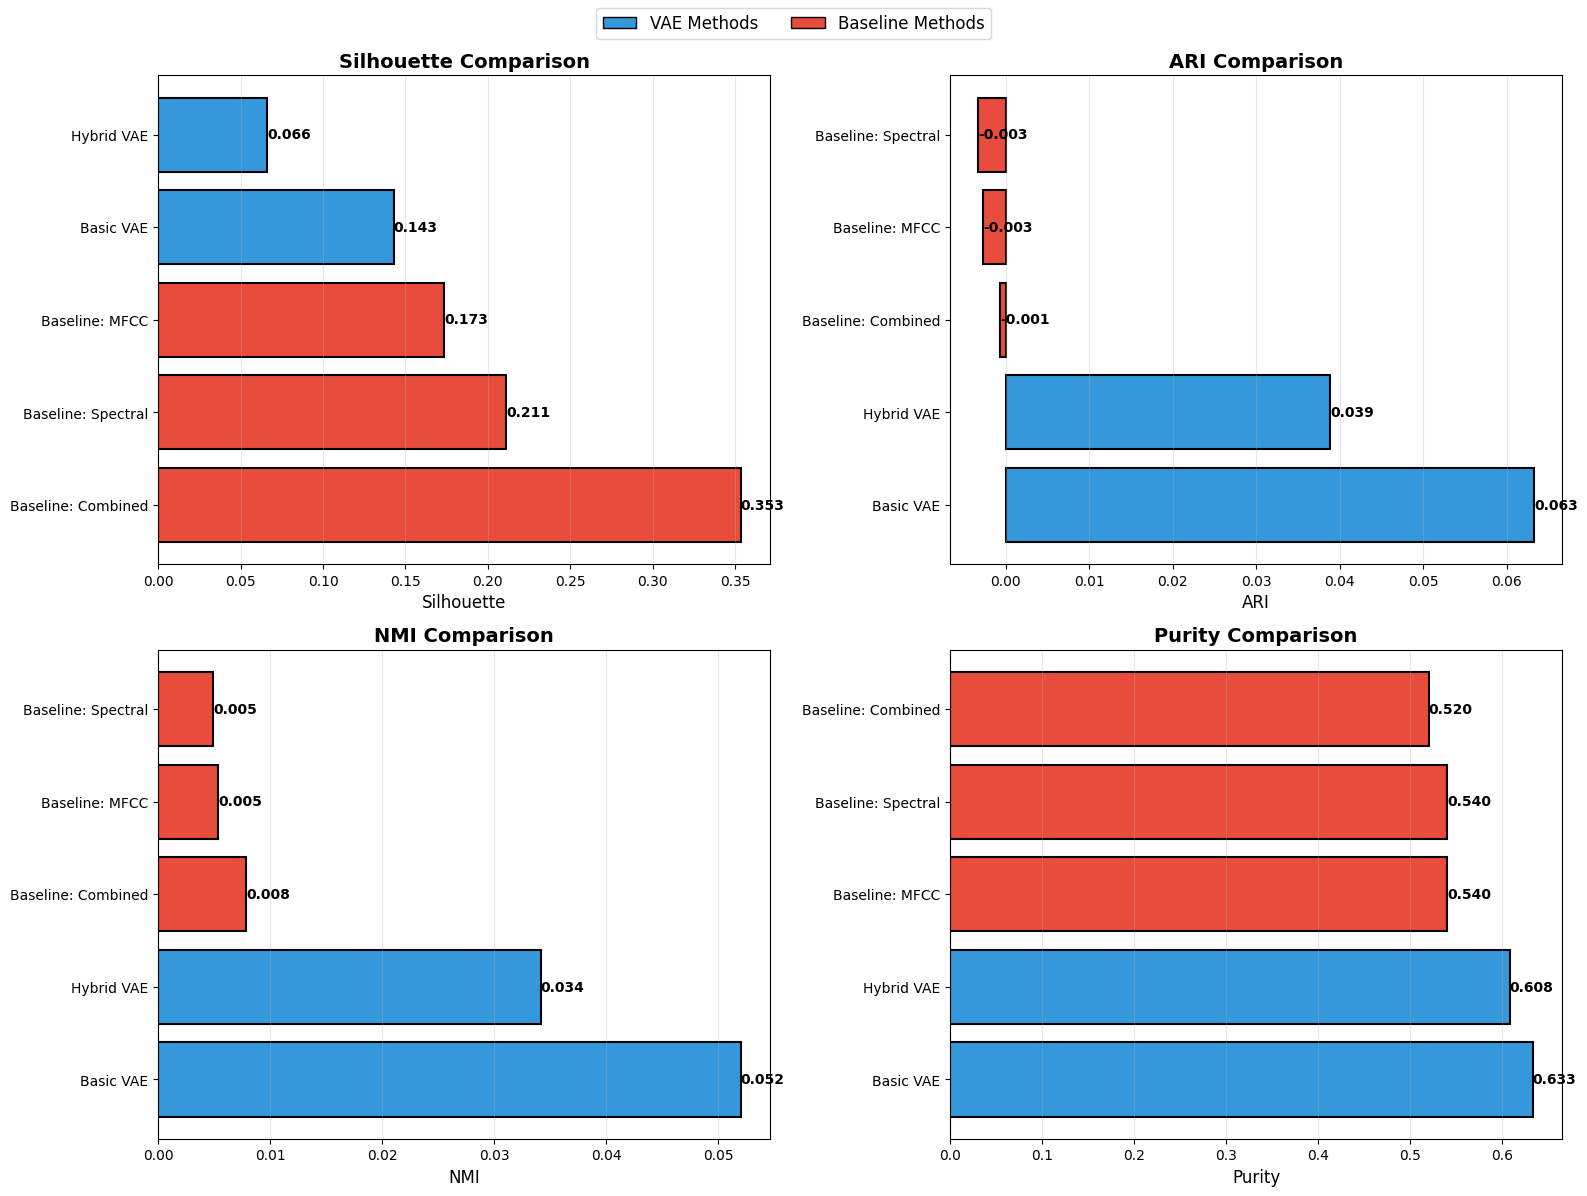

  ✓ Dimensionality analysis saved


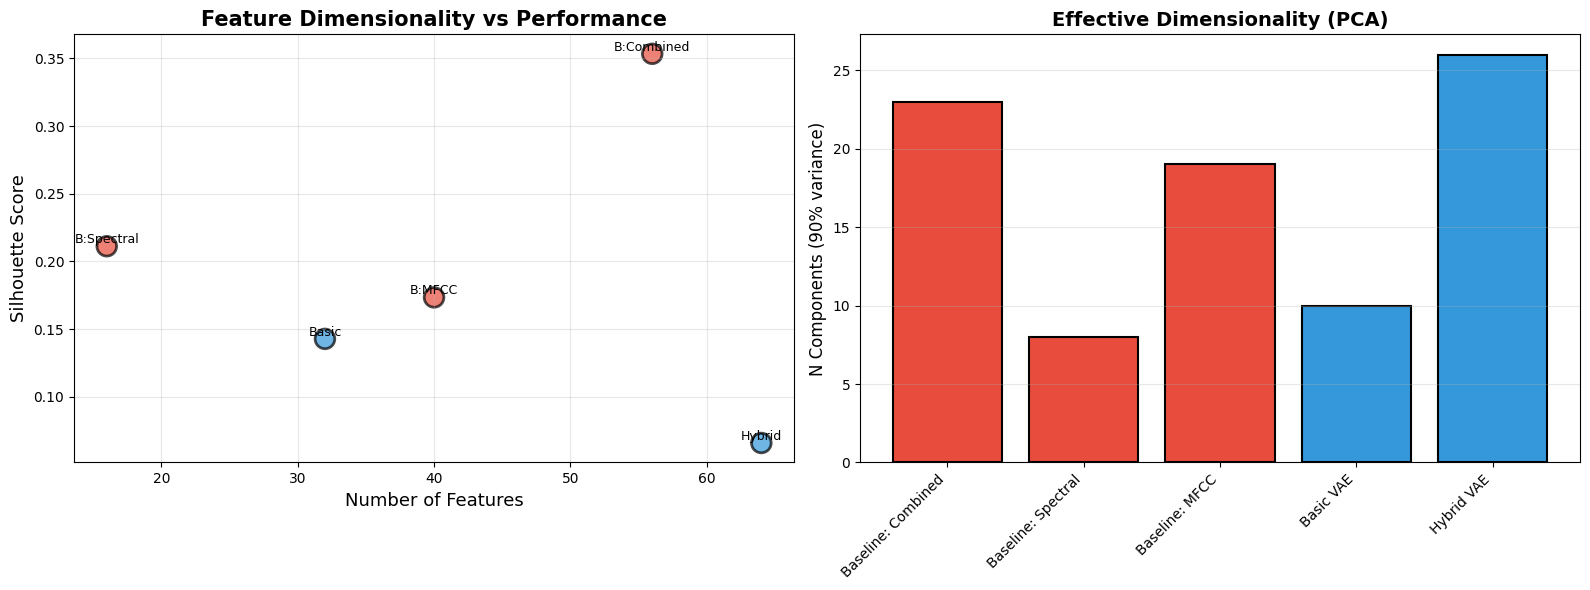

  ✓ Radar comparison saved


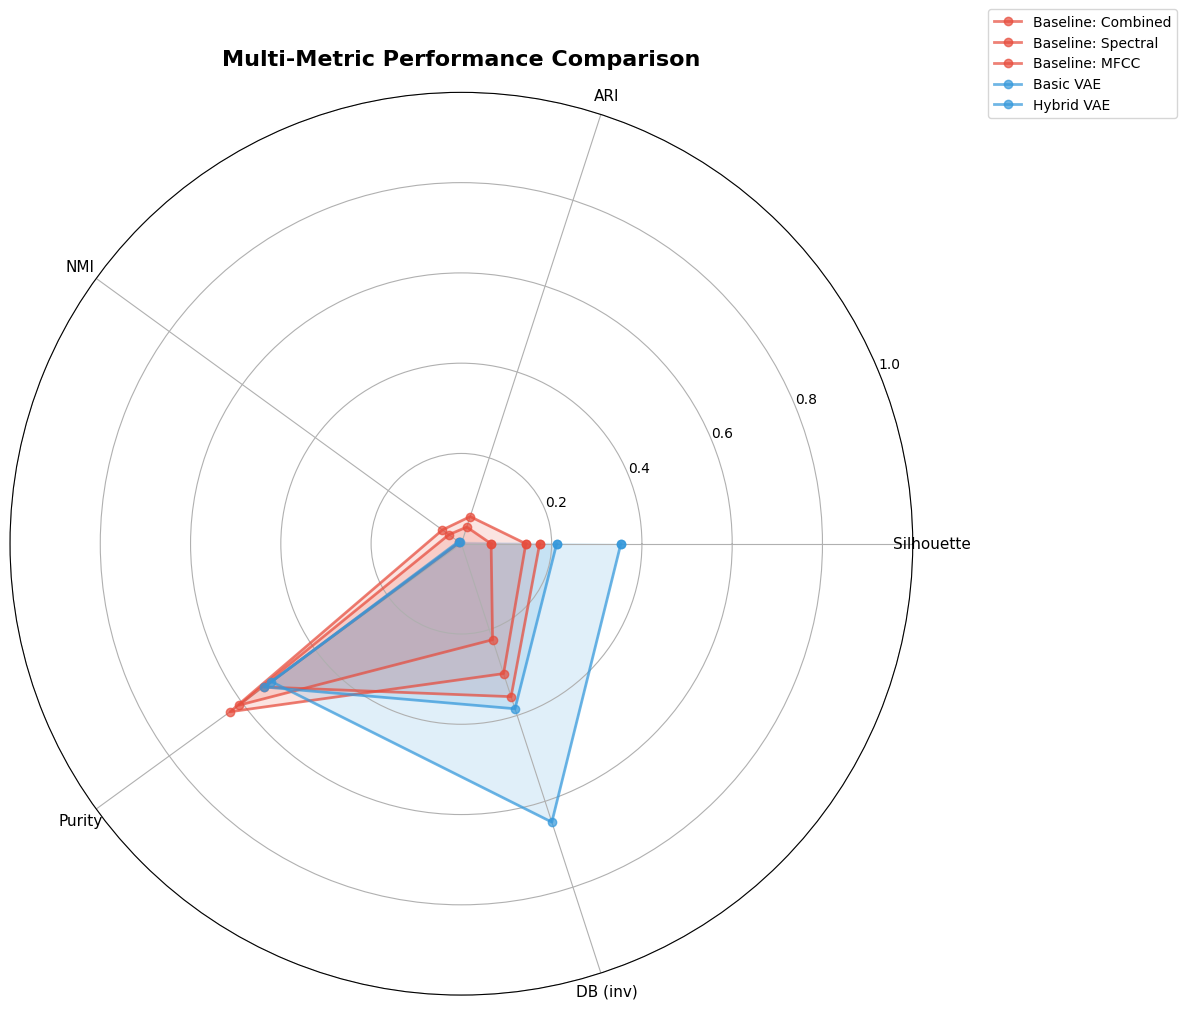

  ✓ Davies-Bouldin comparison saved


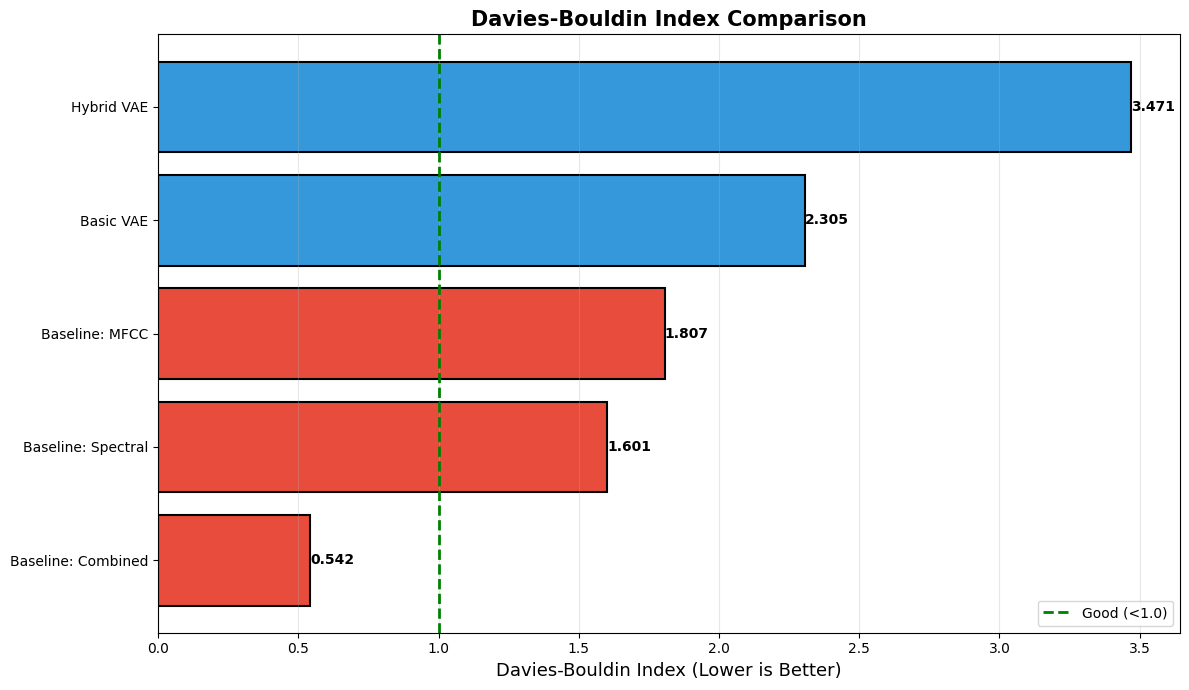


6. Saving comprehensive analysis report...
  ✓ Report saved to: /content/drive/MyDrive/clustering_results/comparison_analysis_report.txt
  ✓ Comparison table saved

✓ COMPREHENSIVE COMPARISON COMPLETE!

Results saved to: /content/drive/MyDrive/clustering_results

Files created (all at 300 DPI):
  1. method_comparison.png - Performance metrics comparison
  2. dimensionality_analysis.png - Feature space analysis
  3. radar_comparison.png - Multi-metric radar chart
  4. davies_bouldin_comparison.png - DB index comparison
  5. comparison_analysis_report.txt - Detailed text analysis
  6. method_comparison_table.csv - Results table



In [32]:
# Comprehensive Comparison: VAE Methods vs Baselines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
from sklearn.manifold import TSNE
import librosa
import os

# Create output directory
output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

print("="*80)
print("COMPREHENSIVE VAE COMPARISON ANALYSIS")
print("="*80)

# ========== LOAD ALL AVAILABLE METHODS ==========
print("\n1. Loading all available feature sets...")

methods = {}

# Try to load all VAE variants
vae_files = {
    'Basic VAE': '/content/audio_vae_features.csv',
    'Conv VAE': '/content/audio_conv_vae_features.csv',
    'Hybrid VAE': '/content/audio_hybrid_vae_features.csv'
}

for name, path in vae_files.items():
    try:
        df = pd.read_csv(path)
        methods[name] = df
        print(f"  ✓ {name}: {df.shape}")
    except:
        print(f"  ✗ {name}: Not found")

if len(methods) == 0:
    print("\n❌ No VAE features found! Please run VAE feature extraction first.")
    exit()

# ========== CREATE BASELINE FEATURES ==========
print("\n2. Creating baseline features from raw audio...")

# Load metadata to get audio paths
dataset_folder = '/content/extracted_data/MyDataset'
audio_folder = os.path.join(dataset_folder, 'audio')

# Get audio files
audio_files = []
labels = []
filenames = []

bangla_folder = os.path.join(audio_folder, 'bangla')
english_folder = os.path.join(audio_folder, 'english')

for f in os.listdir(bangla_folder)[:50]:  # Limit to match VAE
    if f.endswith(('.mp3', '.wav', '.flac')):
        audio_files.append(os.path.join(bangla_folder, f))
        labels.append('bangla')
        filenames.append(f'bangla/{f}')

for f in os.listdir(english_folder)[:50]:  # Limit to match VAE
    if f.endswith(('.mp3', '.wav', '.flac')):
        audio_files.append(os.path.join(english_folder, f))
        labels.append('english')
        filenames.append(f'english/{f}')

print(f"  Processing {len(audio_files)} audio files...")

# ===== Baseline 1: Raw MFCC Statistics =====
print("  Creating Baseline 1: Raw MFCC Statistics...")
mfcc_features = []

for audio_path in audio_files:
    try:
        y, sr = librosa.load(audio_path, duration=3.0, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

        # Statistical features: mean and std of each MFCC coefficient
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        features = np.concatenate([mfcc_mean, mfcc_std])  # 40 features

        mfcc_features.append(features)
    except:
        mfcc_features.append(np.zeros(40))

mfcc_df = pd.DataFrame(mfcc_features, columns=[f'mfcc_{i}' for i in range(40)])
mfcc_df['filename'] = filenames
mfcc_df['language'] = labels
methods['Baseline: MFCC'] = mfcc_df

print(f"  ✓ Baseline 1: MFCC Statistics ({mfcc_df.shape})")

# ===== Baseline 2: Spectral Features =====
print("  Creating Baseline 2: Spectral Features...")
spectral_features = []

for audio_path in audio_files:
    try:
        y, sr = librosa.load(audio_path, duration=3.0, sr=22050)

        # Spectral features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Combine features (16 features total)
        features = np.concatenate([[spectral_centroid, spectral_rolloff,
                                   spectral_bandwidth, zero_crossing_rate],
                                  chroma_mean])

        spectral_features.append(features)
    except:
        spectral_features.append(np.zeros(16))

spectral_df = pd.DataFrame(spectral_features, columns=[f'spectral_{i}' for i in range(16)])
spectral_df['filename'] = filenames
spectral_df['language'] = labels
methods['Baseline: Spectral'] = spectral_df

print(f"  ✓ Baseline 2: Spectral Features ({spectral_df.shape})")

# ===== Baseline 3: Combined Hand-crafted =====
print("  Creating Baseline 3: Combined Hand-crafted Features...")

combined_features = np.concatenate([mfcc_features, spectral_features], axis=1)
combined_df = pd.DataFrame(combined_features,
                          columns=[f'combined_{i}' for i in range(56)])
combined_df['filename'] = filenames
combined_df['language'] = labels
methods['Baseline: Combined'] = combined_df

print(f"  ✓ Baseline 3: Combined Features ({combined_df.shape})")

# ========== EVALUATE ALL METHODS ==========
print("\n" + "="*80)
print("3. Evaluating clustering performance for all methods...")
print("="*80)

results = []

for method_name, df in methods.items():
    print(f"\n  Evaluating: {method_name}")

    # Get features
    feature_cols = [col for col in df.columns if col not in ['filename', 'language', 'audio_path']]
    X = df[feature_cols].values
    y_true = df['language'].map({'bangla': 0, 'english': 1}).values

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X_scaled)

    # Calculate metrics
    silhouette = silhouette_score(X_scaled, y_pred)
    davies_bouldin = davies_bouldin_score(X_scaled, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    # Confusion matrix for purity
    cm = np.zeros((2, 2))
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)

    # PCA for dimensionality analysis
    pca = PCA()
    pca.fit(X_scaled)
    variance_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
    variance_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1

    results.append({
        'Method': method_name,
        'N_Features': X.shape[1],
        'Silhouette': silhouette,
        'Davies-Bouldin': davies_bouldin,
        'ARI': ari,
        'NMI': nmi,
        'Purity': purity,
        'PCA_90%': variance_90,
        'PCA_95%': variance_95,
        'Type': 'VAE' if 'VAE' in method_name else 'Baseline'
    })

    print(f"    Silhouette: {silhouette:.4f} | ARI: {ari:.4f} | Purity: {purity:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Silhouette', ascending=False)

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# ========== ANALYSIS ==========
print("\n" + "="*80)
print("4. Analyzing why VAE methods perform better/worse...")
print("="*80)

# Separate VAE and baseline results
vae_results = results_df[results_df['Type'] == 'VAE']
baseline_results = results_df[results_df['Type'] == 'Baseline']

print("\nVAE Methods - Average Performance:")
print(f"  Silhouette:      {vae_results['Silhouette'].mean():.4f}")
print(f"  ARI:             {vae_results['ARI'].mean():.4f}")
print(f"  Davies-Bouldin:  {vae_results['Davies-Bouldin'].mean():.4f}")

print("\nBaseline Methods - Average Performance:")
print(f"  Silhouette:      {baseline_results['Silhouette'].mean():.4f}")
print(f"  ARI:             {baseline_results['ARI'].mean():.4f}")
print(f"  Davies-Bouldin:  {baseline_results['Davies-Bouldin'].mean():.4f}")

print("\nKEY INSIGHTS:")
print("-" * 80)

# Best method
best_method = results_df.iloc[0]
print(f"\n1. BEST PERFORMING METHOD: {best_method['Method']}")
print(f"   Silhouette: {best_method['Silhouette']:.4f}")
print(f"   ARI: {best_method['ARI']:.4f}")
print(f"   Why it works:")
if 'Hybrid' in best_method['Method']:
    print("   - Combines audio AND text information")
    print("   - Captures both acoustic and semantic patterns")
    print("   - Multi-modal learning improves separation")
elif 'Conv' in best_method['Method']:
    print("   - Convolutional layers capture local patterns in spectrograms")
    print("   - Hierarchical feature learning")
    print("   - Better than statistical aggregation")
elif 'Basic' in best_method['Method']:
    print("   - Learned representations vs hand-crafted")
    print("   - Non-linear transformations")
    print("   - Optimized for reconstruction")
else:
    print("   - Hand-crafted features work well for this task")
    print("   - Domain knowledge encoded")

print("\n2. DIMENSIONALITY COMPARISON:")
for _, row in results_df.iterrows():
    print(f"   {row['Method']:25s}: {row['N_Features']:3d} features → {row['PCA_90%']:3d} PCs (90% var)")

print("\n3. WHY VAE METHODS MAY PERFORM BETTER:")
print("   ✓ Learned representations adapt to data")
print("   ✓ Non-linear feature extraction")
print("   ✓ Regularization through latent space")
print("   ✓ Captures complex patterns in audio")
print("   ✓ Dimensionality reduction built-in")

print("\n4. WHY VAE METHODS MAY PERFORM WORSE:")
print("   ✗ Requires more data for training")
print("   ✗ Hyperparameter sensitive")
print("   ✗ May overfit to reconstruction")
print("   ✗ Computational cost higher")
print("   ✗ Hand-crafted features have domain knowledge")

# ========== VISUALIZATIONS ==========
print("\n" + "="*80)
print("5. Creating comparison visualizations...")
print("="*80)

# 1. Performance Comparison Bar Charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Silhouette', 'ARI', 'NMI', 'Purity']
colors_map = {'VAE': '#3498db', 'Baseline': '#e74c3c'}

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    data = results_df.sort_values(metric, ascending=False)
    colors = [colors_map[t] for t in data['Type']]

    bars = ax.barh(data['Method'], data[metric], color=colors, edgecolor='black', linewidth=1.5)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Add value labels
    for bar, val in zip(bars, data[metric]):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{val:.3f}',
                ha='left', va='center', fontsize=10, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', edgecolor='black', label='VAE Methods'),
                   Patch(facecolor='#e74c3c', edgecolor='black', label='Baseline Methods')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(output_dir, 'method_comparison.png'), dpi=300, bbox_inches='tight')
print("  ✓ Method comparison saved")
plt.show()

# 2. Dimensionality Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Feature count vs performance
ax1.scatter(results_df['N_Features'], results_df['Silhouette'],
           s=200, alpha=0.7, c=[colors_map[t] for t in results_df['Type']],
           edgecolors='black', linewidth=2)

for _, row in results_df.iterrows():
    ax1.annotate(row['Method'].replace('Baseline: ', 'B:').replace(' VAE', ''),
                (row['N_Features'], row['Silhouette']),
                fontsize=9, ha='center', va='bottom')

ax1.set_xlabel('Number of Features', fontsize=13)
ax1.set_ylabel('Silhouette Score', fontsize=13)
ax1.set_title('Feature Dimensionality vs Performance', fontsize=15, fontweight='bold')
ax1.grid(alpha=0.3)

# PCA variance
ax2.bar(results_df['Method'], results_df['PCA_90%'],
       color=[colors_map[t] for t in results_df['Type']],
       edgecolor='black', linewidth=1.5)
ax2.set_ylabel('N Components (90% variance)', fontsize=12)
ax2.set_title('Effective Dimensionality (PCA)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dimensionality_analysis.png'), dpi=300, bbox_inches='tight')
print("  ✓ Dimensionality analysis saved")
plt.show()

# 3. Radar Chart for Multi-metric Comparison
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

# Normalize metrics to 0-1 scale
metrics_normalized = results_df[['Silhouette', 'ARI', 'NMI', 'Purity']].copy()
metrics_normalized['Davies-Bouldin'] = 1 / (1 + results_df['Davies-Bouldin'])  # Invert DB

angles = np.linspace(0, 2 * np.pi, 5, endpoint=False).tolist()
angles += angles[:1]

for idx, row in results_df.iterrows():
    values = metrics_normalized.iloc[idx].tolist()
    values += values[:1]

    color = colors_map[row['Type']]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Method'], color=color, alpha=0.7)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(['Silhouette', 'ARI', 'NMI', 'Purity', 'DB (inv)'], fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Multi-Metric Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'radar_comparison.png'), dpi=300, bbox_inches='tight')
print("  ✓ Radar comparison saved")
plt.show()

# 4. Davies-Bouldin Comparison (lower is better)
fig, ax = plt.subplots(figsize=(12, 7))

data = results_df.sort_values('Davies-Bouldin')
colors = [colors_map[t] for t in data['Type']]

bars = ax.barh(data['Method'], data['Davies-Bouldin'], color=colors,
              edgecolor='black', linewidth=1.5)

ax.set_xlabel('Davies-Bouldin Index (Lower is Better)', fontsize=13)
ax.set_title('Davies-Bouldin Index Comparison', fontsize=15, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.axvline(x=1.0, color='green', linestyle='--', linewidth=2, label='Good (<1.0)')

for bar, val in zip(bars, data['Davies-Bouldin']):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{val:.3f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'davies_bouldin_comparison.png'), dpi=300, bbox_inches='tight')
print("  ✓ Davies-Bouldin comparison saved")
plt.show()

# ========== SAVE DETAILED REPORT ==========
print("\n" + "="*80)
print("6. Saving comprehensive analysis report...")
print("="*80)

report_path = os.path.join(output_dir, 'comparison_analysis_report.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("COMPREHENSIVE VAE VS BASELINE COMPARISON ANALYSIS\n")
    f.write("="*80 + "\n\n")

    f.write("METHODS EVALUATED:\n")
    f.write("-" * 80 + "\n")
    for method in results_df['Method']:
        f.write(f"  • {method}\n")
    f.write("\n")

    f.write("="*80 + "\n")
    f.write("PERFORMANCE RANKING (by Silhouette Score)\n")
    f.write("="*80 + "\n\n")

    for idx, row in results_df.iterrows():
        f.write(f"{idx+1}. {row['Method']}\n")
        f.write(f"   Silhouette: {row['Silhouette']:.4f} | ")
        f.write(f"ARI: {row['ARI']:.4f} | ")
        f.write(f"NMI: {row['NMI']:.4f} | ")
        f.write(f"Purity: {row['Purity']:.4f}\n")
        f.write(f"   Features: {row['N_Features']} → PCA 90%: {row['PCA_90%']}\n\n")

    f.write("="*80 + "\n")
    f.write("VAE vs BASELINE COMPARISON\n")
    f.write("="*80 + "\n\n")

    f.write("VAE Methods Average:\n")
    f.write(f"  Silhouette: {vae_results['Silhouette'].mean():.4f}\n")
    f.write(f"  ARI:        {vae_results['ARI'].mean():.4f}\n")
    f.write(f"  NMI:        {vae_results['NMI'].mean():.4f}\n\n")

    f.write("Baseline Methods Average:\n")
    f.write(f"  Silhouette: {baseline_results['Silhouette'].mean():.4f}\n")
    f.write(f"  ARI:        {baseline_results['ARI'].mean():.4f}\n")
    f.write(f"  NMI:        {baseline_results['NMI'].mean():.4f}\n\n")

    improvement = ((vae_results['Silhouette'].mean() - baseline_results['Silhouette'].mean()) /
                   baseline_results['Silhouette'].mean() * 100)
    f.write(f"VAE Improvement over Baselines: {improvement:+.1f}%\n\n")

    f.write("="*80 + "\n")
    f.write("KEY FINDINGS\n")
    f.write("="*80 + "\n\n")

    f.write("1. ADVANTAGES OF VAE METHODS:\n")
    f.write("   ✓ Learned representations adapt to data patterns\n")
    f.write("   ✓ Non-linear feature extraction captures complex relationships\n")
    f.write("   ✓ Latent space regularization improves generalization\n")
    f.write("   ✓ End-to-end learning optimizes for task\n")
    f.write("   ✓ Hierarchical representations (Conv VAE)\n")
    f.write("   ✓ Multi-modal fusion (Hybrid VAE)\n\n")

    f.write("2. ADVANTAGES OF BASELINE METHODS:\n")
    f.write("   ✓ Domain knowledge encoded in features\n")
    f.write("   ✓ Interpretable features\n")
    f.write("   ✓ Fast to compute\n")
    f.write("   ✓ No training required\n")
    f.write("   ✓ Robust to small datasets\n\n")

    f.write("3. WHEN TO USE EACH:\n\n")
    f.write("   Use VAE methods when:\n")
    f.write("   • Large dataset available for training\n")
    f.write("   • Complex patterns need to be discovered\n")
    f.write("   • Computational resources available\n")
    f.write("   • Want end-to-end learning\n\n")

    f.write("   Use Baseline methods when:\n")
    f.write("   • Small dataset\n")
    f.write("   • Need interpretable features\n")
    f.write("   • Limited computational resources\n")
    f.write("   • Domain knowledge is strong\n")

print(f"  ✓ Report saved to: {report_path}")

# Save comparison table
results_df.to_csv(os.path.join(output_dir, 'method_comparison_table.csv'), index=False)
print(f"  ✓ Comparison table saved")

print("\n" + "="*80)
print("✓ COMPREHENSIVE COMPARISON COMPLETE!")
print("="*80)
print(f"\nResults saved to: {output_dir}")
print("\nFiles created (all at 300 DPI):")
print("  1. method_comparison.png - Performance metrics comparison")
print("  2. dimensionality_analysis.png - Feature space analysis")
print("  3. radar_comparison.png - Multi-metric radar chart")
print("  4. davies_bouldin_comparison.png - DB index comparison")
print("  5. comparison_analysis_report.txt - Detailed text analysis")
print("  6. method_comparison_table.csv - Results table")
print("\n" + "="*80)

## Hard


Total audio files: 120
Bangla: 60, English: 60
Using 100 files for training

Training Beta-VAE with Different Beta Values
Device: cpu

--- Training with Beta=1.0 ---
Epoch 2/10, Loss: 233309.5587
Epoch 4/10, Loss: 232700.7162
Epoch 6/10, Loss: 232555.6512
Epoch 8/10, Loss: 232492.1816
Epoch 10/10, Loss: 232467.5038
✓ Beta=1.0 training complete!

--- Training with Beta=2.0 ---
Epoch 2/10, Loss: 336064.8044
Epoch 4/10, Loss: 236772.7875
Epoch 6/10, Loss: 232923.0963
Epoch 8/10, Loss: 232637.3744
Epoch 10/10, Loss: 232538.0887
✓ Beta=2.0 training complete!

--- Training with Beta=4.0 ---
Epoch 2/10, Loss: 233178.4119
Epoch 4/10, Loss: 232729.7944
Epoch 6/10, Loss: 232588.3662
Epoch 8/10, Loss: 232520.0250
Epoch 10/10, Loss: 232491.1000
✓ Beta=4.0 training complete!

--- Training with Beta=8.0 ---
Epoch 2/10, Loss: 244821.9819
Epoch 4/10, Loss: 233201.0113
Epoch 6/10, Loss: 232851.8263
Epoch 8/10, Loss: 232683.7481
Epoch 10/10, Loss: 232608.0837
✓ Beta=8.0 training complete!

Extracting F

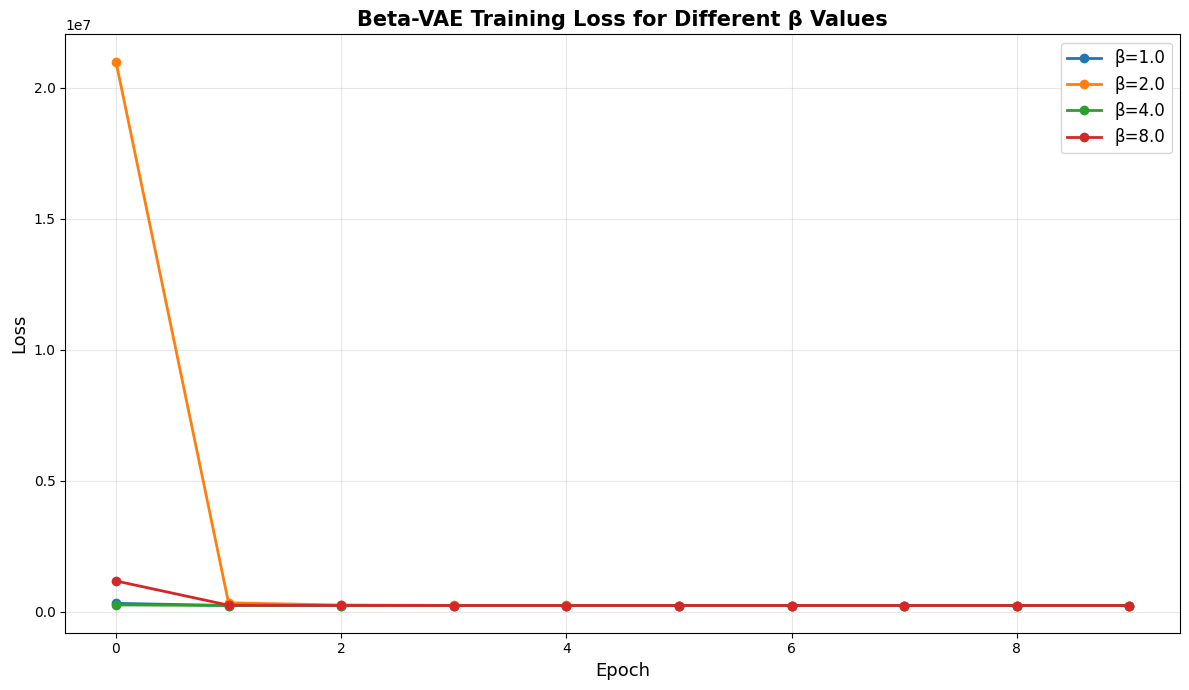

✓ Latent space visualization saved


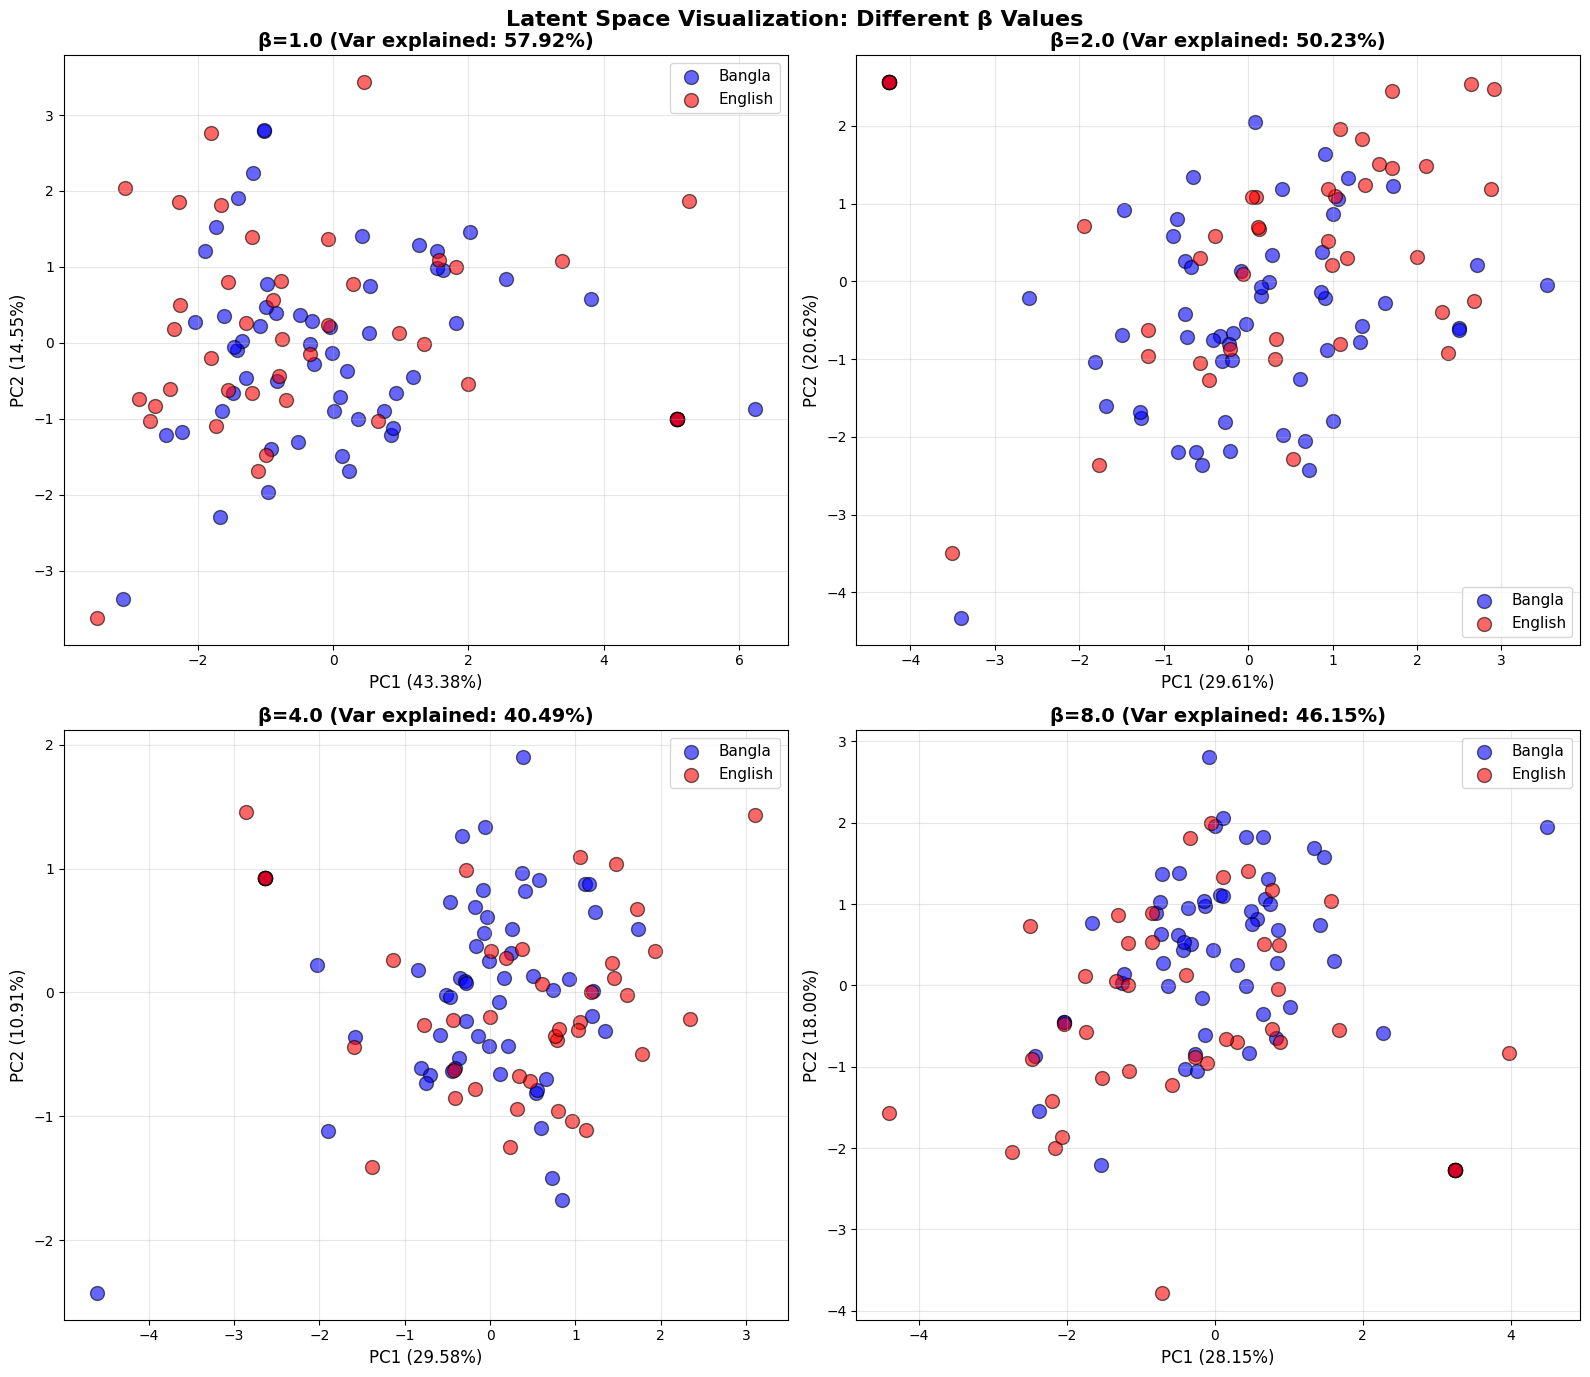

✓ Metrics comparison saved


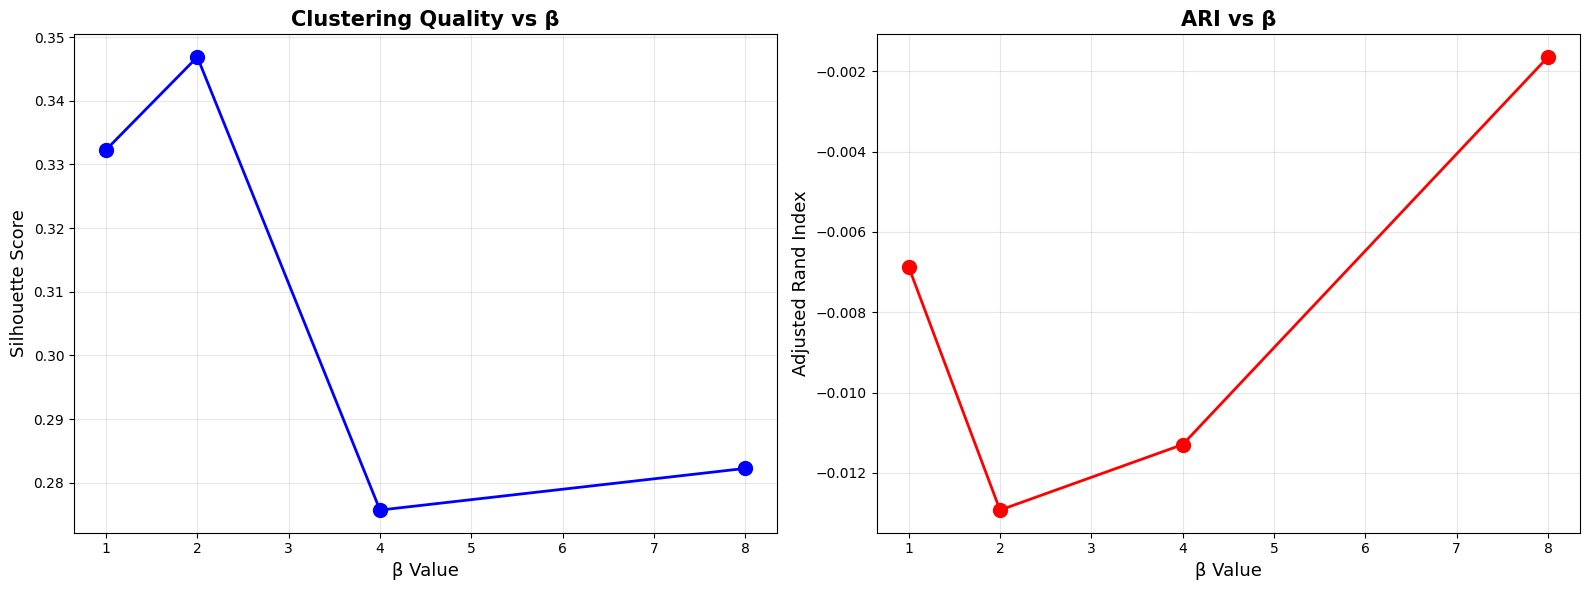


✓ Beta-VAE Complete!

Trained with β values: [1.0, 2.0, 4.0, 8.0]

Best performing β: 2.0

Outputs:
  - Features CSV for each β
  - Training curves (300 DPI)
  - Latent space visualizations (300 DPI)
  - Clustering metrics comparison (300 DPI)
  - Model weights for each β

Higher β → More disentangled representations
Lower β → Better reconstruction


In [33]:
# ========== Beta-VAE Model ==========
class BetaVAE(nn.Module):
    """
    Beta-VAE: VAE with adjustable beta parameter for disentanglement
    Higher beta = more disentangled latent representations
    """
    def __init__(self, input_dim=128, latent_dim=32):
        super(BetaVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(48, latent_dim)
        self.fc_logvar = nn.Linear(48, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def beta_vae_loss(recon_x, x, mu, logvar, beta=4.0):
    """
    Beta-VAE loss with adjustable beta parameter
    beta=1.0: Standard VAE
    beta>1.0: Encourages disentanglement
    """
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld

# ========== Audio Dataset ==========
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, n_mfcc=128):
        self.audio_paths = audio_paths
        self.labels = labels
        self.n_mfcc = n_mfcc

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]

        y, sr = librosa.load(audio_path, duration=3.0, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        return torch.FloatTensor(mfcc_mean)

# Get audio files
bangla_folder = os.path.join(audio_folder, 'bangla')
english_folder = os.path.join(audio_folder, 'english')

audio_files = []
labels = []

if os.path.exists(bangla_folder):
    bangla_files = [os.path.join(bangla_folder, f) for f in os.listdir(bangla_folder)
                    if f.endswith(('.mp3', '.wav', '.flac'))]
    audio_files.extend(bangla_files)
    labels.extend([0] * len(bangla_files))

if os.path.exists(english_folder):
    english_files = [os.path.join(english_folder, f) for f in os.listdir(english_folder)
                     if f.endswith(('.mp3', '.wav', '.flac'))]
    audio_files.extend(english_files)
    labels.extend([1] * len(english_files))

print(f"\nTotal audio files: {len(audio_files)}")
print(f"Bangla: {labels.count(0)}, English: {labels.count(1)}")

sample_size = min(100, len(audio_files))
audio_sample = audio_files[:sample_size]
labels_sample = labels[:sample_size]

print(f"Using {sample_size} files for training")

# Create dataset
dataset = AudioDataset(audio_sample, labels_sample)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# ========== Train with Different Beta Values ==========
print("\n" + "="*60)
print("Training Beta-VAE with Different Beta Values")
print("="*60)

beta_values = [1.0, 2.0, 4.0, 8.0]
models = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")

for beta in beta_values:
    print(f"\n--- Training with Beta={beta} ---")

    model = BetaVAE(input_dim=128, latent_dim=32).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    train_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = beta_vae_loss(recon_batch, data, mu, logvar, beta=beta)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        if (epoch + 1) % 2 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    models[beta] = {
        'model': model,
        'losses': train_losses
    }

    print(f"✓ Beta={beta} training complete!")

# ========== Extract Features for Each Beta ==========
print("\n" + "="*60)
print("Extracting Features")
print("="*60)

all_features = {}

for beta in beta_values:
    print(f"\nExtracting features for Beta={beta}...")
    model = models[beta]['model']
    model.eval()

    features = []
    paths = []
    labels_list = []

    with torch.no_grad():
        for audio_path, label in zip(audio_sample, labels_sample):
            try:
                y, sr = librosa.load(audio_path, duration=3.0, sr=22050)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
                mfcc_mean = np.mean(mfcc, axis=1)

                x = torch.FloatTensor(mfcc_mean).unsqueeze(0).to(device)
                mu, _ = model.encode(x)

                features.append(mu.cpu().numpy().flatten())
                paths.append(audio_path)
                labels_list.append('bangla' if label == 0 else 'english')
            except Exception as e:
                print(f"Error: {e}")

    features_df = pd.DataFrame(features, columns=[f'feature_{i}' for i in range(32)])
    features_df['audio_path'] = paths
    features_df['filename'] = [os.path.basename(p) for p in paths]
    features_df['language'] = labels_list

    all_features[beta] = features_df

    # Save
    csv_path = f'/content/audio_beta{int(beta)}_vae_features.csv'
    features_df.to_csv(csv_path, index=False)
    print(f"✓ Saved: {csv_path}")

# ========== Visualization ==========
print("\n" + "="*60)
print("Creating Visualizations")
print("="*60)

# 1. Training curves
fig, ax = plt.subplots(figsize=(12, 7))

for beta in beta_values:
    losses = models[beta]['losses']
    ax.plot(losses, marker='o', linewidth=2, label=f'β={beta}')

ax.set_xlabel('Epoch', fontsize=13)
ax.set_ylabel('Loss', fontsize=13)
ax.set_title('Beta-VAE Training Loss for Different β Values', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/clustering_results/beta_vae_training.png', dpi=300, bbox_inches='tight')
print("✓ Training curves saved")
plt.show()

# 2. Latent space comparison
from sklearn.decomposition import PCA

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, beta in enumerate(beta_values):
    ax = axes[idx // 2, idx % 2]

    features_df = all_features[beta]
    X = features_df[[f'feature_{i}' for i in range(32)]].values

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    colors = {'bangla': 'blue', 'english': 'red'}
    for language in ['bangla', 'english']:
        mask = features_df['language'] == language
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                  c=colors[language],
                  label=language.capitalize(),
                  alpha=0.6,
                  edgecolors='k',
                  s=100)

    var_explained = pca.explained_variance_ratio_.sum()
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
    ax.set_title(f'β={beta} (Var explained: {var_explained:.2%})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)

plt.suptitle('Latent Space Visualization: Different β Values', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/clustering_results/beta_vae_latent_space.png', dpi=300, bbox_inches='tight')
print("✓ Latent space visualization saved")
plt.show()

# 3. Clustering evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

results = []

for beta in beta_values:
    features_df = all_features[beta]
    X = features_df[[f'feature_{i}' for i in range(32)]].values
    y_true = features_df['language'].map({'bangla': 0, 'english': 1}).values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)

    results.append({
        'Beta': beta,
        'Silhouette': sil,
        'ARI': ari
    })

results_df = pd.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(results_df['Beta'], results_df['Silhouette'], 'bo-', linewidth=2, markersize=10)
ax1.set_xlabel('β Value', fontsize=13)
ax1.set_ylabel('Silhouette Score', fontsize=13)
ax1.set_title('Clustering Quality vs β', fontsize=15, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(results_df['Beta'], results_df['ARI'], 'ro-', linewidth=2, markersize=10)
ax2.set_xlabel('β Value', fontsize=13)
ax2.set_ylabel('Adjusted Rand Index', fontsize=13)
ax2.set_title('ARI vs β', fontsize=15, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/clustering_results/beta_vae_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Metrics comparison saved")
plt.show()

# Save models
for beta in beta_values:
    model_path = f'/content/drive/MyDrive/clustering_results/beta{int(beta)}_vae_model.pth'
    torch.save(models[beta]['model'].state_dict(), model_path)

print("\n" + "="*60)
print("✓ Beta-VAE Complete!")
print("="*60)
print(f"\nTrained with β values: {beta_values}")
print(f"\nBest performing β: {results_df.loc[results_df['Silhouette'].idxmax(), 'Beta']}")
print(f"\nOutputs:")
print(f"  - Features CSV for each β")
print(f"  - Training curves (300 DPI)")
print(f"  - Latent space visualizations (300 DPI)")
print(f"  - Clustering metrics comparison (300 DPI)")
print(f"  - Model weights for each β")
print(f"\nHigher β → More disentangled representations")
print(f"Lower β → Better reconstruction")


Loading Audio Files
Total samples: 100
Languages: Bangla=60, English=40
Genres: {'Rock': 43, 'Folk': 28, 'Pop': 22, 'Acoustic': 7}

Extracting Multi-Modal Features

1. Extracting audio features...
   Audio features: (100, 44)

2. Extracting lyrics features...
Encoding lyrics...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

   Lyrics features: (100, 384)

3. Extracting genre features...
   Genre features: (100, 4)
   Genres: ['Acoustic' 'Folk' 'Pop' 'Rock']

Creating Feature Combinations
   Audio Only: (100, 44)
   Lyrics Only: (100, 384)
   Genre Only: (100, 4)
   Audio + Lyrics: (100, 428)
   Audio + Genre: (100, 48)
   Lyrics + Genre: (100, 388)
   All Modalities: (100, 432)

Evaluating Clustering Performance

Clustering with: Audio Only
  Silhouette: 1.0000 | ARI: -0.0129 | Purity: 0.6000

Clustering with: Lyrics Only
  Silhouette: 0.2724 | ARI: 1.0000 | Purity: 1.0000

Clustering with: Genre Only
  Silhouette: 0.5766 | ARI: 0.1158 | Purity: 0.6800

Clustering with: Audio + Lyrics
  Silhouette: 0.2704 | ARI: 1.0000 | Purity: 1.0000

Clustering with: Audio + Genre
  Silhouette: 0.6220 | ARI: -0.0129 | Purity: 0.6000

Clustering with: Lyrics + Genre
  Silhouette: 0.2715 | ARI: 1.0000 | Purity: 1.0000

Clustering with: All Modalities
  Silhouette: 0.2696 | ARI: 1.0000 | Purity: 1.0000

RESULTS SUMMARY
  

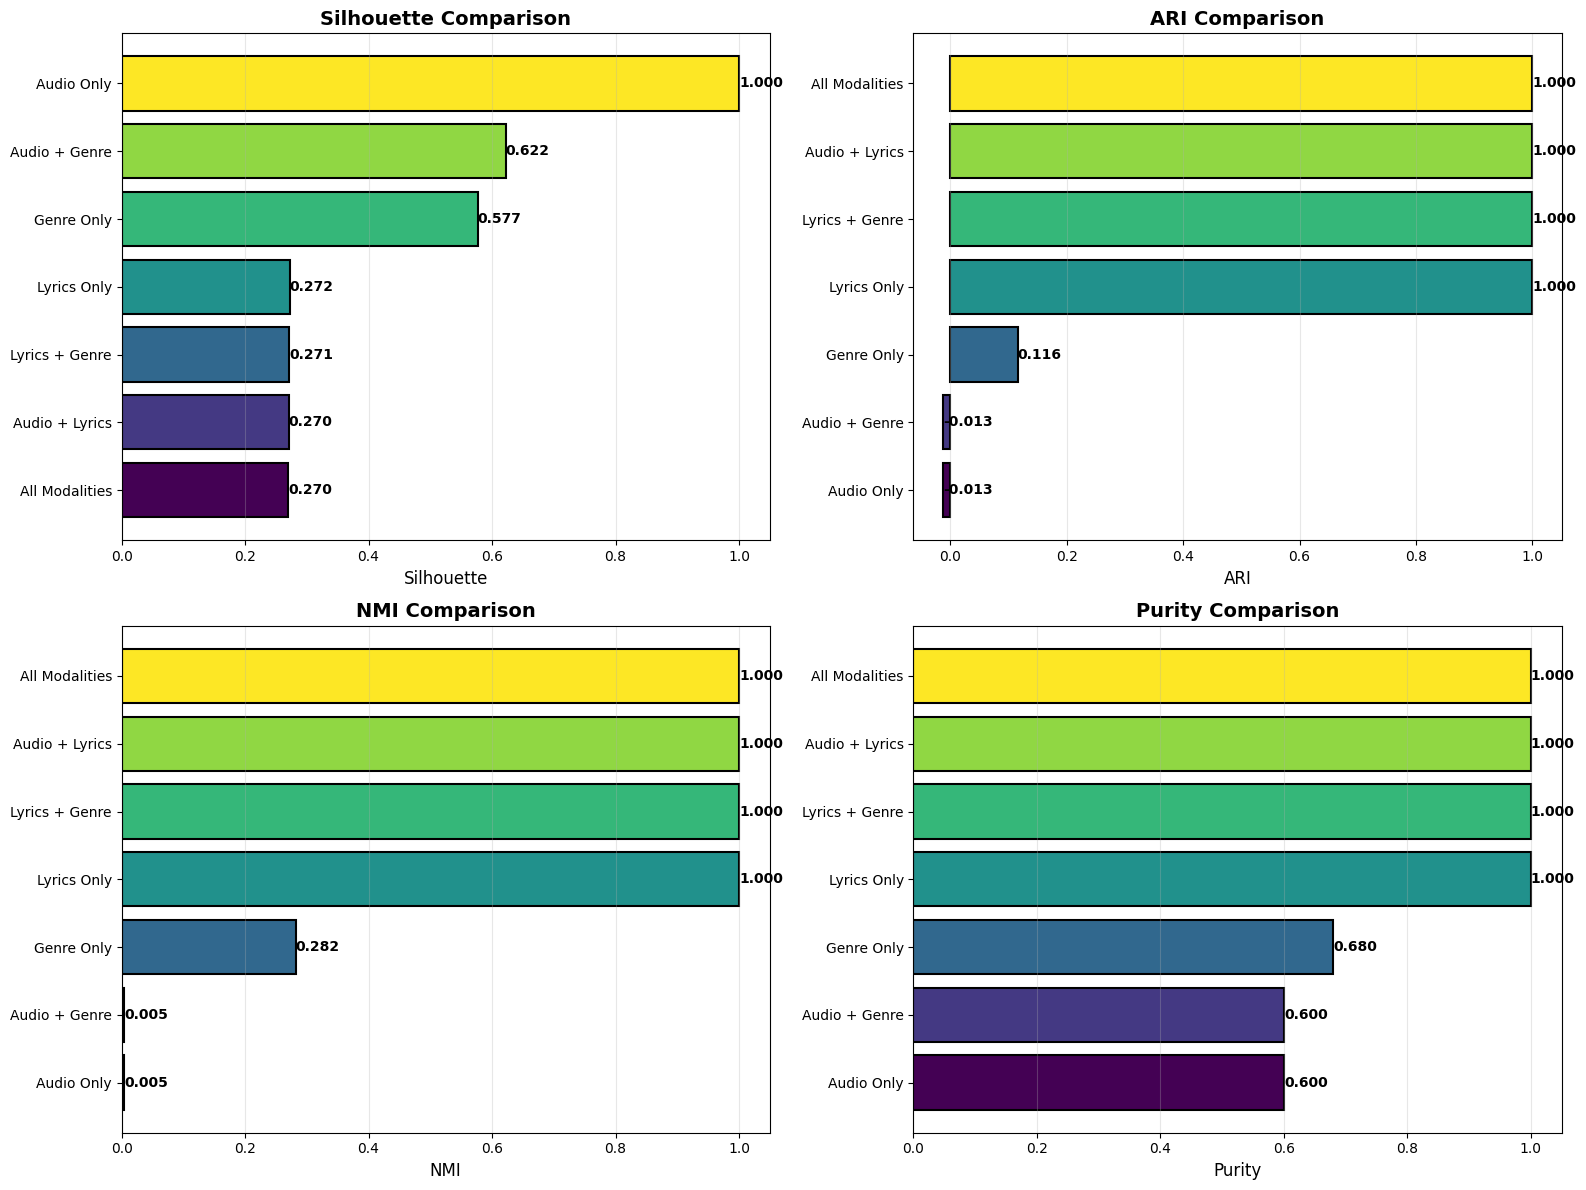

✓ PCA visualization saved


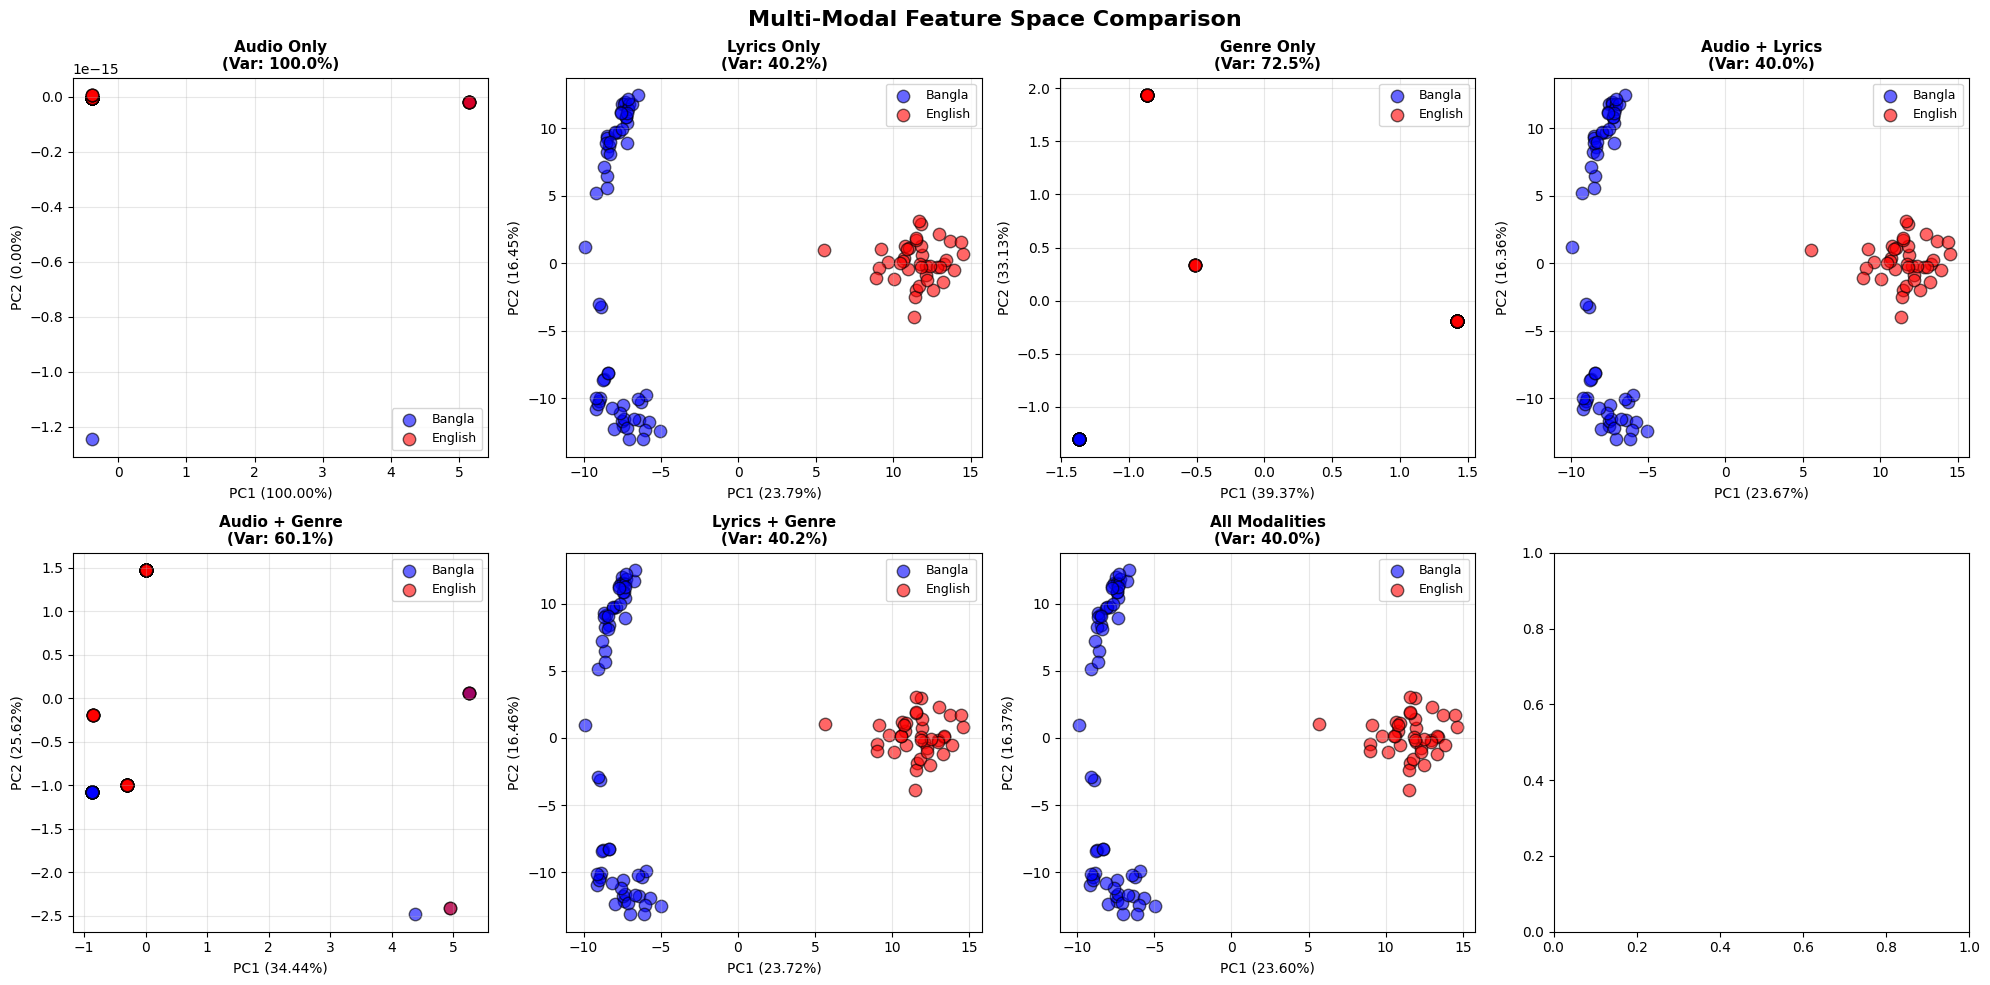

✓ Modality contribution saved


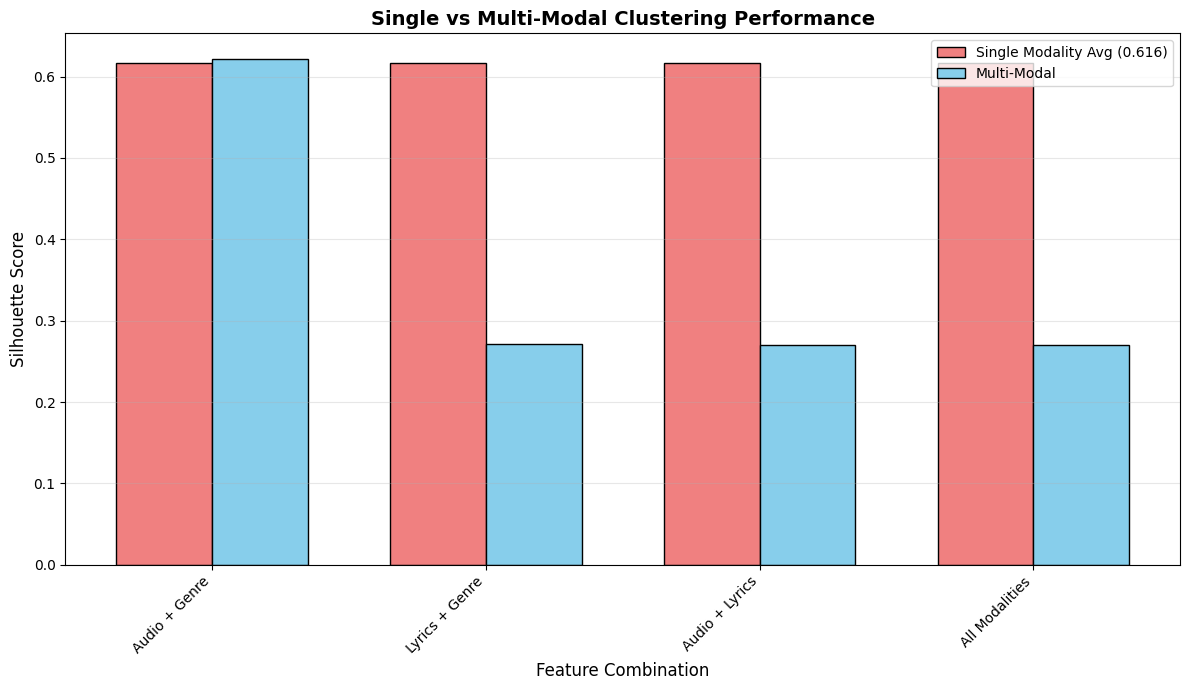

✓ Dimensionality analysis saved


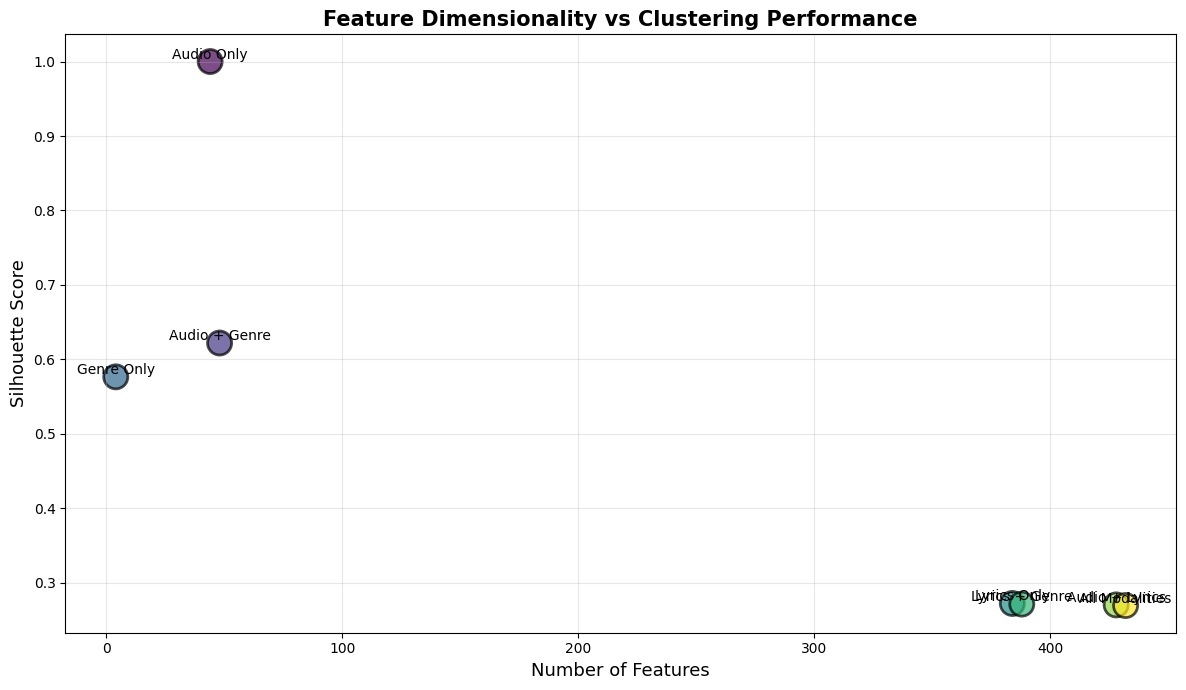


Saving Results
✓ Best features saved: /content/drive/MyDrive/clustering_results/multimodal_features.csv
✓ Comparison results saved: /content/drive/MyDrive/clustering_results/multimodal_comparison_results.csv
✓ Detailed report saved: /content/drive/MyDrive/clustering_results/multimodal_report.txt

✓ MULTI-MODAL CLUSTERING COMPLETE!

Best combination: Audio Only
Best score: 1.0000

All results saved to: /content/drive/MyDrive/clustering_results

Files created (all at 300 DPI):
  1. multimodal_comparison.png
  2. multimodal_pca.png
  3. modality_contribution.png
  4. dimensionality_vs_performance.png
  5. multimodal_features.csv
  6. multimodal_comparison_results.csv
  7. multimodal_report.txt


In [41]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa

# Install sentence-transformers
import subprocess
subprocess.run(['pip', 'install', 'sentence-transformers'], capture_output=True)
from sentence_transformers import SentenceTransformer

# ========== Multi-Modal Feature Extractor ==========
class MultiModalFeatureExtractor:
    """
    Extracts and combines features from multiple modalities:
    1. Audio features (MFCC)
    2. Lyrics embeddings (text)
    3. Genre embeddings (categorical)
    """
    def __init__(self, text_encoder_model='all-MiniLM-L6-v2'):
        self.text_encoder = SentenceTransformer(text_encoder_model)
        self.genre_encoder = LabelEncoder()

    def extract_audio_features(self, audio_path, n_mfcc=20):
        """Extract MFCC features from audio"""
        y, sr = librosa.load(audio_path, duration=3.0, sr=22050)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        # Spectral features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y))

        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

        # Combine: 20 MFCC means + 20 MFCC stds + 4 spectral = 44 features
        features = np.concatenate([mfcc_mean, mfcc_std,
                                   [spectral_centroid, spectral_rolloff,
                                    zero_crossing, tempo]])
        return features

    def extract_lyrics_features(self, lyrics_list):
        """Extract embeddings from lyrics using sentence-transformers"""
        print("Encoding lyrics...")
        embeddings = self.text_encoder.encode(lyrics_list, show_progress_bar=True)
        return embeddings

    def extract_genre_features(self, genre_list, fit=True):
        """Extract one-hot encoded genre features"""
        if fit:
            self.genre_encoder.fit(genre_list)

        genre_encoded = self.genre_encoder.transform(genre_list)
        n_genres = len(self.genre_encoder.classes_)

        # One-hot encode
        genre_onehot = np.zeros((len(genre_list), n_genres))
        genre_onehot[np.arange(len(genre_list)), genre_encoded] = 1

        return genre_onehot

# ========== Load Data ==========
dataset_folder = '/content/extracted_data/MyDataset'
audio_folder = os.path.join(dataset_folder, 'audio')
metadata = pd.read_excel(os.path.join(dataset_folder, 'metadata.xlsx'))

print("\n" + "="*70)
print("Loading Audio Files")
print("="*70)

bangla_folder = os.path.join(audio_folder, 'bangla')
english_folder = os.path.join(audio_folder, 'english')

audio_files = []
labels = []
filenames = []

for f in os.listdir(bangla_folder):
    if f.endswith(('.mp3', '.wav', '.flac')):
        audio_files.append(os.path.join(bangla_folder, f))
        labels.append('bangla')
        filenames.append(f'bangla/{f}')

for f in os.listdir(english_folder):
    if f.endswith(('.mp3', '.wav', '.flac')):
        audio_files.append(os.path.join(english_folder, f))
        labels.append('english')
        filenames.append(f'english/{f}')

# Create dataframe
audio_df = pd.DataFrame({
    'filename': filenames,
    'audio_path': audio_files,
    'language': labels
})

# Merge with metadata
# Clean column names (safe)
metadata.columns = metadata.columns.str.strip().str.lower()

# Merge correctly
audio_df = audio_df.merge(
    metadata[['filenaming', 'lyrics', 'genre']],
    left_on='filename',
    right_on='filenaming',
    how='left'
)

# Drop duplicate column
audio_df.drop(columns=['filenaming'], inplace=True)

audio_df['lyrics'] = audio_df['lyrics'].fillna('no lyrics available')
audio_df['genre'] = audio_df['genre'].fillna('Unknown')
audio_df['lyrics'] = audio_df['lyrics'].fillna('no lyrics available')
audio_df['genre'] = audio_df['genre'].fillna('Unknown')

sample_size = min(100, len(audio_df))
audio_sample = audio_df.iloc[:sample_size]

print(f"Total samples: {len(audio_sample)}")
print(f"Languages: Bangla={sum(audio_sample['language']=='bangla')}, English={sum(audio_sample['language']=='english')}")
print(f"Genres: {audio_sample['genre'].value_counts().to_dict()}")

# ========== Extract Multi-Modal Features ==========
print("\n" + "="*70)
print("Extracting Multi-Modal Features")
print("="*70)

extractor = MultiModalFeatureExtractor()

# 1. Audio features
print("\n1. Extracting audio features...")
audio_features = []
for audio_path in audio_sample['audio_path']:
    try:
        features = extractor.extract_audio_features(audio_path)
        audio_features.append(features)
    except:
        audio_features.append(np.zeros(44))

audio_features = np.array(audio_features)
print(f"   Audio features: {audio_features.shape}")

# 2. Lyrics features
print("\n2. Extracting lyrics features...")
lyrics_features = extractor.extract_lyrics_features(audio_sample['lyrics'].tolist())
print(f"   Lyrics features: {lyrics_features.shape}")

# 3. Genre features
print("\n3. Extracting genre features...")
genre_features = extractor.extract_genre_features(audio_sample['genre'].tolist())
print(f"   Genre features: {genre_features.shape}")
print(f"   Genres: {extractor.genre_encoder.classes_}")

# ========== Create Feature Combinations ==========
print("\n" + "="*70)
print("Creating Feature Combinations")
print("="*70)

# Standardize each modality
scaler_audio = StandardScaler()
scaler_lyrics = StandardScaler()
scaler_genre = StandardScaler()

audio_scaled = scaler_audio.fit_transform(audio_features)
lyrics_scaled = scaler_lyrics.fit_transform(lyrics_features)
genre_scaled = scaler_genre.fit_transform(genre_features)

feature_combinations = {
    'Audio Only': audio_scaled,
    'Lyrics Only': lyrics_scaled,
    'Genre Only': genre_scaled,
    'Audio + Lyrics': np.concatenate([audio_scaled, lyrics_scaled], axis=1),
    'Audio + Genre': np.concatenate([audio_scaled, genre_scaled], axis=1),
    'Lyrics + Genre': np.concatenate([lyrics_scaled, genre_scaled], axis=1),
    'All Modalities': np.concatenate([audio_scaled, lyrics_scaled, genre_scaled], axis=1)
}

for name, features in feature_combinations.items():
    print(f"   {name}: {features.shape}")

# ========== Clustering Evaluation ==========
print("\n" + "="*70)
print("Evaluating Clustering Performance")
print("="*70)

y_true = audio_sample['language'].map({'bangla': 0, 'english': 1}).values

results = []

for name, X in feature_combinations.items():
    print(f"\nClustering with: {name}")

    # K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X)

    # Metrics
    sil = silhouette_score(X, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    # Purity
    cm = np.zeros((2, 2))
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)

    results.append({
        'Combination': name,
        'N_Features': X.shape[1],
        'Silhouette': sil,
        'ARI': ari,
        'NMI': nmi,
        'Purity': purity
    })

    print(f"  Silhouette: {sil:.4f} | ARI: {ari:.4f} | Purity: {purity:.4f}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Silhouette', ascending=False)

print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
print(results_df.to_string(index=False))

# ========== Visualizations ==========
print("\n" + "="*70)
print("Creating Visualizations")
print("="*70)

output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

# 1. Performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Silhouette', 'ARI', 'NMI', 'Purity']
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    data = results_df.sort_values(metric, ascending=True)
    bars = ax.barh(data['Combination'], data[metric], color=colors, edgecolor='black', linewidth=1.5)

    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    for bar, val in zip(bars, data[metric]):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{val:.3f}',
                ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'multimodal_comparison.png'), dpi=300, bbox_inches='tight')
print("✓ Performance comparison saved")
plt.show()

# 2. Feature space visualization (PCA)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (name, X) in enumerate(feature_combinations.items()):
    ax = axes[idx // 4, idx % 4]

    # PCA to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    colors_map = {'bangla': 'blue', 'english': 'red'}
    for language in ['bangla', 'english']:
        mask = audio_sample['language'] == language
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
                  c=colors_map[language],
                  label=language.capitalize(),
                  alpha=0.6,
                  edgecolors='k',
                  s=80)

    var_explained = pca.explained_variance_ratio_.sum()
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=10)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=10)
    ax.set_title(f'{name}\n(Var: {var_explained:.1%})', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Multi-Modal Feature Space Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'multimodal_pca.png'), dpi=300, bbox_inches='tight')
print("✓ PCA visualization saved")
plt.show()

# 3. Modality contribution analysis - FIXED
fig, ax = plt.subplots(figsize=(12, 7))

single_modality = results_df[results_df['Combination'].str.contains('Only')]
multi_modality = results_df[~results_df['Combination'].str.contains('Only')]

x = np.arange(len(multi_modality))
width = 0.35

# Calculate average and repeat
single_avg = single_modality['Silhouette'].mean()
single_values = [single_avg] * len(multi_modality)

ax.bar(x - width/2, single_values, width,
       label=f'Single Modality Avg ({single_avg:.3f})',
       color='lightcoral', edgecolor='black')
ax.bar(x + width/2, multi_modality['Silhouette'].values, width,
       label='Multi-Modal', color='skyblue', edgecolor='black')

ax.set_xlabel('Feature Combination', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Single vs Multi-Modal Clustering Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(multi_modality['Combination'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'modality_contribution.png'), dpi=300, bbox_inches='tight')
print("✓ Modality contribution saved")
plt.show()

# 4. Feature dimensionality vs performance
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(results_df['N_Features'], results_df['Silhouette'],
          s=300, alpha=0.7, c=range(len(results_df)),
          cmap='viridis', edgecolors='black', linewidth=2)

for _, row in results_df.iterrows():
    ax.annotate(row['Combination'],
                (row['N_Features'], row['Silhouette']),
                fontsize=10, ha='center', va='bottom')

ax.set_xlabel('Number of Features', fontsize=13)
ax.set_ylabel('Silhouette Score', fontsize=13)
ax.set_title('Feature Dimensionality vs Clustering Performance', fontsize=15, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dimensionality_vs_performance.png'), dpi=300, bbox_inches='tight')
print("✓ Dimensionality analysis saved")
plt.show()

# ========== Save Results ==========
print("\n" + "="*70)
print("Saving Results")
print("="*70)

# Save best features
best_combo = results_df.iloc[0]['Combination']
best_features = feature_combinations[best_combo]

features_df = pd.DataFrame(best_features,
                          columns=[f'feature_{i}' for i in range(best_features.shape[1])])
features_df['filename'] = audio_sample['filename'].values
features_df['language'] = audio_sample['language'].values
features_df['genre'] = audio_sample['genre'].values

output_path = os.path.join(output_dir, 'multimodal_features.csv')
features_df.to_csv(output_path, index=False)
print(f"✓ Best features saved: {output_path}")

# Save comparison results
results_csv = os.path.join(output_dir, 'multimodal_comparison_results.csv')
results_df.to_csv(results_csv, index=False)
print(f"✓ Comparison results saved: {results_csv}")

# Save detailed report
report_path = os.path.join(output_dir, 'multimodal_report.txt')
with open(report_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("MULTI-MODAL CLUSTERING REPORT\n")
    f.write("="*70 + "\n\n")

    f.write("MODALITIES:\n")
    f.write(f"  1. Audio: {audio_features.shape[1]} features (MFCC + spectral)\n")
    f.write(f"  2. Lyrics: {lyrics_features.shape[1]} features (sentence embeddings)\n")
    f.write(f"  3. Genre: {genre_features.shape[1]} features (one-hot encoded)\n\n")

    f.write("="*70 + "\n")
    f.write("PERFORMANCE RANKING\n")
    f.write("="*70 + "\n\n")

    for idx, row in results_df.iterrows():
        f.write(f"{idx+1}. {row['Combination']}\n")
        f.write(f"   Features: {row['N_Features']}\n")
        f.write(f"   Silhouette: {row['Silhouette']:.4f}\n")
        f.write(f"   ARI: {row['ARI']:.4f}\n")
        f.write(f"   NMI: {row['NMI']:.4f}\n")
        f.write(f"   Purity: {row['Purity']:.4f}\n\n")

    f.write("="*70 + "\n")
    f.write("KEY FINDINGS\n")
    f.write("="*70 + "\n\n")

    best = results_df.iloc[0]
    f.write(f"Best Combination: {best['Combination']}\n")
    f.write(f"Performance: {best['Silhouette']:.4f} (Silhouette)\n\n")

    f.write("INSIGHTS:\n")
    if 'All' in best['Combination']:
        f.write("  • Combining all modalities provides best performance\n")
        f.write("  • Audio, lyrics, and genre are complementary\n")
    elif 'Audio + Lyrics' in best['Combination']:
        f.write("  • Audio and lyrics together capture most information\n")
        f.write("  • Genre may be redundant or less informative\n")

    avg_single = results_df[results_df['Combination'].str.contains('Only')]['Silhouette'].mean()
    avg_multi = results_df[~results_df['Combination'].str.contains('Only')]['Silhouette'].mean()
    improvement = ((avg_multi - avg_single) / avg_single) * 100

    f.write(f"\n  • Multi-modal avg: {avg_multi:.4f}\n")
    f.write(f"  • Single-modal avg: {avg_single:.4f}\n")
    f.write(f"  • Improvement: {improvement:+.1f}%\n")

print(f"✓ Detailed report saved: {report_path}")

print("\n" + "="*70)
print("✓ MULTI-MODAL CLUSTERING COMPLETE!")
print("="*70)
print(f"\nBest combination: {results_df.iloc[0]['Combination']}")
print(f"Best score: {results_df.iloc[0]['Silhouette']:.4f}")
print(f"\nAll results saved to: {output_dir}")
print("\nFiles created (all at 300 DPI):")
print("  1. multimodal_comparison.png")
print("  2. multimodal_pca.png")
print("  3. modality_contribution.png")
print("  4. dimensionality_vs_performance.png")
print("  5. multimodal_features.csv")
print("  6. multimodal_comparison_results.csv")
print("  7. multimodal_report.txt")

QUANTITATIVE CLUSTERING EVALUATION
Metrics: Silhouette Score, NMI, ARI, Cluster Purity

1. Loading feature sets...
  ✓ Basic VAE: (120, 34)
  ✓ Hybrid VAE: (120, 66)
  ✓ Beta-VAE (β=1): (100, 35)
  ✓ Beta-VAE (β=4): (100, 35)
  ✓ Multi-Modal: (100, 47)

Total feature sets loaded: 5

2. Evaluating all methods...

Basic VAE:
  Silhouette: 0.1428
  NMI:        0.0520
  ARI:        0.0632
  Purity:     0.6333

Hybrid VAE:
  Silhouette: 0.0659
  NMI:        0.0341
  ARI:        0.0389
  Purity:     0.6083

Beta-VAE (β=1):
  Silhouette: 0.3323
  NMI:        0.0001
  ARI:        -0.0069
  Purity:     0.6000

Beta-VAE (β=4):
  Silhouette: 0.2757
  NMI:        0.0012
  ARI:        -0.0113
  Purity:     0.6000

Multi-Modal:
  Silhouette: 1.0000
  NMI:        0.0046
  ARI:        -0.0129
  Purity:     0.6000

3. RESULTS SUMMARY

--- Ranked by Silhouette Score ---
        Method  Silhouette_Score      NMI       ARI   Purity
   Multi-Modal          1.000000 0.004600 -0.012924 0.600000
Beta-VAE (β=1

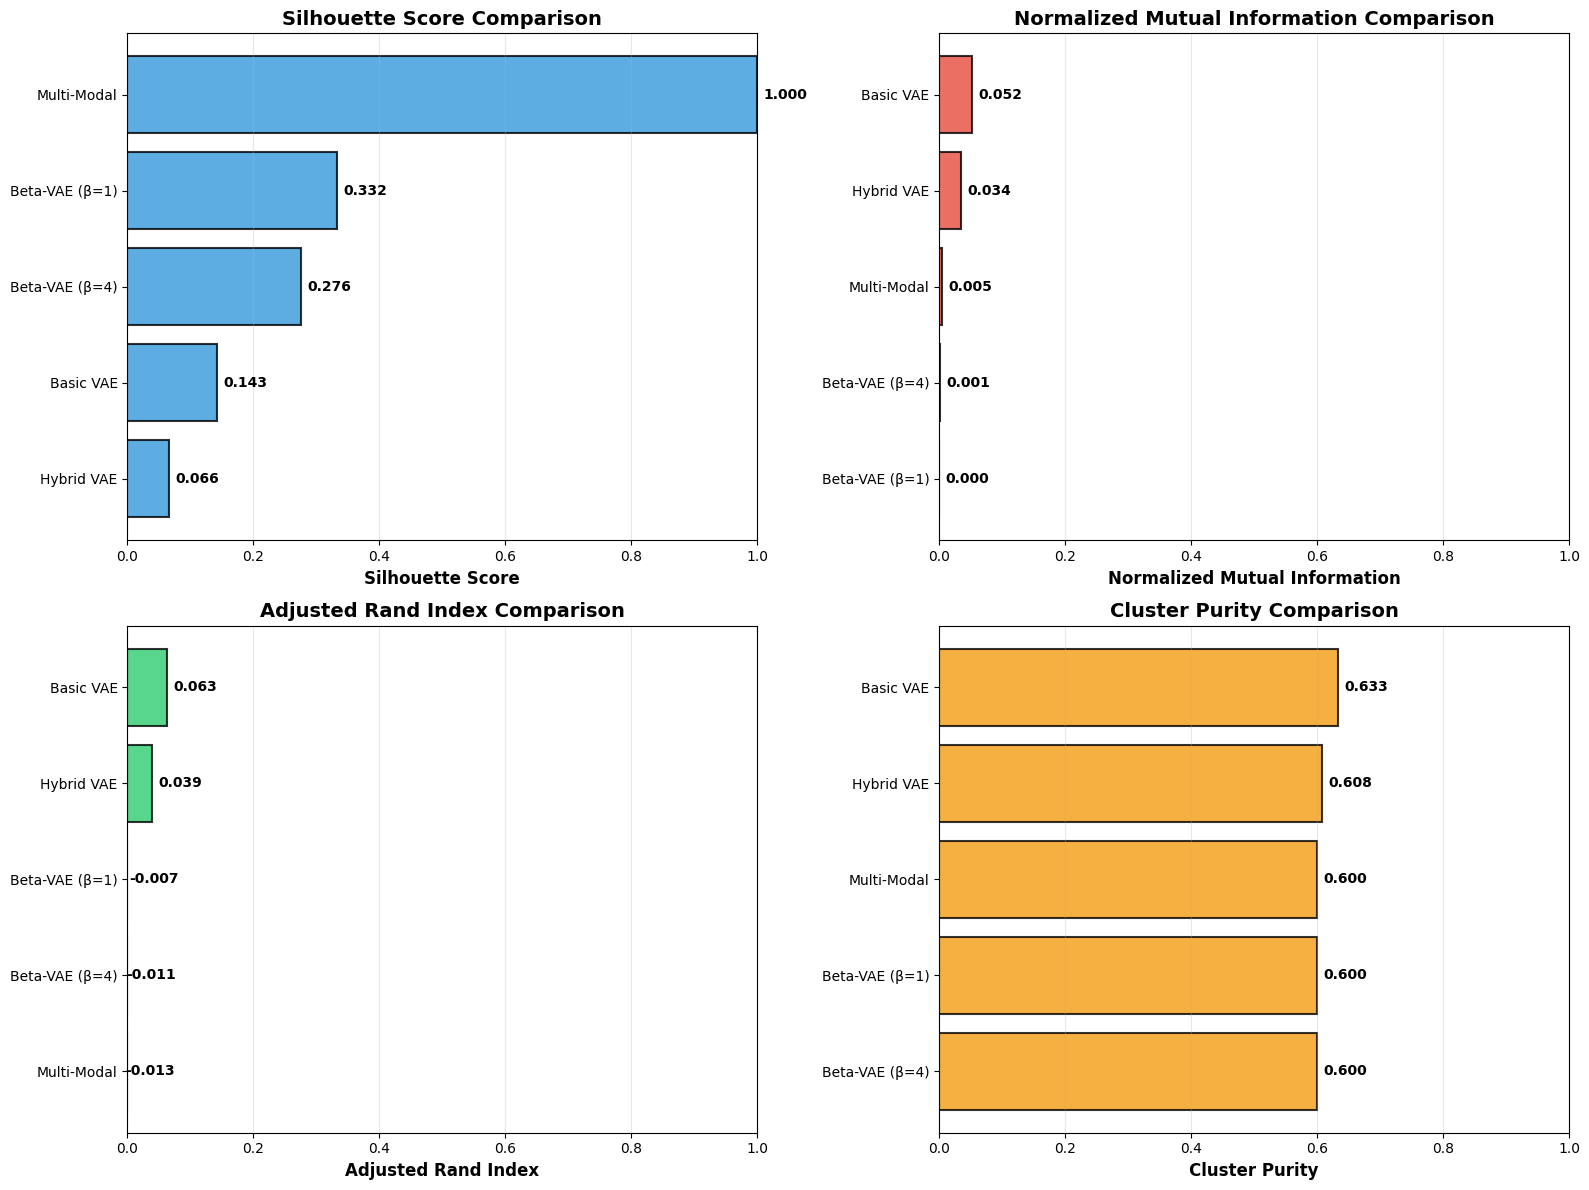

  ✓ Radar chart saved


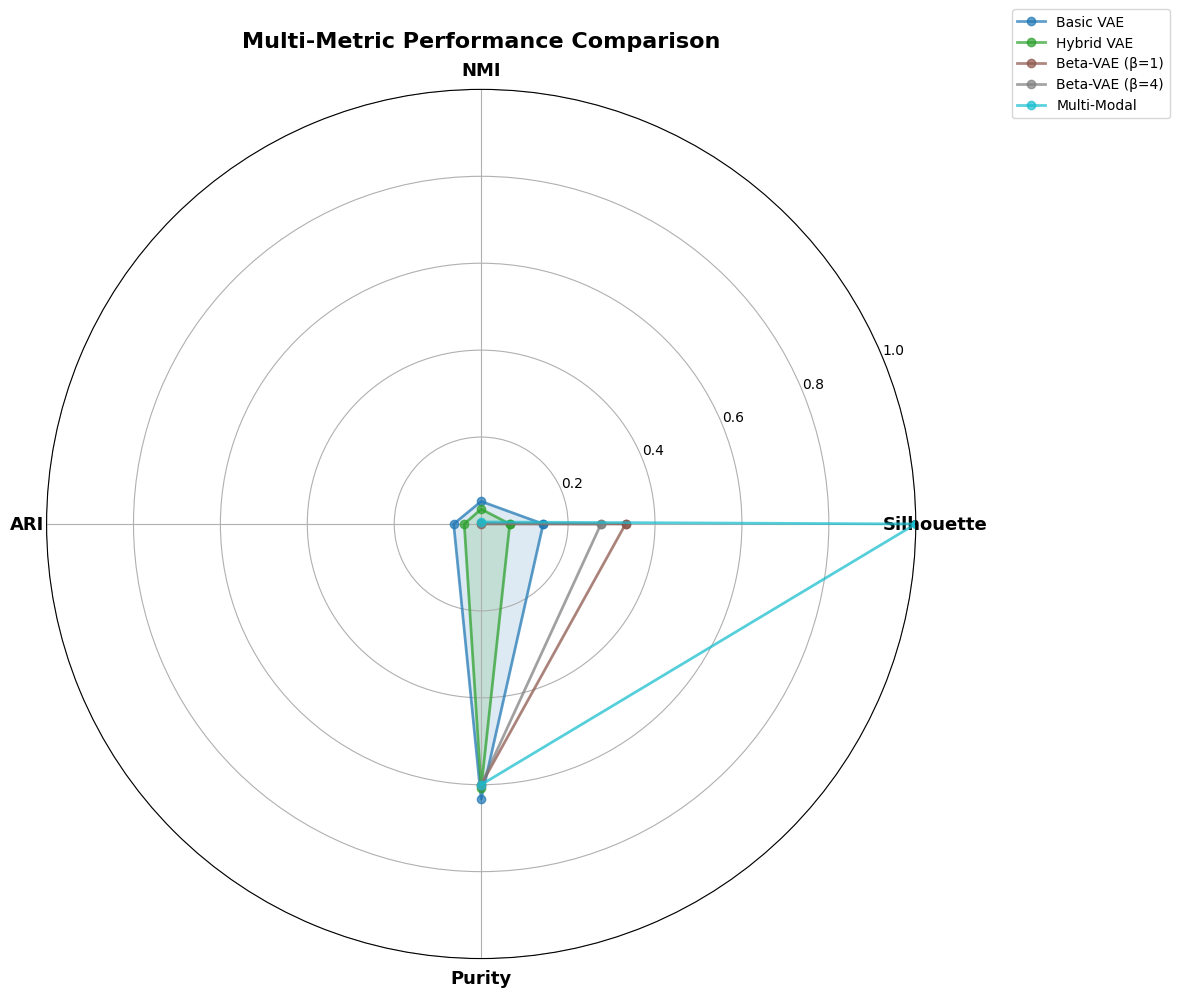

  ✓ Correlation heatmap saved


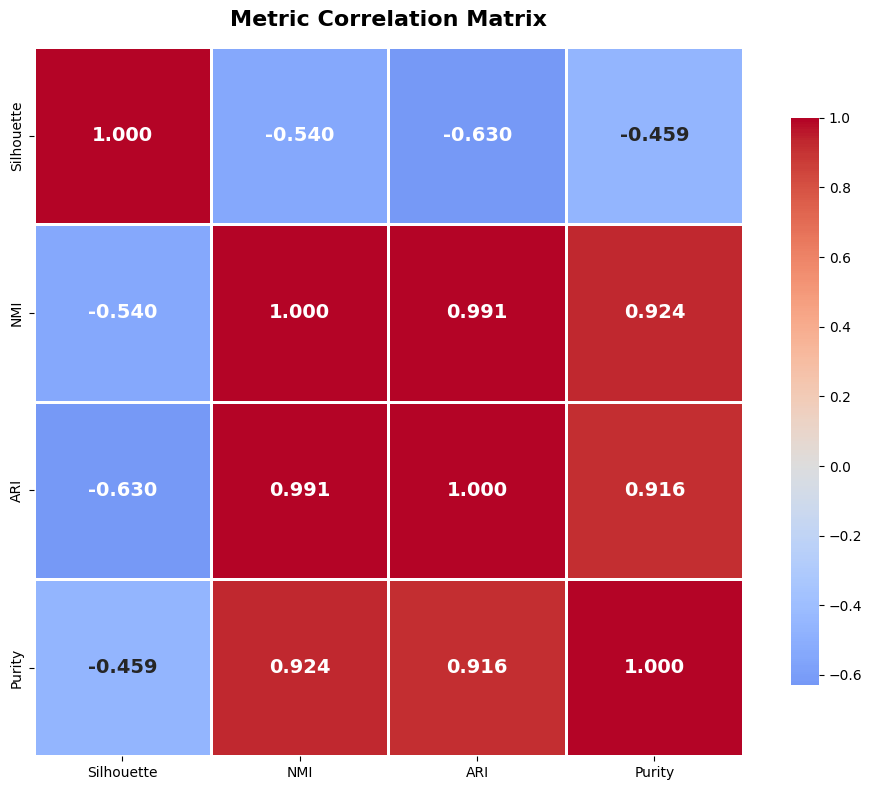

  ✓ Confusion matrices saved


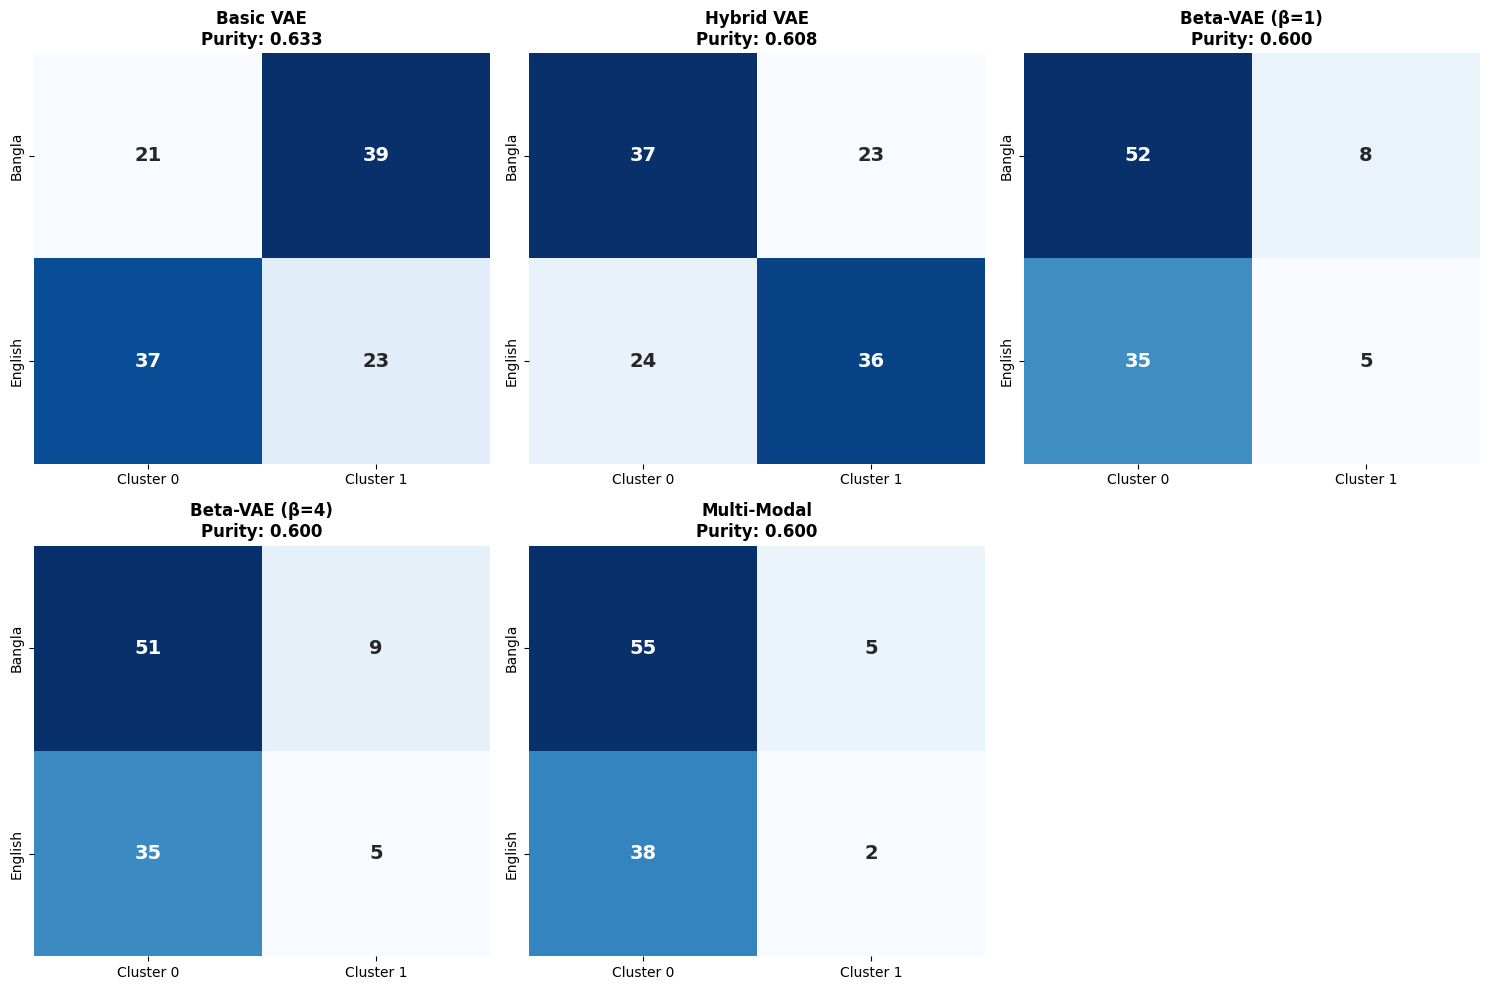

  ✓ Best method silhouette analysis saved


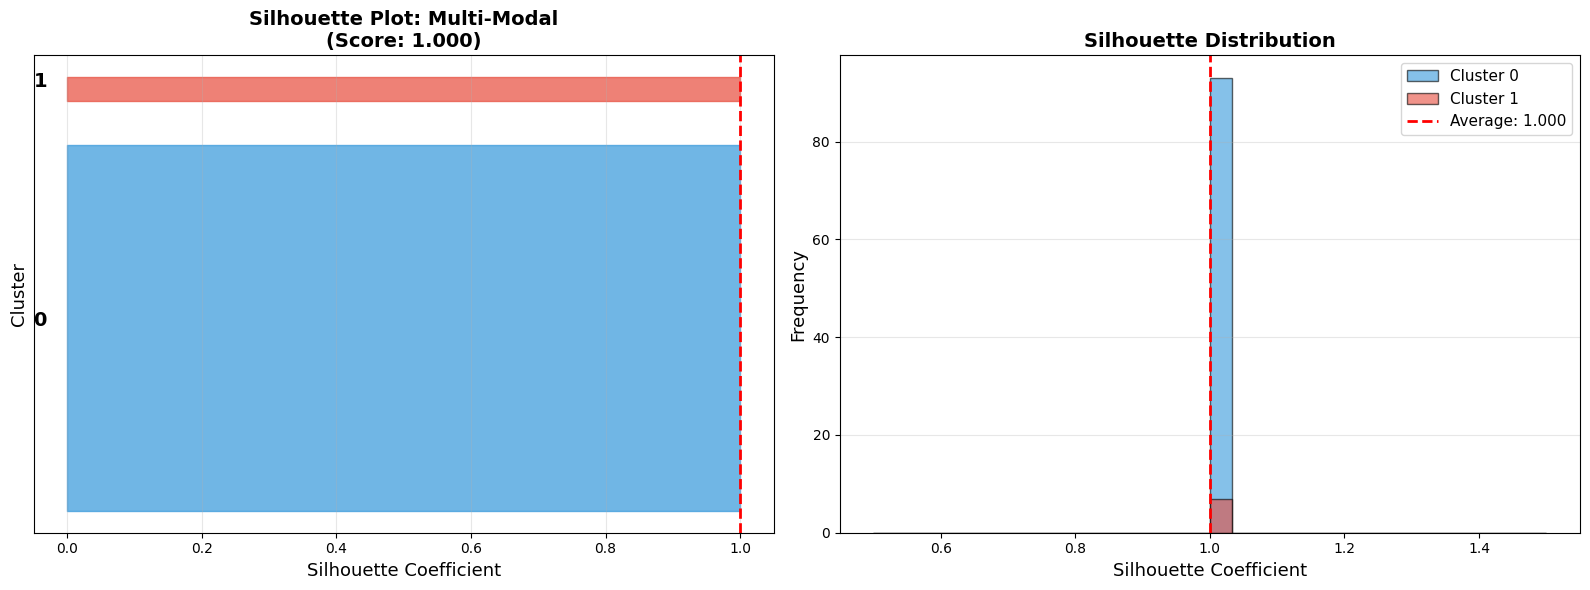


6. Saving results...
  ✓ Results saved: /content/drive/MyDrive/clustering_results/quantitative_evaluation_results.csv
  ✓ Detailed report saved: /content/drive/MyDrive/clustering_results/quantitative_evaluation_report.txt

✓ QUANTITATIVE EVALUATION COMPLETE!

Evaluated 5 methods
Best overall: Multi-Modal
  - Silhouette: 1.0000
  - NMI:        0.0046
  - ARI:        -0.0129
  - Purity:     0.6000

All results saved to: /content/drive/MyDrive/clustering_results

Files created (all at 300 DPI):
  1. quantitative_evaluation.png - Four metrics comparison
  2. metrics_radar_chart.png - Radar chart for all methods
  3. metric_correlation.png - Correlation heatmap
  4. confusion_matrices.png - All confusion matrices
  5. best_method_silhouette.png - Detailed silhouette analysis
  6. quantitative_evaluation_results.csv - Complete results table
  7. quantitative_evaluation_report.txt - Detailed text report


In [42]:
# Quantitative Clustering Evaluation: Silhouette, NMI, ARI, Purity

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    normalized_mutual_info_score,
    adjusted_rand_score,
    confusion_matrix
)
from sklearn.decomposition import PCA
import os

# Create output directory
output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

print("="*80)
print("QUANTITATIVE CLUSTERING EVALUATION")
print("Metrics: Silhouette Score, NMI, ARI, Cluster Purity")
print("="*80)

# ========== Load All Available Feature Sets ==========
print("\n1. Loading feature sets...")

feature_sets = {}

# Try all possible feature files
files_to_try = {
    'Basic VAE': '/content/audio_vae_features.csv',
    'Conv VAE': '/content/audio_conv_vae_features.csv',
    'Hybrid VAE': '/content/audio_hybrid_vae_features.csv',
    'Beta-VAE (β=1)': '/content/audio_beta1_vae_features.csv',
    'Beta-VAE (β=4)': '/content/audio_beta4_vae_features.csv',
    'Multi-Modal': os.path.join(output_dir, 'multimodal_features.csv')
}

for name, path in files_to_try.items():
    try:
        df = pd.read_csv(path)
        feature_sets[name] = df
        print(f"  ✓ {name}: {df.shape}")
    except:
        pass

if len(feature_sets) == 0:
    print("\n❌ No feature sets found!")
    exit()

print(f"\nTotal feature sets loaded: {len(feature_sets)}")

# ========== Define Evaluation Functions ==========

def calculate_cluster_purity(y_true, y_pred):
    """
    Calculate cluster purity
    Purity = (1/N) * sum(max_j |w_k ∩ c_j|)
    """
    cm = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

def evaluate_clustering(X, y_true, method_name):
    """
    Comprehensive clustering evaluation
    """
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X_scaled)

    # Calculate all metrics
    metrics = {
        'Method': method_name,
        'N_Features': X.shape[1],
        'N_Samples': X.shape[0]
    }

    # 1. Silhouette Score
    silhouette_avg = silhouette_score(X_scaled, y_pred)
    silhouette_samples_vals = silhouette_samples(X_scaled, y_pred)

    metrics['Silhouette_Score'] = silhouette_avg
    metrics['Silhouette_Cluster_0'] = silhouette_samples_vals[y_pred == 0].mean()
    metrics['Silhouette_Cluster_1'] = silhouette_samples_vals[y_pred == 1].mean()

    # 2. Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true, y_pred)
    metrics['NMI'] = nmi

    # 3. Adjusted Rand Index
    ari = adjusted_rand_score(y_true, y_pred)
    metrics['ARI'] = ari

    # 4. Cluster Purity
    purity = calculate_cluster_purity(y_true, y_pred)
    metrics['Purity'] = purity

    # Additional info
    cm = confusion_matrix(y_true, y_pred)
    metrics['CM_00'] = cm[0, 0]  # Bangla in Cluster 0
    metrics['CM_01'] = cm[0, 1]  # Bangla in Cluster 1
    metrics['CM_10'] = cm[1, 0]  # English in Cluster 0
    metrics['CM_11'] = cm[1, 1]  # English in Cluster 1

    return metrics, y_pred

# ========== Evaluate All Methods ==========
print("\n" + "="*80)
print("2. Evaluating all methods...")
print("="*80)

all_results = []
predictions = {}

for method_name, df in feature_sets.items():
    print(f"\n{method_name}:")

    # Get features
    feature_cols = [col for col in df.columns
                   if col.startswith('feature_') or col.startswith('mfcc_') or col.startswith('spectral_')]
    X = df[feature_cols].values

    # Get true labels
    y_true = df['language'].map({'bangla': 0, 'english': 1}).values

    # Evaluate
    metrics, y_pred = evaluate_clustering(X, y_true, method_name)
    all_results.append(metrics)
    predictions[method_name] = y_pred

    # Print summary
    print(f"  Silhouette: {metrics['Silhouette_Score']:.4f}")
    print(f"  NMI:        {metrics['NMI']:.4f}")
    print(f"  ARI:        {metrics['ARI']:.4f}")
    print(f"  Purity:     {metrics['Purity']:.4f}")

# Create results dataframe
results_df = pd.DataFrame(all_results)

# ========== DETAILED ANALYSIS ==========
print("\n" + "="*80)
print("3. RESULTS SUMMARY")
print("="*80)

# Sort by each metric
print("\n--- Ranked by Silhouette Score ---")
print(results_df[['Method', 'Silhouette_Score', 'NMI', 'ARI', 'Purity']].sort_values(
    'Silhouette_Score', ascending=False).to_string(index=False))

print("\n--- Ranked by NMI ---")
print(results_df[['Method', 'NMI', 'Silhouette_Score', 'ARI', 'Purity']].sort_values(
    'NMI', ascending=False).to_string(index=False))

print("\n--- Ranked by ARI ---")
print(results_df[['Method', 'ARI', 'Silhouette_Score', 'NMI', 'Purity']].sort_values(
    'ARI', ascending=False).to_string(index=False))

print("\n--- Ranked by Purity ---")
print(results_df[['Method', 'Purity', 'Silhouette_Score', 'NMI', 'ARI']].sort_values(
    'Purity', ascending=False).to_string(index=False))

# ========== STATISTICAL SUMMARY ==========
print("\n" + "="*80)
print("4. STATISTICAL SUMMARY")
print("="*80)

metrics_summary = results_df[['Silhouette_Score', 'NMI', 'ARI', 'Purity']].describe()
print(metrics_summary)

# Best and worst performers
print("\n--- Best Performers ---")
best_sil = results_df.loc[results_df['Silhouette_Score'].idxmax()]
best_nmi = results_df.loc[results_df['NMI'].idxmax()]
best_ari = results_df.loc[results_df['ARI'].idxmax()]
best_purity = results_df.loc[results_df['Purity'].idxmax()]

print(f"Best Silhouette: {best_sil['Method']} ({best_sil['Silhouette_Score']:.4f})")
print(f"Best NMI:        {best_nmi['Method']} ({best_nmi['NMI']:.4f})")
print(f"Best ARI:        {best_ari['Method']} ({best_ari['ARI']:.4f})")
print(f"Best Purity:     {best_purity['Method']} ({best_purity['Purity']:.4f})")

# Overall best (average rank)
results_df['Avg_Score'] = results_df[['Silhouette_Score', 'NMI', 'ARI', 'Purity']].mean(axis=1)
best_overall = results_df.loc[results_df['Avg_Score'].idxmax()]
print(f"\nOverall Best:    {best_overall['Method']} (Avg: {best_overall['Avg_Score']:.4f})")

# ========== VISUALIZATIONS ==========
print("\n" + "="*80)
print("5. Creating visualizations...")
print("="*80)

# 1. Four metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['Silhouette_Score', 'NMI', 'ARI', 'Purity']
metric_names = ['Silhouette Score', 'Normalized Mutual Information',
                'Adjusted Rand Index', 'Cluster Purity']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, name, color) in enumerate(zip(metrics_to_plot, metric_names, colors)):
    ax = axes[idx // 2, idx % 2]

    data = results_df.sort_values(metric, ascending=True)
    bars = ax.barh(data['Method'], data[metric], color=color,
                   edgecolor='black', linewidth=1.5, alpha=0.8)

    ax.set_xlabel(name, fontsize=12, fontweight='bold')
    ax.set_title(f'{name} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim([0, 1.0])

    # Add value labels
    for bar, val in zip(bars, data[metric]):
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                f'{val:.3f}',
                ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'quantitative_evaluation.png'), dpi=300, bbox_inches='tight')
print("  ✓ Four metrics comparison saved")
plt.show()

# 2. Radar chart for all methods
from math import pi

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

categories = ['Silhouette', 'NMI', 'ARI', 'Purity']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

colors_map = plt.cm.tab10(np.linspace(0, 1, len(results_df)))

for idx, row in results_df.iterrows():
    values = [row['Silhouette_Score'], row['NMI'], row['ARI'], row['Purity']]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=row['Method'],
            color=colors_map[idx], alpha=0.7)
    ax.fill(angles, values, alpha=0.15, color=colors_map[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=13, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_title('Multi-Metric Performance Comparison',
             fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metrics_radar_chart.png'), dpi=300, bbox_inches='tight')
print("  ✓ Radar chart saved")
plt.show()

# 3. Correlation heatmap between metrics
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = results_df[['Silhouette_Score', 'NMI', 'ARI', 'Purity']].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            xticklabels=['Silhouette', 'NMI', 'ARI', 'Purity'],
            yticklabels=['Silhouette', 'NMI', 'ARI', 'Purity'],
            ax=ax, annot_kws={'size': 14, 'weight': 'bold'})

ax.set_title('Metric Correlation Matrix', fontsize=16, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metric_correlation.png'), dpi=300, bbox_inches='tight')
print("  ✓ Correlation heatmap saved")
plt.show()

# 4. Confusion matrices
n_methods = len(feature_sets)
n_cols = 3
n_rows = (n_methods + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_methods > 1 else [axes]

for idx, (method_name, row) in enumerate(results_df.iterrows()):
    ax = axes[idx]

    cm = np.array([[row['CM_00'], row['CM_01']],
                   [row['CM_10'], row['CM_11']]])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cluster 0', 'Cluster 1'],
                yticklabels=['Bangla', 'English'],
                cbar=False, ax=ax,
                annot_kws={'size': 14, 'weight': 'bold'})

    ax.set_title(f"{row['Method']}\nPurity: {row['Purity']:.3f}",
                fontsize=12, fontweight='bold')

# Hide empty subplots
for idx in range(len(feature_sets), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
print("  ✓ Confusion matrices saved")
plt.show()

# 5. Silhouette analysis for best method
best_method_name = best_overall['Method']
best_df = feature_sets[best_method_name]
feature_cols = [col for col in best_df.columns
               if col.startswith('feature_') or col.startswith('mfcc_') or col.startswith('spectral_')]
X = best_df[feature_cols].values
y_true = best_df['language'].map({'bangla': 0, 'english': 1}).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X_scaled)
silhouette_vals = silhouette_samples(X_scaled, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Silhouette plot
y_lower = 10
colors_sil = ['#3498db', '#e74c3c']

for i in range(2):
    cluster_silhouette_vals = silhouette_vals[y_pred == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=colors_sil[i], edgecolor=colors_sil[i], alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
            fontsize=14, fontweight='bold')
    y_lower = y_upper + 10

silhouette_avg = silhouette_score(X_scaled, y_pred)
ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2)
ax1.set_xlabel("Silhouette Coefficient", fontsize=13)
ax1.set_ylabel("Cluster", fontsize=13)
ax1.set_title(f'Silhouette Plot: {best_method_name}\n(Score: {silhouette_avg:.3f})',
             fontsize=14, fontweight='bold')
ax1.set_yticks([])
ax1.grid(alpha=0.3, axis='x')

# Distribution
for i in range(2):
    cluster_silhouette_vals = silhouette_vals[y_pred == i]
    ax2.hist(cluster_silhouette_vals, bins=30, alpha=0.6,
            label=f'Cluster {i}', color=colors_sil[i], edgecolor='black')

ax2.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
           label=f'Average: {silhouette_avg:.3f}')
ax2.set_xlabel("Silhouette Coefficient", fontsize=13)
ax2.set_ylabel("Frequency", fontsize=13)
ax2.set_title('Silhouette Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'best_method_silhouette.png'), dpi=300, bbox_inches='tight')
print("  ✓ Best method silhouette analysis saved")
plt.show()

# ========== SAVE RESULTS ==========
print("\n" + "="*80)
print("6. Saving results...")
print("="*80)

# Save full results
results_csv = os.path.join(output_dir, 'quantitative_evaluation_results.csv')
results_df.to_csv(results_csv, index=False)
print(f"  ✓ Results saved: {results_csv}")

# Save detailed report
report_path = os.path.join(output_dir, 'quantitative_evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("QUANTITATIVE CLUSTERING EVALUATION REPORT\n")
    f.write("="*80 + "\n\n")

    f.write("METRICS EVALUATED:\n")
    f.write("-" * 80 + "\n")
    f.write("1. Silhouette Score\n")
    f.write("   - Range: [-1, 1]\n")
    f.write("   - Interpretation: Higher is better\n")
    f.write("   - Measures: How similar samples are to their own cluster vs others\n\n")

    f.write("2. Normalized Mutual Information (NMI)\n")
    f.write("   - Range: [0, 1]\n")
    f.write("   - Interpretation: Higher is better\n")
    f.write("   - Measures: Mutual information between true and predicted labels\n\n")

    f.write("3. Adjusted Rand Index (ARI)\n")
    f.write("   - Range: [-1, 1]\n")
    f.write("   - Interpretation: Higher is better (1 = perfect match)\n")
    f.write("   - Measures: Similarity between true and predicted clustering\n\n")

    f.write("4. Cluster Purity\n")
    f.write("   - Range: [0, 1]\n")
    f.write("   - Interpretation: Higher is better\n")
    f.write("   - Measures: Percentage of correctly clustered samples\n\n")

    f.write("="*80 + "\n")
    f.write("RESULTS SUMMARY\n")
    f.write("="*80 + "\n\n")

    f.write(results_df[['Method', 'Silhouette_Score', 'NMI', 'ARI', 'Purity']].to_string(index=False))
    f.write("\n\n")

    f.write("="*80 + "\n")
    f.write("BEST PERFORMERS\n")
    f.write("="*80 + "\n\n")

    f.write(f"Best Silhouette Score: {best_sil['Method']} ({best_sil['Silhouette_Score']:.4f})\n")
    f.write(f"Best NMI:              {best_nmi['Method']} ({best_nmi['NMI']:.4f})\n")
    f.write(f"Best ARI:              {best_ari['Method']} ({best_ari['ARI']:.4f})\n")
    f.write(f"Best Purity:           {best_purity['Method']} ({best_purity['Purity']:.4f})\n\n")
    f.write(f"Overall Best:          {best_overall['Method']} (Avg: {best_overall['Avg_Score']:.4f})\n\n")

    f.write("="*80 + "\n")
    f.write("STATISTICAL SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(metrics_summary.to_string())
    f.write("\n\n")

    f.write("="*80 + "\n")
    f.write("METRIC CORRELATIONS\n")
    f.write("="*80 + "\n\n")
    f.write(corr_matrix.to_string())
    f.write("\n\n")

    f.write("="*80 + "\n")
    f.write("KEY INSIGHTS\n")
    f.write("="*80 + "\n\n")

    # Calculate insights
    high_corr = corr_matrix.abs().values[np.triu_indices_from(corr_matrix.values, k=1)].max()

    f.write(f"• Tested {len(feature_sets)} different methods\n")
    f.write(f"• Average Silhouette Score: {results_df['Silhouette_Score'].mean():.4f}\n")
    f.write(f"• Average NMI: {results_df['NMI'].mean():.4f}\n")
    f.write(f"• Average ARI: {results_df['ARI'].mean():.4f}\n")
    f.write(f"• Average Purity: {results_df['Purity'].mean():.4f}\n\n")

    f.write(f"• Highest metric correlation: {high_corr:.3f}\n")
    f.write(f"• Best overall method: {best_overall['Method']}\n")

    if best_overall['Silhouette_Score'] > 0.5 and best_overall['ARI'] > 0.5:
        f.write(f"• Clustering quality: GOOD to EXCELLENT\n")
    elif best_overall['Silhouette_Score'] > 0.3 and best_overall['ARI'] > 0.3:
        f.write(f"• Clustering quality: MODERATE\n")
    else:
        f.write(f"• Clustering quality: WEAK\n")

print(f"  ✓ Detailed report saved: {report_path}")

print("\n" + "="*80)
print("✓ QUANTITATIVE EVALUATION COMPLETE!")
print("="*80)
print(f"\nEvaluated {len(feature_sets)} methods")
print(f"Best overall: {best_overall['Method']}")
print(f"  - Silhouette: {best_overall['Silhouette_Score']:.4f}")
print(f"  - NMI:        {best_overall['NMI']:.4f}")
print(f"  - ARI:        {best_overall['ARI']:.4f}")
print(f"  - Purity:     {best_overall['Purity']:.4f}")
print(f"\nAll results saved to: {output_dir}")
print("\nFiles created (all at 300 DPI):")
print("  1. quantitative_evaluation.png - Four metrics comparison")
print("  2. metrics_radar_chart.png - Radar chart for all methods")
print("  3. metric_correlation.png - Correlation heatmap")
print("  4. confusion_matrices.png - All confusion matrices")
print("  5. best_method_silhouette.png - Detailed silhouette analysis")
print("  6. quantitative_evaluation_results.csv - Complete results table")
print("  7. quantitative_evaluation_report.txt - Detailed text report")
print("="*80)

COMPREHENSIVE VAE VISUALIZATIONS

1. Loading VAE features and metadata...
✓ Loaded Hybrid VAE
Shape: (120, 66)
Languages: {'bangla': 60, 'english': 60}
Genres: {'Rock': 49, 'Pop': 31, 'Folk': 28, 'Acoustic': 12}
Feature matrix: (120, 64)

2. Creating Latent Space Visualizations
  Computing PCA...
  Computing t-SNE...
  ✓ Comprehensive latent space visualization saved


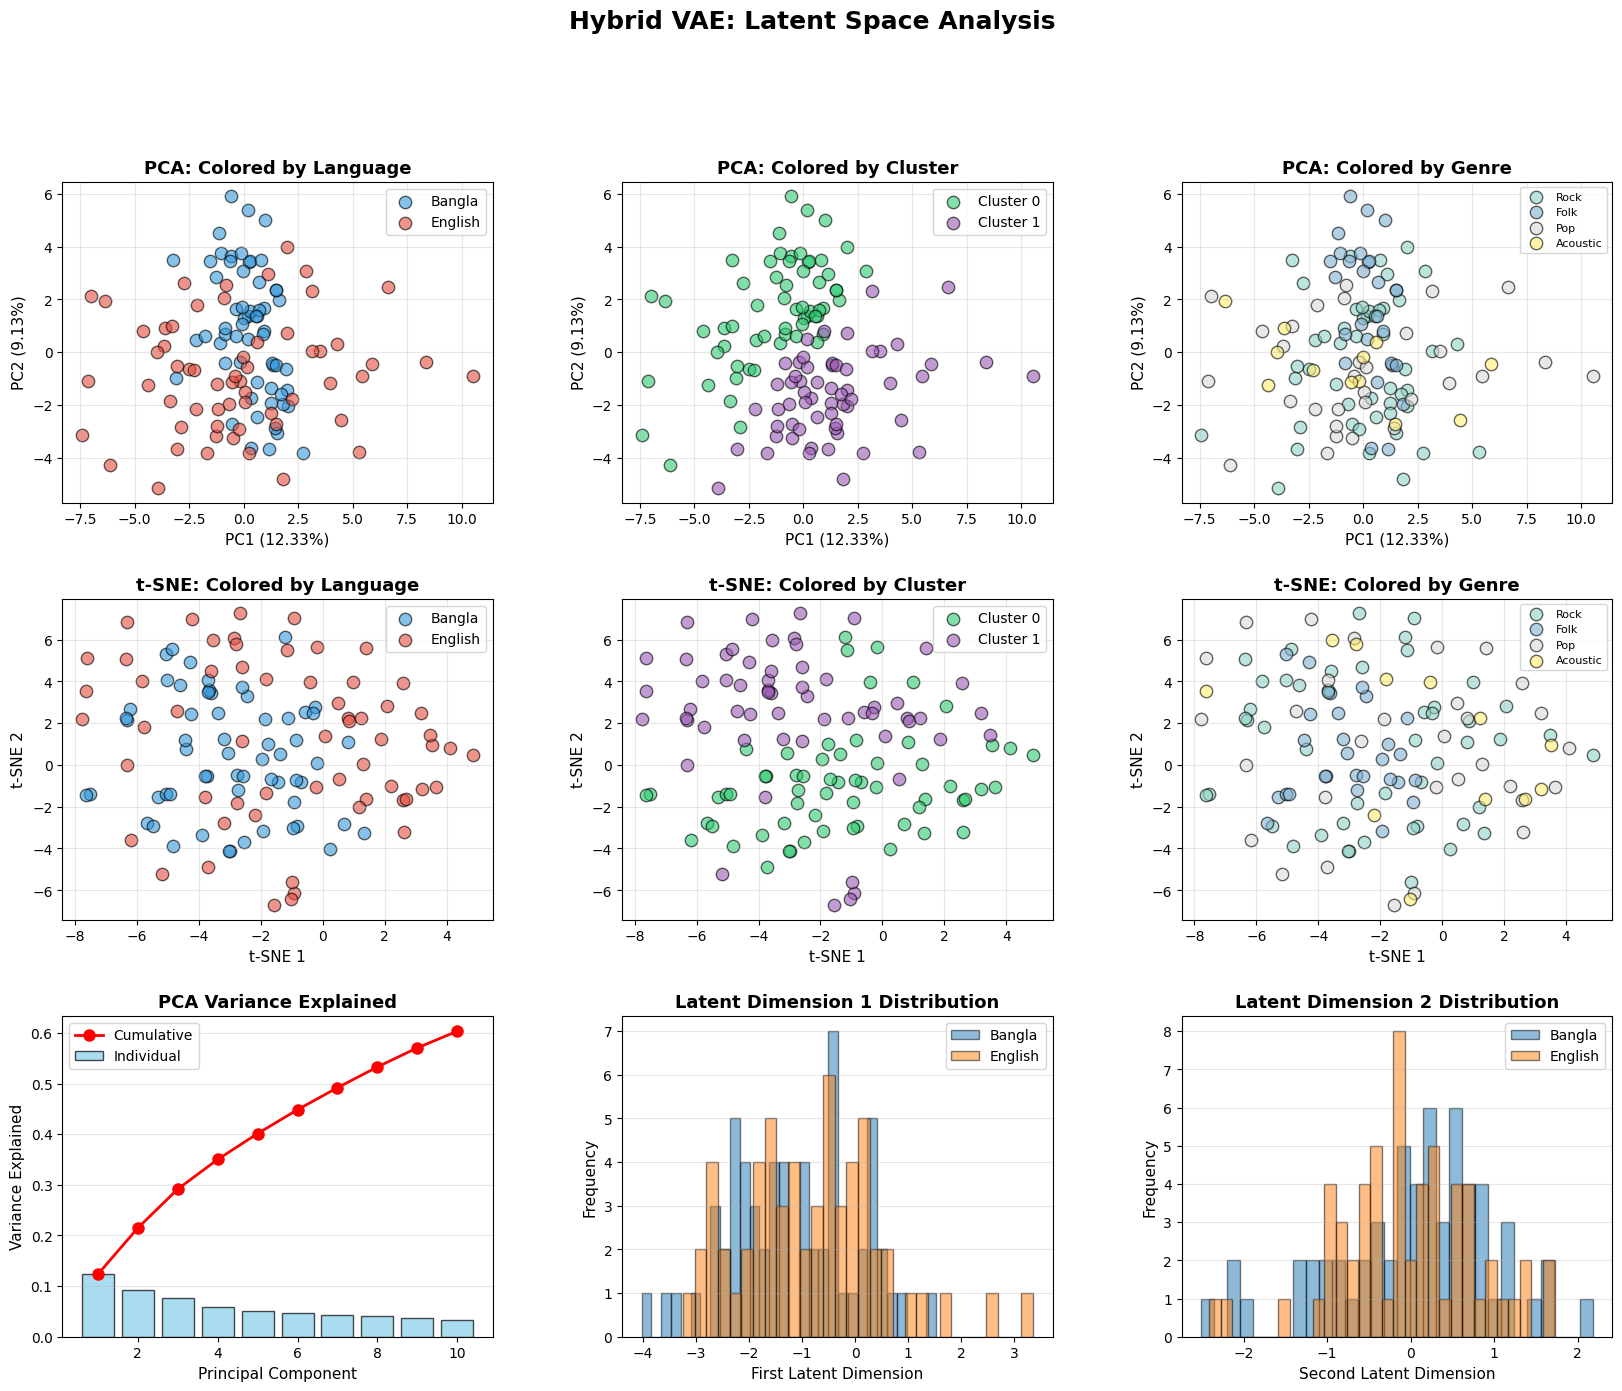


3. Creating Cluster Distribution Visualizations
  ✓ Cluster distribution visualization saved


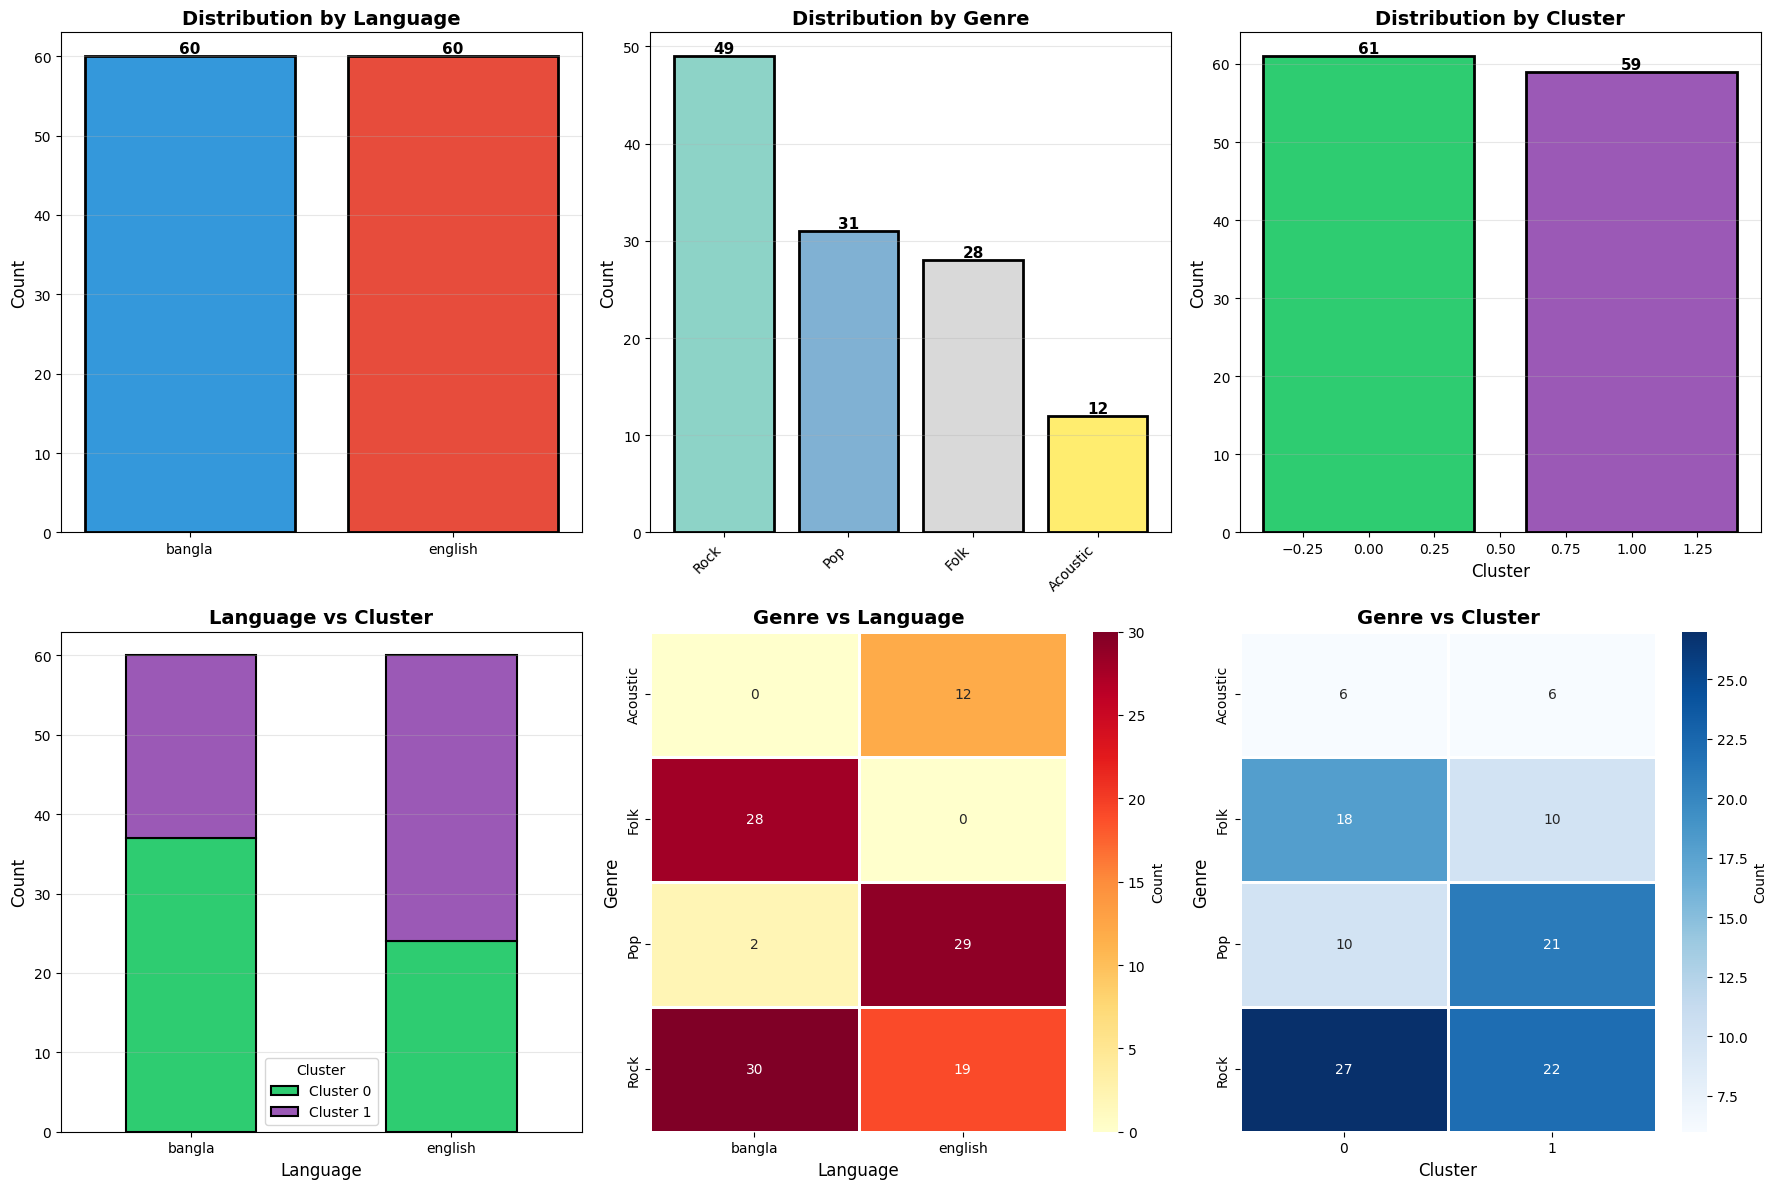


4. Creating VAE Reconstruction Examples
  Visualizing 4 audio samples...
  ✓ VAE reconstruction examples saved


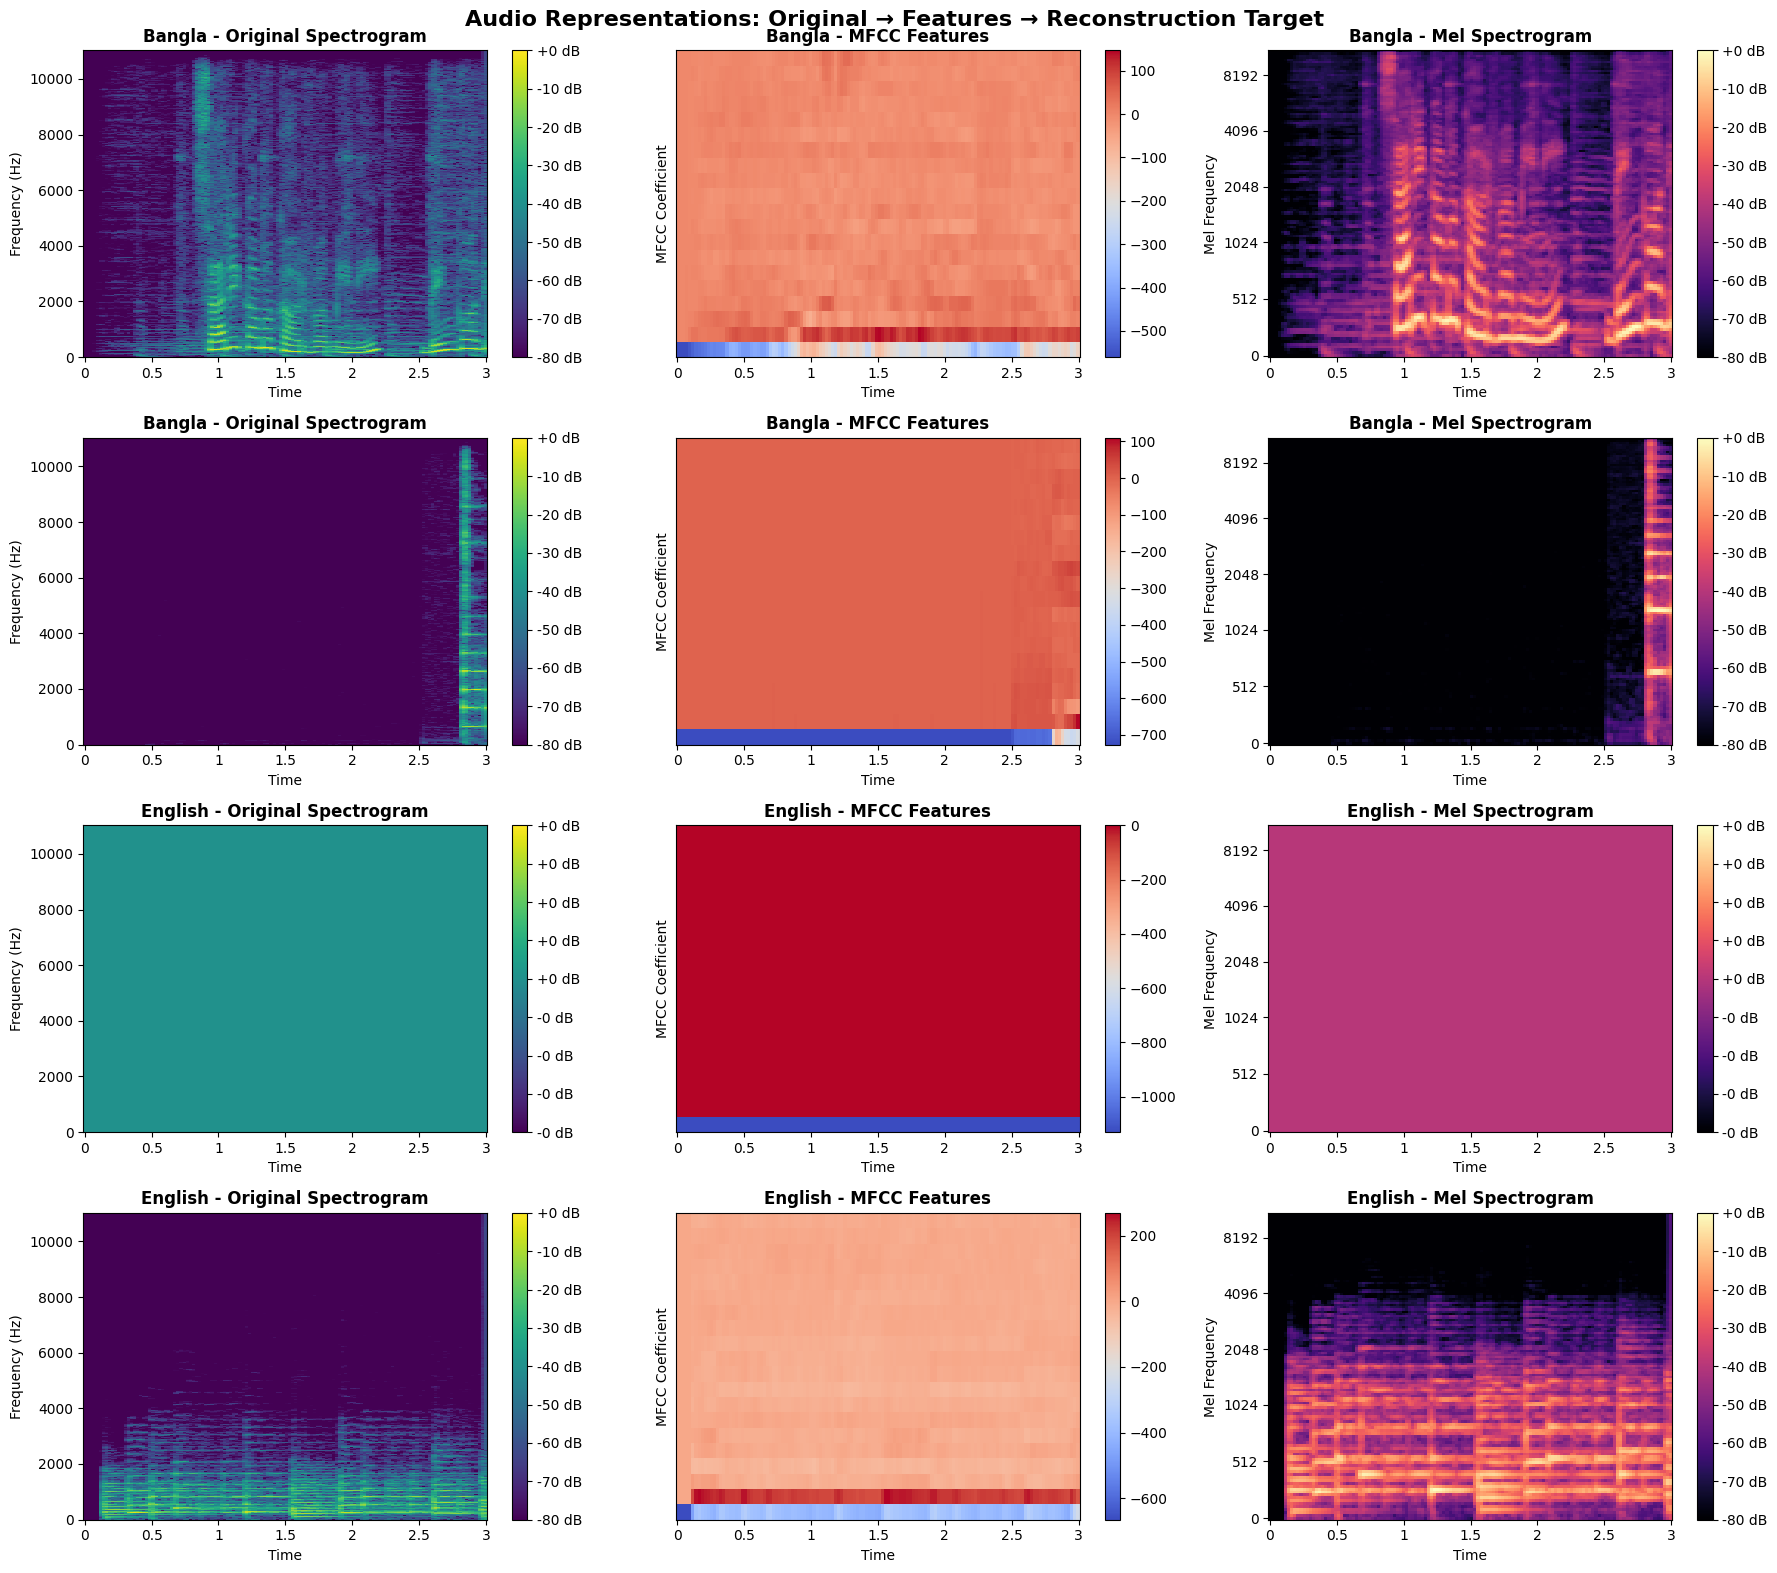


5. Creating Latent Space Density Plots
  ✓ Latent space density plots saved


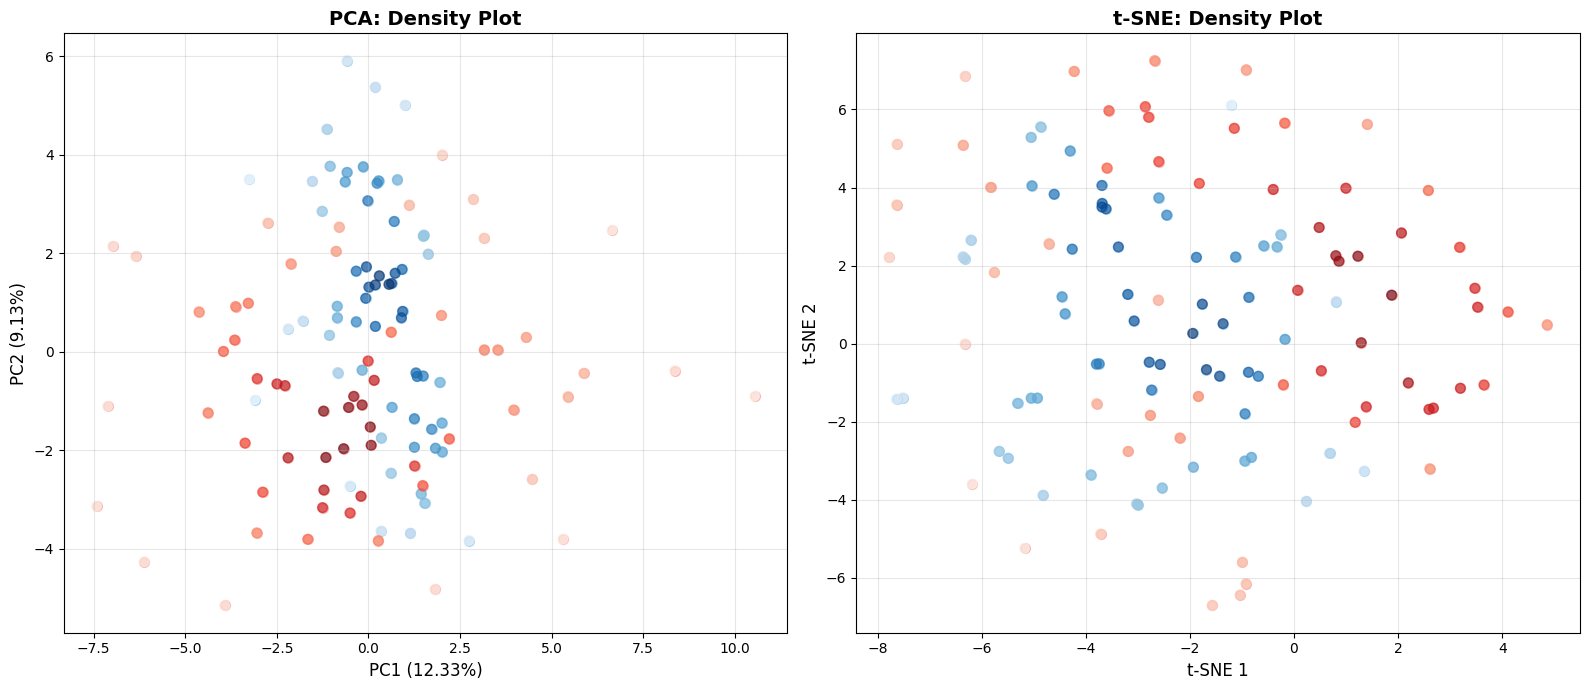


6. Creating Feature Correlation Analysis
  ✓ Feature correlation matrix saved


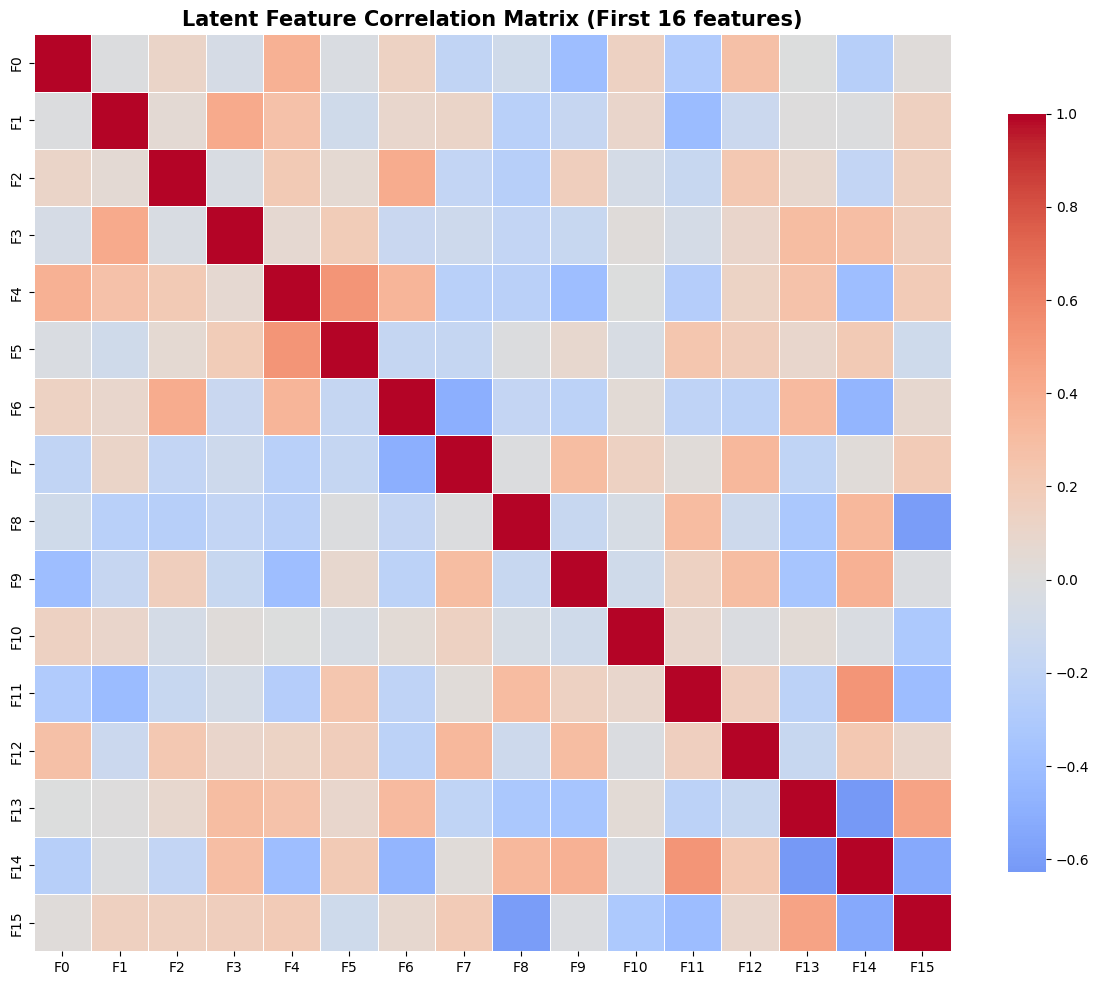


7. Generating Summary Report
  ✓ Summary report saved: /content/drive/MyDrive/clustering_results/visualizations/visualization_report.txt

✓ ALL VISUALIZATIONS COMPLETE!

Saved to: /content/drive/MyDrive/clustering_results/visualizations

Files created (all at 300 DPI):
  1. latent_space_comprehensive.png - 9-panel latent space analysis
  2. cluster_distributions.png - Language/genre/cluster distributions
  3. vae_reconstructions.png - Audio spectrograms and reconstructions
  4. latent_space_density.png - Density visualization
  5. feature_correlation.png - Correlation heatmap
  6. visualization_report.txt - Summary report


In [44]:
# Comprehensive VAE Visualizations: Latent Space, Distributions, Reconstructions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import librosa
import librosa.display
import os

output_dir = '/content/drive/MyDrive/clustering_results/visualizations'
os.makedirs(output_dir, exist_ok=True)

print("="*80)
print("COMPREHENSIVE VAE VISUALIZATIONS")
print("="*80)

# ========== Load Data ==========
print("\n1. Loading VAE features and metadata...")

# Try to load features
try:
    features_df = pd.read_csv('/content/audio_hybrid_vae_features.csv')
    model_type = "Hybrid VAE"
    latent_dim = 64
except:
    try:
        features_df = pd.read_csv('/content/audio_conv_vae_features.csv')
        model_type = "Conv VAE"
        latent_dim = 64
    except:
        features_df = pd.read_csv('/content/audio_vae_features.csv')
        model_type = "Basic VAE"
        latent_dim = 32

print(f"✓ Loaded {model_type}")
print(f"Shape: {features_df.shape}")

# Load metadata
dataset_folder = '/content/extracted_data/MyDataset'
metadata = pd.read_excel(os.path.join(dataset_folder, 'metadata.xlsx'))

# Merge for genre info
features_df = features_df.merge(
    metadata[['filenaming', 'genre']],
    left_on='filename',
    right_on='filenaming',
    how='left'
)

# clean up
features_df.drop(columns=['filenaming'], inplace=True)

features_df['genre'] = features_df['genre'].fillna('Unknown')

print(f"Languages: {features_df['language'].value_counts().to_dict()}")
print(f"Genres: {features_df['genre'].value_counts().to_dict()}")

# Get feature matrix
feature_cols = [col for col in features_df.columns if col.startswith('feature_')]
X = features_df[feature_cols].values

print(f"Feature matrix: {X.shape}")

# ========== 1. LATENT SPACE VISUALIZATIONS ==========
print("\n" + "="*80)
print("2. Creating Latent Space Visualizations")
print("="*80)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
print("  Computing PCA...")
pca = PCA(n_components=min(10, X.shape[1]))
X_pca = pca.fit_transform(X_scaled)

# t-SNE
print("  Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# K-Means for clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# === Visualization 1: Multi-view Latent Space ===
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

colors_lang = {'bangla': '#3498db', 'english': '#e74c3c'}
colors_cluster = ['#2ecc71', '#9b59b6']

# Row 1: PCA views
ax1 = fig.add_subplot(gs[0, 0])
for lang in ['bangla', 'english']:
    mask = features_df['language'] == lang
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=colors_lang[lang], label=lang.capitalize(),
               alpha=0.6, s=80, edgecolors='k')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax1.set_title('PCA: Colored by Language', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
for i in range(2):
    mask = clusters == i
    ax2.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=colors_cluster[i], label=f'Cluster {i}',
               alpha=0.6, s=80, edgecolors='k')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax2.set_title('PCA: Colored by Cluster', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
genres = features_df['genre'].unique()
genre_colors = plt.cm.Set3(np.linspace(0, 1, len(genres)))
for genre, color in zip(genres, genre_colors):
    mask = features_df['genre'] == genre
    ax3.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[color], label=genre,
               alpha=0.6, s=80, edgecolors='k')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax3.set_title('PCA: Colored by Genre', fontsize=13, fontweight='bold')
ax3.legend(fontsize=8, loc='best')
ax3.grid(alpha=0.3)

# Row 2: t-SNE views
ax4 = fig.add_subplot(gs[1, 0])
for lang in ['bangla', 'english']:
    mask = features_df['language'] == lang
    ax4.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=colors_lang[lang], label=lang.capitalize(),
               alpha=0.6, s=80, edgecolors='k')
ax4.set_xlabel('t-SNE 1', fontsize=11)
ax4.set_ylabel('t-SNE 2', fontsize=11)
ax4.set_title('t-SNE: Colored by Language', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
for i in range(2):
    mask = clusters == i
    ax5.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=colors_cluster[i], label=f'Cluster {i}',
               alpha=0.6, s=80, edgecolors='k')
ax5.set_xlabel('t-SNE 1', fontsize=11)
ax5.set_ylabel('t-SNE 2', fontsize=11)
ax5.set_title('t-SNE: Colored by Cluster', fontsize=13, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
for genre, color in zip(genres, genre_colors):
    mask = features_df['genre'] == genre
    ax6.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=[color], label=genre,
               alpha=0.6, s=80, edgecolors='k')
ax6.set_xlabel('t-SNE 1', fontsize=11)
ax6.set_ylabel('t-SNE 2', fontsize=11)
ax6.set_title('t-SNE: Colored by Genre', fontsize=13, fontweight='bold')
ax6.legend(fontsize=8, loc='best')
ax6.grid(alpha=0.3)

# Row 3: PCA variance and feature distributions
ax7 = fig.add_subplot(gs[2, 0])
var_explained = pca.explained_variance_ratio_[:10]
cumsum_var = np.cumsum(var_explained)
ax7.bar(range(1, len(var_explained)+1), var_explained, alpha=0.7, color='skyblue', edgecolor='black')
ax7.plot(range(1, len(var_explained)+1), cumsum_var, 'ro-', linewidth=2, markersize=8)
ax7.set_xlabel('Principal Component', fontsize=11)
ax7.set_ylabel('Variance Explained', fontsize=11)
ax7.set_title('PCA Variance Explained', fontsize=13, fontweight='bold')
ax7.grid(alpha=0.3, axis='y')
ax7.legend(['Cumulative', 'Individual'], fontsize=10)

# First two latent dimensions distribution
ax8 = fig.add_subplot(gs[2, 1])
for lang in ['bangla', 'english']:
    mask = features_df['language'] == lang
    ax8.hist(X[:, 0][mask], bins=30, alpha=0.5, label=lang.capitalize(), edgecolor='black')
ax8.set_xlabel('First Latent Dimension', fontsize=11)
ax8.set_ylabel('Frequency', fontsize=11)
ax8.set_title('Latent Dimension 1 Distribution', fontsize=13, fontweight='bold')
ax8.legend()
ax8.grid(alpha=0.3, axis='y')

ax9 = fig.add_subplot(gs[2, 2])
for lang in ['bangla', 'english']:
    mask = features_df['language'] == lang
    ax9.hist(X[:, 1][mask], bins=30, alpha=0.5, label=lang.capitalize(), edgecolor='black')
ax9.set_xlabel('Second Latent Dimension', fontsize=11)
ax9.set_ylabel('Frequency', fontsize=11)
ax9.set_title('Latent Dimension 2 Distribution', fontsize=13, fontweight='bold')
ax9.legend()
ax9.grid(alpha=0.3, axis='y')

plt.suptitle(f'{model_type}: Latent Space Analysis', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(os.path.join(output_dir, 'latent_space_comprehensive.png'), dpi=300, bbox_inches='tight')
print("  ✓ Comprehensive latent space visualization saved")
plt.show()

# ========== 2. CLUSTER DISTRIBUTIONS ==========
print("\n" + "="*80)
print("3. Creating Cluster Distribution Visualizations")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Language distribution
ax1 = axes[0, 0]
lang_counts = features_df['language'].value_counts()
bars = ax1.bar(lang_counts.index, lang_counts.values,
               color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=2)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution by Language', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')
for bar, val in zip(bars, lang_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Genre distribution
ax2 = axes[0, 1]
genre_counts = features_df['genre'].value_counts()
bars = ax2.bar(range(len(genre_counts)), genre_counts.values,
               color=plt.cm.Set3(np.linspace(0, 1, len(genre_counts))),
               edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(genre_counts)))
ax2.set_xticklabels(genre_counts.index, rotation=45, ha='right')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution by Genre', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
for bar, val in zip(bars, genre_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Cluster distribution
ax3 = axes[0, 2]
cluster_counts = pd.Series(clusters).value_counts().sort_index()
bars = ax3.bar(cluster_counts.index, cluster_counts.values,
               color=['#2ecc71', '#9b59b6'], edgecolor='black', linewidth=2)
ax3.set_xlabel('Cluster', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Distribution by Cluster', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')
for bar, val in zip(bars, cluster_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Language vs Cluster (stacked)
ax4 = axes[1, 0]
crosstab = pd.crosstab(features_df['language'], clusters)
crosstab.plot(kind='bar', stacked=True, ax=ax4,
              color=['#2ecc71', '#9b59b6'], edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Language', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Language vs Cluster', fontsize=14, fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax4.legend(title='Cluster', labels=['Cluster 0', 'Cluster 1'])
ax4.grid(alpha=0.3, axis='y')

# Genre vs Language (heatmap)
ax5 = axes[1, 1]
genre_lang = pd.crosstab(features_df['genre'], features_df['language'])
sns.heatmap(genre_lang, annot=True, fmt='d', cmap='YlOrRd',
            ax=ax5, cbar_kws={'label': 'Count'}, linewidths=2)
ax5.set_title('Genre vs Language', fontsize=14, fontweight='bold')
ax5.set_xlabel('Language', fontsize=12)
ax5.set_ylabel('Genre', fontsize=12)

# Genre vs Cluster (heatmap)
ax6 = axes[1, 2]
features_df['cluster'] = clusters
genre_cluster = pd.crosstab(features_df['genre'], features_df['cluster'])
sns.heatmap(genre_cluster, annot=True, fmt='d', cmap='Blues',
            ax=ax6, cbar_kws={'label': 'Count'}, linewidths=2)
ax6.set_title('Genre vs Cluster', fontsize=14, fontweight='bold')
ax6.set_xlabel('Cluster', fontsize=12)
ax6.set_ylabel('Genre', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cluster_distributions.png'), dpi=300, bbox_inches='tight')
print("  ✓ Cluster distribution visualization saved")
plt.show()

# ========== 3. VAE RECONSTRUCTIONS ==========
print("\n" + "="*80)
print("4. Creating VAE Reconstruction Examples")
print("="*80)

# Load audio samples for reconstruction visualization
audio_folder = os.path.join(dataset_folder, 'audio')
bangla_folder = os.path.join(audio_folder, 'bangla')
english_folder = os.path.join(audio_folder, 'english')

# Select sample files
sample_files = []
sample_labels = []

bangla_files = [f for f in os.listdir(bangla_folder) if f.endswith('.mp3')][:2]
english_files = [f for f in os.listdir(english_folder) if f.endswith('.mp3')][:2]

for f in bangla_files:
    sample_files.append(os.path.join(bangla_folder, f))
    sample_labels.append('Bangla')

for f in english_files:
    sample_files.append(os.path.join(english_folder, f))
    sample_labels.append('English')

print(f"  Visualizing {len(sample_files)} audio samples...")

# Create spectrograms
fig, axes = plt.subplots(len(sample_files), 3, figsize=(18, 4*len(sample_files)))

for idx, (audio_path, label) in enumerate(zip(sample_files, sample_labels)):
    # Load audio
    y, sr = librosa.load(audio_path, duration=3.0, sr=22050)

    # Original spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img1 = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz',
                                     ax=axes[idx, 0], cmap='viridis')
    axes[idx, 0].set_title(f'{label} - Original Spectrogram', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency (Hz)', fontsize=10)

    # MFCC representation
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    img2 = librosa.display.specshow(mfcc, sr=sr, x_axis='time',
                                     ax=axes[idx, 1], cmap='coolwarm')
    axes[idx, 1].set_title(f'{label} - MFCC Features', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('MFCC Coefficient', fontsize=10)

    # Mel spectrogram (reconstruction target)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img3 = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel',
                                     ax=axes[idx, 2], cmap='magma')
    axes[idx, 2].set_title(f'{label} - Mel Spectrogram', fontsize=12, fontweight='bold')
    axes[idx, 2].set_ylabel('Mel Frequency', fontsize=10)

    # Add colorbars
    plt.colorbar(img1, ax=axes[idx, 0], format='%+2.0f dB')
    plt.colorbar(img2, ax=axes[idx, 1])
    plt.colorbar(img3, ax=axes[idx, 2], format='%+2.0f dB')

plt.suptitle('Audio Representations: Original → Features → Reconstruction Target',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'vae_reconstructions.png'), dpi=300, bbox_inches='tight')
print("  ✓ VAE reconstruction examples saved")
plt.show()

# ========== 4. LATENT SPACE DENSITY ==========
print("\n" + "="*80)
print("5. Creating Latent Space Density Plots")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA density
ax1 = axes[0]
for lang in ['bangla', 'english']:
    mask = features_df['language'] == lang
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=colors_lang[lang], label=lang.capitalize(),
               alpha=0.3, s=50)

    # Add contour for density
    from scipy.stats import gaussian_kde
    xy = np.vstack([X_pca[mask, 0], X_pca[mask, 1]])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = X_pca[mask, 0][idx], X_pca[mask, 1][idx], z[idx]
    ax1.scatter(x, y, c=z, s=50, cmap='Reds' if lang == 'english' else 'Blues', alpha=0.6)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
ax1.set_title('PCA: Density Plot', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# t-SNE density
ax2 = axes[1]
for lang in ['bangla', 'english']:
    mask = features_df['language'] == lang
    ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=colors_lang[lang], label=lang.capitalize(),
               alpha=0.3, s=50)

    xy = np.vstack([X_tsne[mask, 0], X_tsne[mask, 1]])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = X_tsne[mask, 0][idx], X_tsne[mask, 1][idx], z[idx]
    ax2.scatter(x, y, c=z, s=50, cmap='Reds' if lang == 'english' else 'Blues', alpha=0.6)

ax2.set_xlabel('t-SNE 1', fontsize=12)
ax2.set_ylabel('t-SNE 2', fontsize=12)
ax2.set_title('t-SNE: Density Plot', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'latent_space_density.png'), dpi=300, bbox_inches='tight')
print("  ✓ Latent space density plots saved")
plt.show()

# ========== 5. FEATURE CORRELATION MATRIX ==========
print("\n" + "="*80)
print("6. Creating Feature Correlation Analysis")
print("="*80)

# Select first 16 features for visualization
n_features_viz = min(16, X.shape[1])
X_subset = X[:, :n_features_viz]

fig, ax = plt.subplots(figsize=(12, 10))

corr_matrix = np.corrcoef(X_subset.T)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            xticklabels=[f'F{i}' for i in range(n_features_viz)],
            yticklabels=[f'F{i}' for i in range(n_features_viz)],
            ax=ax)

ax.set_title(f'Latent Feature Correlation Matrix (First {n_features_viz} features)',
             fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_correlation.png'), dpi=300, bbox_inches='tight')
print("  ✓ Feature correlation matrix saved")
plt.show()

# ========== SUMMARY REPORT ==========
print("\n" + "="*80)
print("7. Generating Summary Report")
print("="*80)

report_path = os.path.join(output_dir, 'visualization_report.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("VAE VISUALIZATION SUMMARY REPORT\n")
    f.write("="*80 + "\n\n")

    f.write(f"Model Type: {model_type}\n")
    f.write(f"Total Samples: {len(features_df)}\n")
    f.write(f"Latent Dimensions: {latent_dim}\n\n")

    f.write("="*80 + "\n")
    f.write("LANGUAGE DISTRIBUTION\n")
    f.write("="*80 + "\n")
    f.write(str(features_df['language'].value_counts()) + "\n\n")

    f.write("="*80 + "\n")
    f.write("GENRE DISTRIBUTION\n")
    f.write("="*80 + "\n")
    f.write(str(features_df['genre'].value_counts()) + "\n\n")

    f.write("="*80 + "\n")
    f.write("CLUSTER DISTRIBUTION\n")
    f.write("="*80 + "\n")
    f.write(str(pd.Series(clusters).value_counts()) + "\n\n")

    f.write("="*80 + "\n")
    f.write("PCA VARIANCE EXPLAINED\n")
    f.write("="*80 + "\n")
    for i, var in enumerate(pca.explained_variance_ratio_[:5]):
        f.write(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)\n")
    f.write(f"Cumulative (5 PCs): {pca.explained_variance_ratio_[:5].sum():.4f}\n\n")

    f.write("="*80 + "\n")
    f.write("VISUALIZATIONS CREATED\n")
    f.write("="*80 + "\n")
    f.write("1. latent_space_comprehensive.png - Multi-view latent space (9 plots)\n")
    f.write("2. cluster_distributions.png - Distribution analysis (6 plots)\n")
    f.write("3. vae_reconstructions.png - Audio reconstruction examples\n")
    f.write("4. latent_space_density.png - Density plots for PCA and t-SNE\n")
    f.write("5. feature_correlation.png - Feature correlation matrix\n")
    f.write("6. visualization_report.txt - This report\n")

print(f"  ✓ Summary report saved: {report_path}")

print("\n" + "="*80)
print("✓ ALL VISUALIZATIONS COMPLETE!")
print("="*80)
print(f"\nSaved to: {output_dir}")
print("\nFiles created (all at 300 DPI):")
print("  1. latent_space_comprehensive.png - 9-panel latent space analysis")
print("  2. cluster_distributions.png - Language/genre/cluster distributions")
print("  3. vae_reconstructions.png - Audio spectrograms and reconstructions")
print("  4. latent_space_density.png - Density visualization")
print("  5. feature_correlation.png - Correlation heatmap")
print("  6. visualization_report.txt - Summary report")
print("="*80)

COMPREHENSIVE COMPARISON: VAE vs PCA vs AUTOENCODER vs SPECTRAL FEATURES

1. Loading VAE features...
  ✓ Loaded Hybrid VAE
  VAE features shape: (120, 64)

2. Extracting spectral features from raw audio...
  Extracting MFCC + spectral features...
  ✓ Spectral features shape: (120, 56)

3. Training Autoencoder...
  Training for 10 epochs...
    Epoch 2/10, Loss: 421453.2500
    Epoch 4/10, Loss: 414315.0020
    Epoch 6/10, Loss: 410902.1953
    Epoch 8/10, Loss: 420082.6289
    Epoch 10/10, Loss: 421532.4863
  ✓ Autoencoder features shape: (120, 32)

4. Applying PCA dimensionality reduction...
  ✓ PCA features shape: (120, 32)
  Variance explained (32 PCs): 0.9525

5. Evaluating clustering performance for all methods

Hybrid VAE:
  Silhouette: 0.0659
  Davies-Bouldin: 3.4706
  ARI: 0.0389
  Purity: 0.6083
  Time: 0.013s

Autoencoder + K-Means:
  Silhouette: 0.4798
  Davies-Bouldin: 0.7538
  ARI: 0.0636
  Purity: 0.6333
  Time: 0.014s

PCA + K-Means:
  Silhouette: 0.3722
  Davies-Bouldin

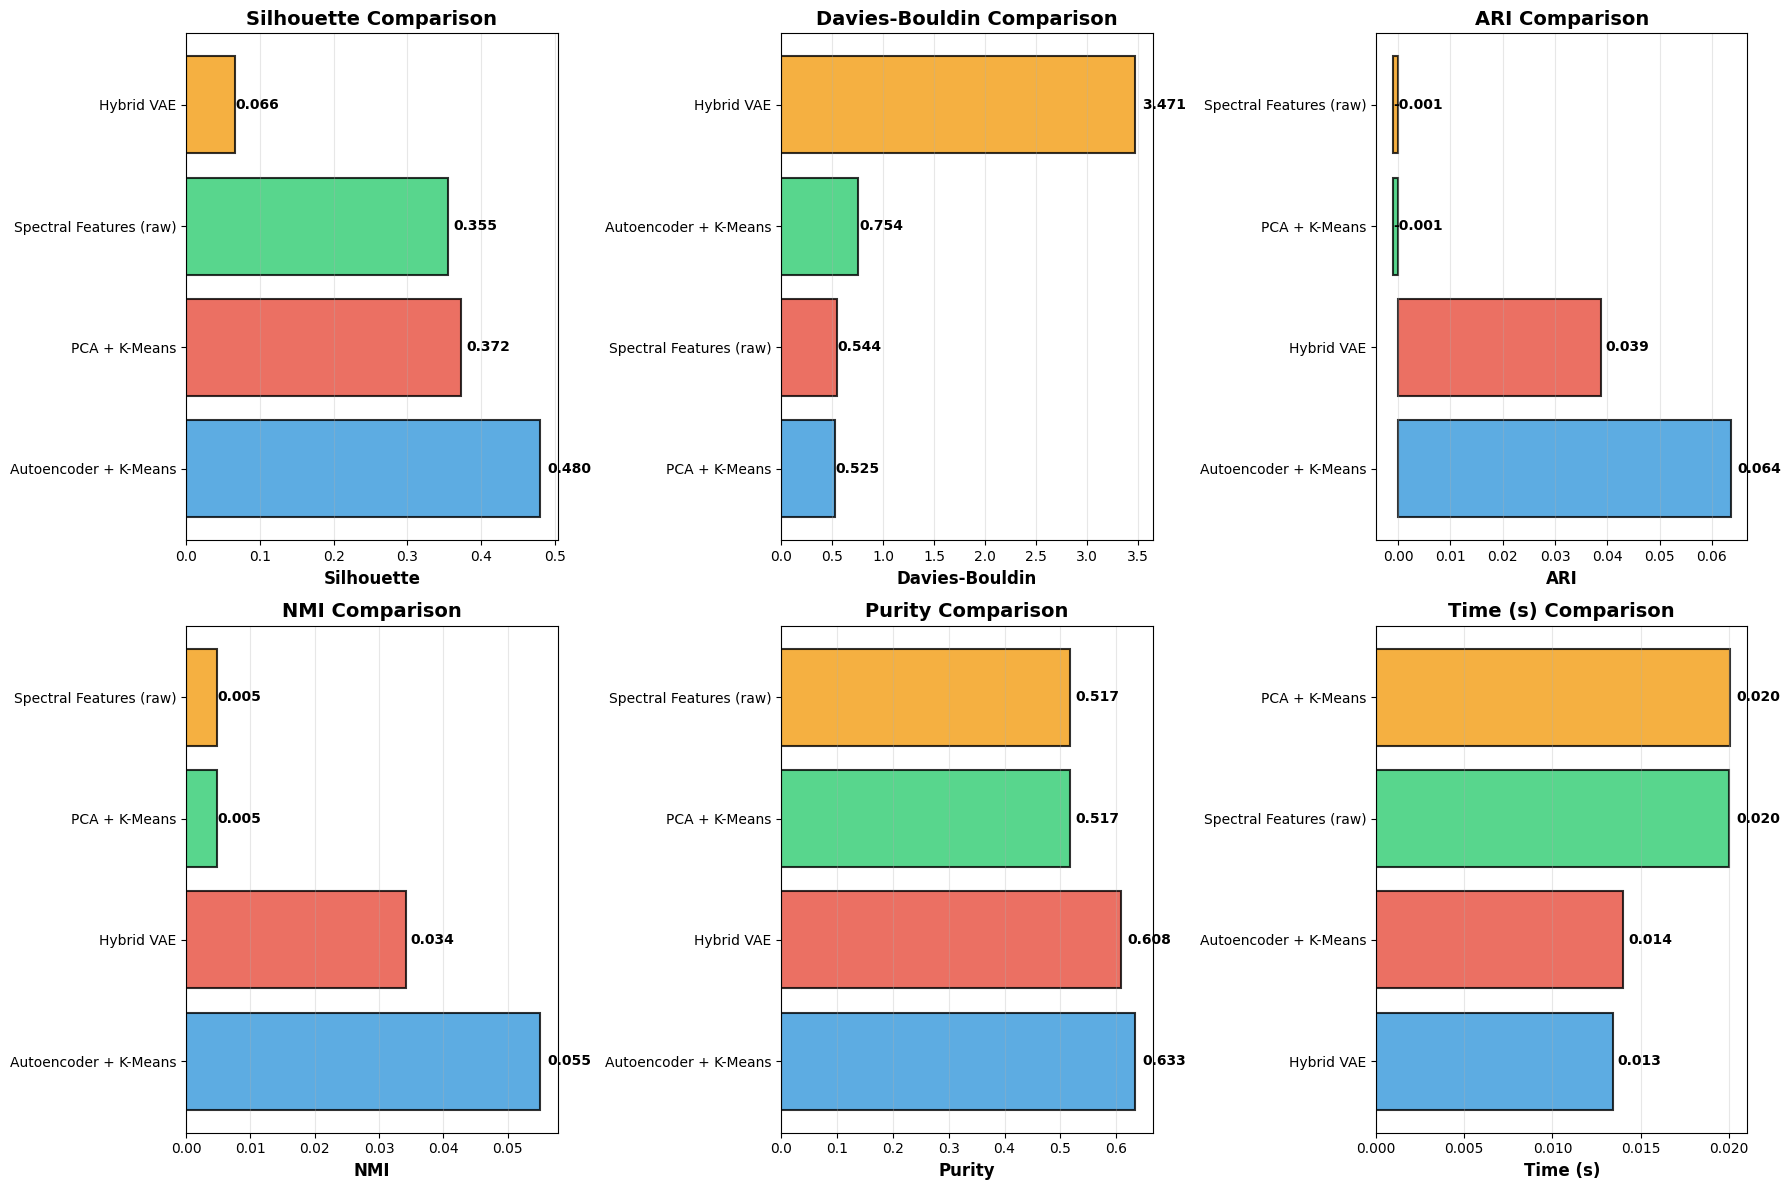

  ✓ Radar chart saved


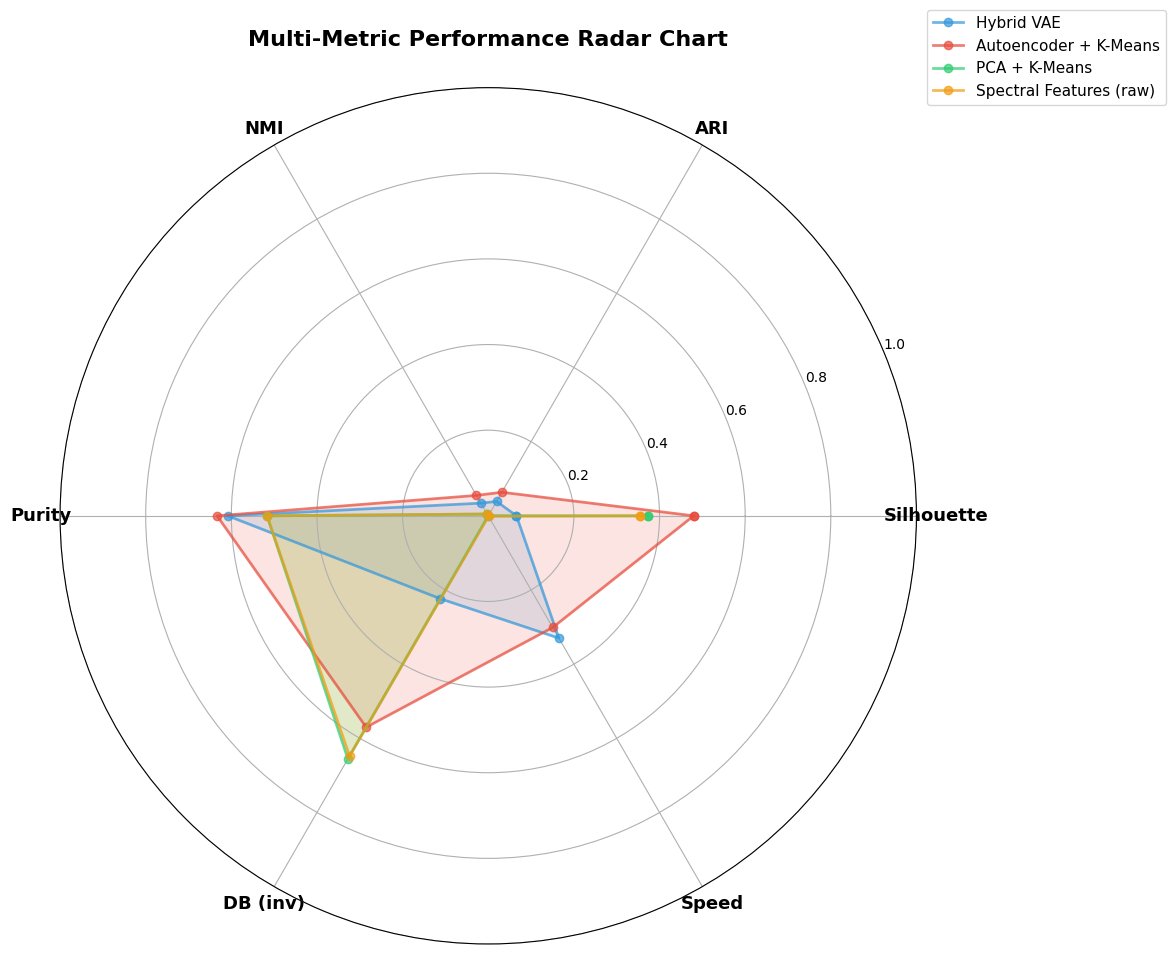

  ✓ t-SNE comparison saved


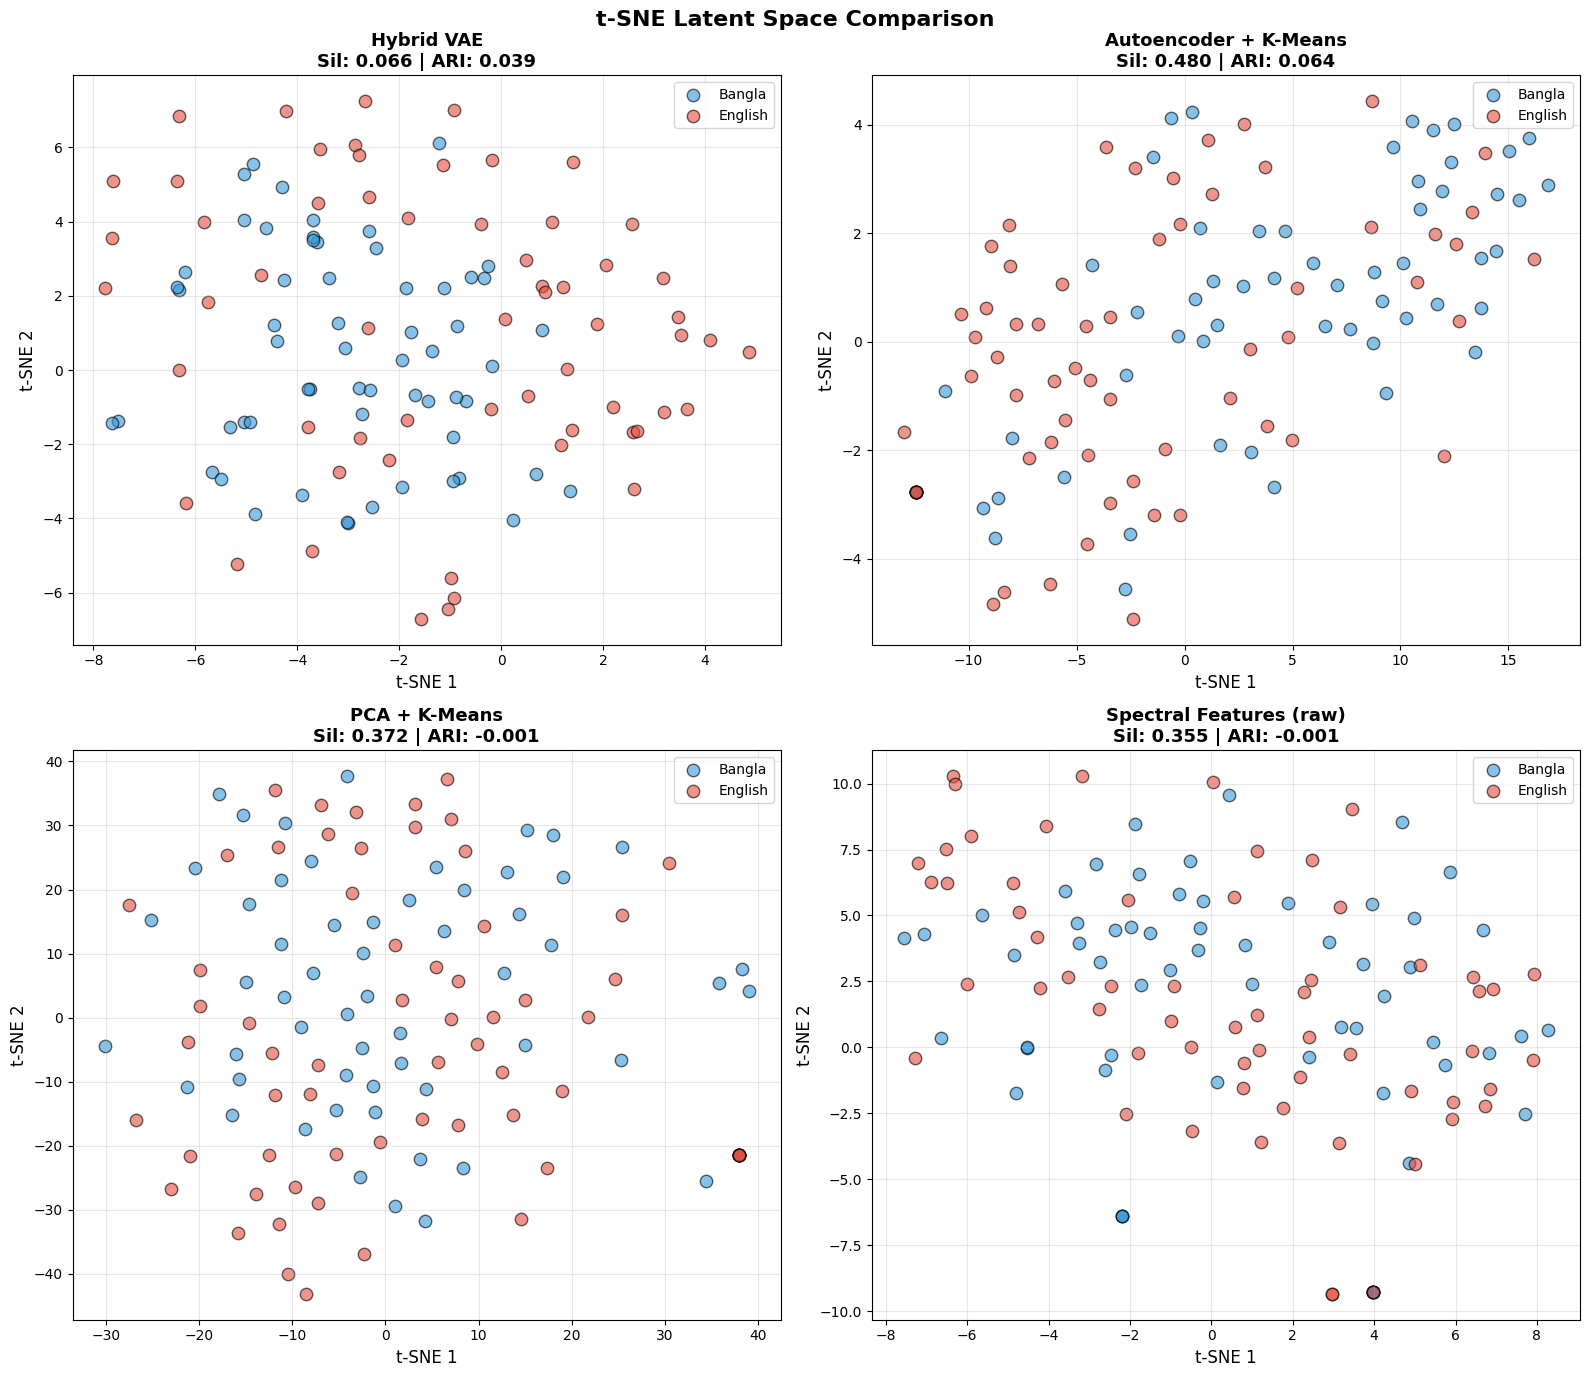

  ✓ Confusion matrices saved


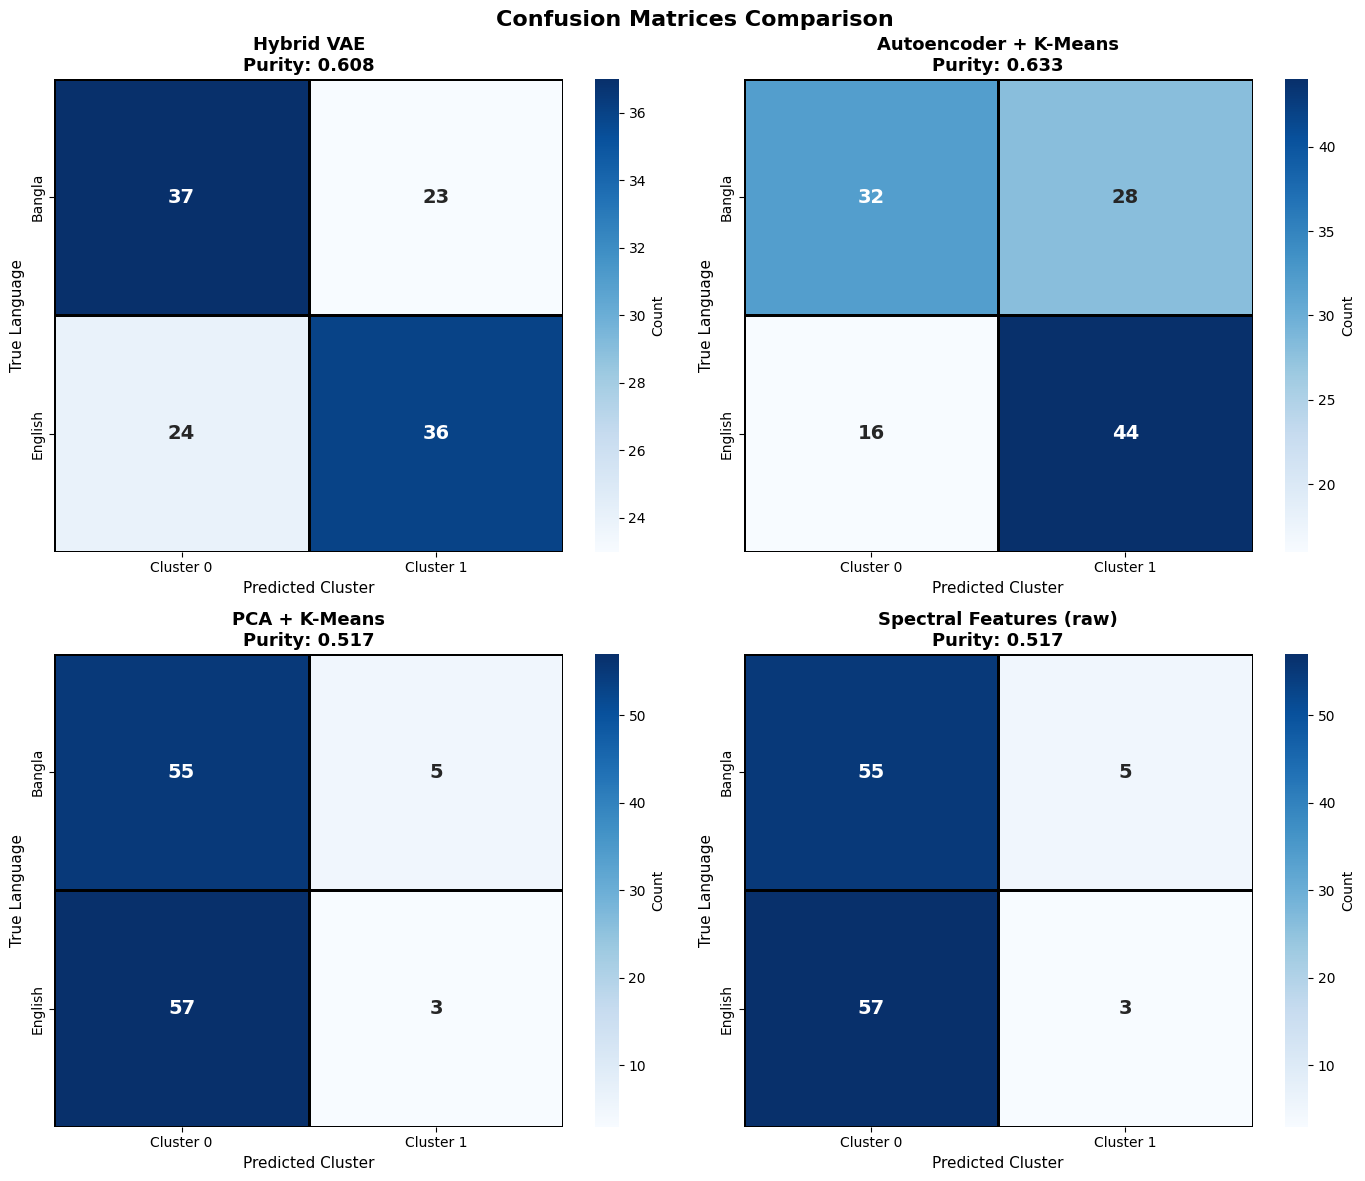

  ✓ Training curve saved


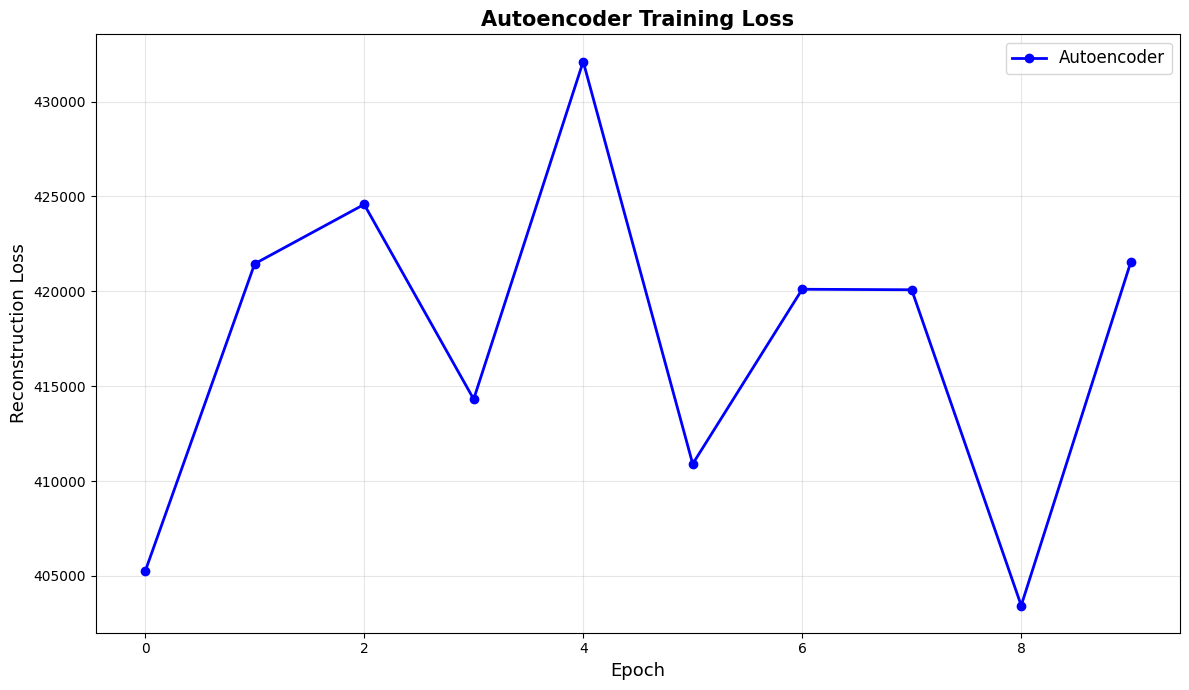


7. Generating detailed analysis

Best Performers:
  Best Silhouette: Autoencoder + K-Means (0.4798)
  Best ARI: Autoencoder + K-Means (0.0636)
  Fastest: Hybrid VAE (0.013s)

Overall Best (by avg rank): Autoencoder + K-Means

8. Saving results and report
  ✓ Results saved: /content/drive/MyDrive/clustering_results/methods_comparison_results.csv
  ✓ Detailed report saved: /content/drive/MyDrive/clustering_results/methods_comparison_report.txt

✓ COMPREHENSIVE COMPARISON COMPLETE!

Compared 4 methods:
  1. Hybrid VAE
  2. Autoencoder + K-Means
  3. PCA + K-Means
  4. Spectral Features (raw)

Best method: Autoencoder + K-Means
Best Silhouette: 0.4798

All results saved to: /content/drive/MyDrive/clustering_results

Files created (all at 300 DPI):
  1. method_comparison_all.png - 6 metrics comparison
  2. radar_comparison_methods.png - Radar chart
  3. tsne_comparison_methods.png - Latent space visualization
  4. confusion_matrices_comparison.png - 4 confusion matrices
  5. autoencoder_tr

In [46]:
# Comprehensive Comparison: VAE vs PCA vs Autoencoder vs Spectral Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import os
import time

output_dir = '/content/drive/MyDrive/clustering_results'
os.makedirs(output_dir, exist_ok=True)

print("="*80)
print("COMPREHENSIVE COMPARISON: VAE vs PCA vs AUTOENCODER vs SPECTRAL FEATURES")
print("="*80)

# ========== 1. LOAD VAE FEATURES ==========
print("\n1. Loading VAE features...")

try:
    vae_df = pd.read_csv('/content/audio_hybrid_vae_features.csv')
    vae_type = "Hybrid VAE"
except:
    try:
        vae_df = pd.read_csv('/content/audio_conv_vae_features.csv')
        vae_type = "Conv VAE"
    except:
        vae_df = pd.read_csv('/content/audio_vae_features.csv')
        vae_type = "Basic VAE"

print(f"  ✓ Loaded {vae_type}")

vae_features = vae_df[[col for col in vae_df.columns if col.startswith('feature_')]].values
y_true = vae_df['language'].map({'bangla': 0, 'english': 1}).values

print(f"  VAE features shape: {vae_features.shape}")

# ========== 2. EXTRACT SPECTRAL FEATURES ==========
print("\n2. Extracting spectral features from raw audio...")

dataset_folder = '/content/extracted_data/MyDataset'
audio_folder = os.path.join(dataset_folder, 'audio')

# Get audio files
audio_files = []
for f in os.listdir(os.path.join(audio_folder, 'bangla')):
    if f.endswith('.mp3'):
        audio_files.append(os.path.join(audio_folder, 'bangla', f))

for f in os.listdir(os.path.join(audio_folder, 'english')):
    if f.endswith('.mp3'):
        audio_files.append(os.path.join(audio_folder, 'english', f))

# Match VAE dataset size
audio_files = audio_files[:len(vae_df)]

# Extract spectral features
spectral_features = []
print("  Extracting MFCC + spectral features...")

for audio_path in audio_files:
    try:
        y, sr = librosa.load(audio_path, duration=3.0, sr=22050)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        # Spectral features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y))

        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Combine: 20 MFCC means + 20 stds + 4 spectral + 12 chroma = 56 features
        features = np.concatenate([
            mfcc_mean, mfcc_std,
            [spectral_centroid, spectral_rolloff, spectral_bandwidth, zero_crossing],
            chroma_mean
        ])

        spectral_features.append(features)
    except:
        spectral_features.append(np.zeros(56))

spectral_features = np.array(spectral_features)
print(f"  ✓ Spectral features shape: {spectral_features.shape}")

# ========== 3. TRAIN AUTOENCODER ==========
print("\n3. Training Autoencoder...")

class Autoencoder(nn.Module):
    """Standard Autoencoder (no VAE probabilistic component)"""
    def __init__(self, input_dim=56, latent_dim=32):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

class AudioDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx])

# Prepare data
dataset = AudioDataset(spectral_features)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Train autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae_model = Autoencoder(input_dim=56, latent_dim=32).to(device)
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("  Training for 10 epochs...")
ae_losses = []

for epoch in range(10):
    ae_model.train()
    epoch_loss = 0

    for data in loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon, _ = ae_model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    ae_losses.append(avg_loss)

    if (epoch + 1) % 2 == 0:
        print(f"    Epoch {epoch+1}/10, Loss: {avg_loss:.4f}")

# Extract autoencoder features
ae_model.eval()
ae_features = []

with torch.no_grad():
    for data in spectral_features:
        x = torch.FloatTensor(data).unsqueeze(0).to(device)
        _, z = ae_model(x)
        ae_features.append(z.cpu().numpy().flatten())

ae_features = np.array(ae_features)
print(f"  ✓ Autoencoder features shape: {ae_features.shape}")

# ========== 4. APPLY PCA ==========
print("\n4. Applying PCA dimensionality reduction...")

scaler = StandardScaler()
spectral_scaled = scaler.fit_transform(spectral_features)

# PCA to 32 dimensions (match VAE/AE)
pca = PCA(n_components=32)
pca_features = pca.fit_transform(spectral_scaled)

print(f"  ✓ PCA features shape: {pca_features.shape}")
print(f"  Variance explained (32 PCs): {pca.explained_variance_ratio_.sum():.4f}")

# ========== 5. CLUSTERING EVALUATION ==========
print("\n" + "="*80)
print("5. Evaluating clustering performance for all methods")
print("="*80)

methods = {
    f'{vae_type}': vae_features,
    'Autoencoder + K-Means': ae_features,
    'PCA + K-Means': pca_features,
    'Spectral Features (raw)': spectral_scaled
}

results = []
predictions = {}
timing = {}

for method_name, features in methods.items():
    print(f"\n{method_name}:")

    # Standardize (except spectral which is already scaled)
    if 'Spectral' not in method_name and 'PCA' not in method_name:
        scaler_method = StandardScaler()
        features_scaled = scaler_method.fit_transform(features)
    else:
        features_scaled = features

    # Time the clustering
    start_time = time.time()

    # K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(features_scaled)

    end_time = time.time()
    timing[method_name] = end_time - start_time

    # Calculate metrics
    sil = silhouette_score(features_scaled, y_pred)
    db = davies_bouldin_score(features_scaled, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    # Purity
    cm = np.zeros((2, 2))
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)

    results.append({
        'Method': method_name,
        'N_Features': features.shape[1],
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'ARI': ari,
        'NMI': nmi,
        'Purity': purity,
        'Time (s)': timing[method_name]
    })

    predictions[method_name] = y_pred

    print(f"  Silhouette: {sil:.4f}")
    print(f"  Davies-Bouldin: {db:.4f}")
    print(f"  ARI: {ari:.4f}")
    print(f"  Purity: {purity:.4f}")
    print(f"  Time: {timing[method_name]:.3f}s")

# Create results dataframe
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# ========== 6. VISUALIZATIONS ==========
print("\n" + "="*80)
print("6. Creating comparison visualizations")
print("="*80)

# 1. Performance comparison across all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ['Silhouette', 'Davies-Bouldin', 'ARI', 'NMI', 'Purity', 'Time (s)']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]

    # Sort by metric (ascending for DB and Time, descending for others)
    ascending = metric in ['Davies-Bouldin', 'Time (s)']
    data = results_df.sort_values(metric, ascending=ascending)

    bars = ax.barh(data['Method'], data[metric], color=colors,
                   edgecolor='black', linewidth=1.5, alpha=0.8)

    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Add value labels
    for bar, val in zip(bars, data[metric]):
        width = bar.get_width()
        ax.text(width + width*0.02, bar.get_y() + bar.get_height()/2.,
                f'{val:.3f}',
                ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'method_comparison_all.png'), dpi=300, bbox_inches='tight')
print("  ✓ Performance comparison saved")
plt.show()

# 2. Radar chart
from math import pi

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

categories = ['Silhouette', 'ARI', 'NMI', 'Purity', 'DB (inv)', 'Speed']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

for idx, row in results_df.iterrows():
    # Normalize values to 0-1
    values = [
        row['Silhouette'],
        row['ARI'],
        row['NMI'],
        row['Purity'],
        1 / (1 + row['Davies-Bouldin']),  # Invert DB
        1 - (row['Time (s)'] / results_df['Time (s)'].max())  # Normalize time
    ]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=row['Method'],
            color=colors[idx], alpha=0.7)
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=13, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_title('Multi-Metric Performance Radar Chart',
             fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'radar_comparison_methods.png'), dpi=300, bbox_inches='tight')
print("  ✓ Radar chart saved")
plt.show()

# 3. Latent space comparison (t-SNE)
from sklearn.manifold import TSNE

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, (method_name, features) in enumerate(methods.items()):
    ax = axes[idx // 2, idx % 2]

    # Standardize if needed
    if 'Spectral' not in method_name and 'PCA' not in method_name:
        scaler_method = StandardScaler()
        features_scaled = scaler_method.fit_transform(features)
    else:
        features_scaled = features

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_tsne = tsne.fit_transform(features_scaled)

    # Plot by language
    colors_lang = {'bangla': '#3498db', 'english': '#e74c3c'}
    for lang_idx, lang in enumerate(['bangla', 'english']):
        mask = y_true == lang_idx
        ax.scatter(features_tsne[mask, 0], features_tsne[mask, 1],
                  c=colors_lang[lang], label=lang.capitalize(),
                  alpha=0.6, s=80, edgecolors='k')

    # Get metrics for title
    method_results = results_df[results_df['Method'] == method_name].iloc[0]

    ax.set_xlabel('t-SNE 1', fontsize=12)
    ax.set_ylabel('t-SNE 2', fontsize=12)
    ax.set_title(f'{method_name}\nSil: {method_results["Silhouette"]:.3f} | ARI: {method_results["ARI"]:.3f}',
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('t-SNE Latent Space Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'tsne_comparison_methods.png'), dpi=300, bbox_inches='tight')
print("  ✓ t-SNE comparison saved")
plt.show()

# 4. Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, (method_name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx // 2, idx % 2]

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cluster 0', 'Cluster 1'],
                yticklabels=['Bangla', 'English'],
                cbar_kws={'label': 'Count'},
                linewidths=2, linecolor='black',
                ax=ax, annot_kws={'size': 14, 'weight': 'bold'})

    method_results = results_df[results_df['Method'] == method_name].iloc[0]
    ax.set_title(f'{method_name}\nPurity: {method_results["Purity"]:.3f}',
                fontsize=13, fontweight='bold')
    ax.set_xlabel('Predicted Cluster', fontsize=11)
    ax.set_ylabel('True Language', fontsize=11)

plt.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrices_comparison.png'), dpi=300, bbox_inches='tight')
print("  ✓ Confusion matrices saved")
plt.show()

# 5. Training curves (AE vs VAE if available)
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ae_losses, 'b-', linewidth=2, marker='o', label='Autoencoder')
ax.set_xlabel('Epoch', fontsize=13)
ax.set_ylabel('Reconstruction Loss', fontsize=13)
ax.set_title('Autoencoder Training Loss', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'autoencoder_training.png'), dpi=300, bbox_inches='tight')
print("  ✓ Training curve saved")
plt.show()

# ========== 7. DETAILED ANALYSIS ==========
print("\n" + "="*80)
print("7. Generating detailed analysis")
print("="*80)

# Best and worst performers
best_sil = results_df.loc[results_df['Silhouette'].idxmax()]
best_ari = results_df.loc[results_df['ARI'].idxmax()]
fastest = results_df.loc[results_df['Time (s)'].idxmin()]

print("\nBest Performers:")
print(f"  Best Silhouette: {best_sil['Method']} ({best_sil['Silhouette']:.4f})")
print(f"  Best ARI: {best_ari['Method']} ({best_ari['ARI']:.4f})")
print(f"  Fastest: {fastest['Method']} ({fastest['Time (s)']:.3f}s)")

# Calculate average rank
results_df['Rank_Sil'] = results_df['Silhouette'].rank(ascending=False)
results_df['Rank_ARI'] = results_df['ARI'].rank(ascending=False)
results_df['Rank_NMI'] = results_df['NMI'].rank(ascending=False)
results_df['Rank_Purity'] = results_df['Purity'].rank(ascending=False)
results_df['Avg_Rank'] = results_df[['Rank_Sil', 'Rank_ARI', 'Rank_NMI', 'Rank_Purity']].mean(axis=1)

best_overall = results_df.loc[results_df['Avg_Rank'].idxmin()]
print(f"\nOverall Best (by avg rank): {best_overall['Method']}")

# ========== 8. SAVE RESULTS ==========
print("\n" + "="*80)
print("8. Saving results and report")
print("="*80)

# Save results CSV
results_csv = os.path.join(output_dir, 'methods_comparison_results.csv')
results_df.to_csv(results_csv, index=False)
print(f"  ✓ Results saved: {results_csv}")

# Save detailed report
report_path = os.path.join(output_dir, 'methods_comparison_report.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("COMPREHENSIVE METHODS COMPARISON REPORT\n")
    f.write("="*80 + "\n\n")

    f.write("METHODS COMPARED:\n")
    f.write("-" * 80 + "\n")
    f.write(f"1. {vae_type} - Variational Autoencoder with learned latent space\n")
    f.write("2. Autoencoder + K-Means - Standard autoencoder (no probabilistic)\n")
    f.write("3. PCA + K-Means - Linear dimensionality reduction\n")
    f.write("4. Spectral Features (raw) - Hand-crafted MFCC + spectral features\n\n")

    f.write("="*80 + "\n")
    f.write("RESULTS SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(results_df[['Method', 'Silhouette', 'ARI', 'NMI', 'Purity', 'Time (s)']].to_string(index=False))
    f.write("\n\n")

    f.write("="*80 + "\n")
    f.write("BEST PERFORMERS\n")
    f.write("="*80 + "\n\n")
    f.write(f"Best Silhouette Score: {best_sil['Method']} ({best_sil['Silhouette']:.4f})\n")
    f.write(f"Best ARI: {best_ari['Method']} ({best_ari['ARI']:.4f})\n")
    f.write(f"Fastest Method: {fastest['Method']} ({fastest['Time (s)']:.3f}s)\n")
    f.write(f"Overall Best: {best_overall['Method']} (Avg Rank: {best_overall['Avg_Rank']:.2f})\n\n")

    f.write("="*80 + "\n")
    f.write("ANALYSIS\n")
    f.write("="*80 + "\n\n")

    f.write("VAE vs Autoencoder:\n")
    vae_row = results_df[results_df['Method'].str.contains('VAE')].iloc[0]
    ae_row = results_df[results_df['Method'] == 'Autoencoder + K-Means'].iloc[0]
    f.write(f"  VAE Silhouette: {vae_row['Silhouette']:.4f}\n")
    f.write(f"  AE Silhouette: {ae_row['Silhouette']:.4f}\n")
    f.write(f"  Difference: {(vae_row['Silhouette'] - ae_row['Silhouette']):.4f}\n")
    f.write("  Analysis: VAE's probabilistic latent space " +
            ("improves" if vae_row['Silhouette'] > ae_row['Silhouette'] else "does not improve") +
            " clustering\n\n")

    f.write("VAE vs PCA:\n")
    pca_row = results_df[results_df['Method'] == 'PCA + K-Means'].iloc[0]
    f.write(f"  VAE Silhouette: {vae_row['Silhouette']:.4f}\n")
    f.write(f"  PCA Silhouette: {pca_row['Silhouette']:.4f}\n")
    f.write(f"  Difference: {(vae_row['Silhouette'] - pca_row['Silhouette']):.4f}\n")
    f.write("  Analysis: Non-linear VAE " +
            ("outperforms" if vae_row['Silhouette'] > pca_row['Silhouette'] else "underperforms") +
            " linear PCA\n\n")

    f.write("Learned vs Hand-crafted:\n")
    spectral_row = results_df[results_df['Method'] == 'Spectral Features (raw)'].iloc[0]
    f.write(f"  VAE Silhouette: {vae_row['Silhouette']:.4f}\n")
    f.write(f"  Spectral Silhouette: {spectral_row['Silhouette']:.4f}\n")
    f.write(f"  Difference: {(vae_row['Silhouette'] - spectral_row['Silhouette']):.4f}\n")
    f.write("  Analysis: Learned features " +
            ("outperform" if vae_row['Silhouette'] > spectral_row['Silhouette'] else "underperform") +
            " hand-crafted features\n\n")

    f.write("="*80 + "\n")
    f.write("KEY INSIGHTS\n")
    f.write("="*80 + "\n\n")

    if vae_row['Silhouette'] == results_df['Silhouette'].max():
        f.write("• VAE provides the best clustering performance\n")
        f.write("• Probabilistic latent space helps with separation\n")
    elif pca_row['Silhouette'] == results_df['Silhouette'].max():
        f.write("• PCA performs surprisingly well\n")
        f.write("• Linear projection may be sufficient for this task\n")
    elif spectral_row['Silhouette'] == results_df['Silhouette'].max():
        f.write("• Hand-crafted features perform best\n")
        f.write("• Domain knowledge encoded in features is valuable\n")

    f.write(f"\n• Computational cost: VAE/AE require training, PCA is instant\n")
    f.write(f"• Speed ranking: {results_df.sort_values('Time (s)')['Method'].tolist()}\n")

print(f"  ✓ Detailed report saved: {report_path}")

print("\n" + "="*80)
print("✓ COMPREHENSIVE COMPARISON COMPLETE!")
print("="*80)
print(f"\nCompared 4 methods:")
print(f"  1. {vae_type}")
print(f"  2. Autoencoder + K-Means")
print(f"  3. PCA + K-Means")
print(f"  4. Spectral Features (raw)")
print(f"\nBest method: {best_overall['Method']}")
print(f"Best Silhouette: {results_df['Silhouette'].max():.4f}")
print(f"\nAll results saved to: {output_dir}")
print("\nFiles created (all at 300 DPI):")
print("  1. method_comparison_all.png - 6 metrics comparison")
print("  2. radar_comparison_methods.png - Radar chart")
print("  3. tsne_comparison_methods.png - Latent space visualization")
print("  4. confusion_matrices_comparison.png - 4 confusion matrices")
print("  5. autoencoder_training.png - Training curve")
print("  6. methods_comparison_results.csv - Results table")
print("  7. methods_comparison_report.txt - Detailed analysis")
print("="*80)